In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from netCDF4 import Dataset, MFDataset
import matplotlib.pyplot as plt
import glob
from datetime import datetime, timedelta
from scipy import stats
import xskillscore as xs
from sklearn.metrics import mean_squared_error
import shutil
from scipy.spatial import distance
import metpy

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import sys, os, time, warnings, calendar
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore')

# Model benchmark

In [2]:
def model_eval(x, y, dname):
    # x is model
    # y is observation
    xmean = x.mean(dim=dname)
    ymean = y.mean(dim=dname)
    bias = (x-y).mean(dim=dname)
    xstd = x.std(dim=dname)
    ystd = y.std(dim=dname)
    diff = ( (x-y)**2 ).mean(dim=dname)
    corr = xr.corr(x,y,dim=dname)
    return np.sqrt(diff), bias, xstd, ystd, corr

def area_avg_weight_val(a,lon_str,lat_str):
    weights = np.cos(np.deg2rad(a.lat))
    weights.name = 'weights'
    a_weighted = a.weighted(weights)
    a_weighted_mean = a_weighted.mean(('lon','lat'))
    return a_weighted_mean.item()

def area_avg_weight(a,lon_str,lat_str):
    weights = np.cos(np.deg2rad(a.lat))
    weights.name = 'weights'
    a_weighted = a.weighted(weights)
    a_weighted_mean = a_weighted.mean(('lon','lat'))
    return a_weighted_mean

In [3]:
import xesmf as xe

res = 2
mlon = np.round( np.arange(-180+res/2,180+res/2,res), 3)
mlat = np.round( np.arange(-90+res/2,90+res/2,res), 3)

ds_out = xr.Dataset({"lat": (["lat"], mlat), "lon": (["lon"], mlon), })
ds_out

<xarray.Dataset>
Dimensions:  (lat: 90, lon: 180)
Coordinates:
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
Data variables:
    *empty*

In [4]:
# data = xr.open_dataset('/home/eseo/python/model_evel/data/1901-2005/obs/GPCC_pr_station_190101-200512.nc')
p = xr.open_dataset('/home/eseo/python/model_evel/data/1901-2005/obs/GPCC_pr_190101-200512.nc')['pr'] * 86400.
t = xr.open_dataset('/home/eseo/python/model_evel/data/1901-2005/obs/CRU_tas_190101-200512.nc')['tas']
# ot.mean(dim='time').plot()
time_bk = t.time    
p = p.assign_coords({"time": (time_bk)})

regridder = xe.Regridder(p, ds_out, "bilinear")
op = regridder(p)
ot = regridder(t)
del p, t

In [5]:
cmip5_name = ['ACCESS1-0','CanESM2','CCSM4','CMCC-CM','CNRM-CM5',
              'GFDL-CM2.1','GISS-E2-H','INM-CM4-0','IPSL-CM5A-LR','MIROC5',
              'HadGEM2-AO','MPI-ESM-LR','MRI-ESM1','NorESM1-M']
cmip6_name = ['ACCESS-CM2','CanESM5','CESM2-WACCM','CMCC-CM2-HR4','CNRM-ESM2-1',
              'GFDL-CM4','GISS-E2-1-H','INM-CM5-0','IPSL-CM6A-LR','MIROC6',
              'HadGEM3-GC31-LL','MPI-ESM1-2-LR','MRI-ESM2-0','NorESM2-MM']
cname = ['A','C1','C2','C3','C4',
         'G1','G2','I1','I2','M1',
         'M2','M3','M4','N']

In [6]:
p_c5 = xr.DataArray(data = np.empty([len(cmip5_name),len(ot.time),len(ds_out.lat),len(ds_out.lon)]) * np.nan, 
                     dims=["models","time","lat","lon"],
                     coords = dict(models=(["models"], [x for x in range(len(cmip5_name))]),
                                   time=(["time"], ot.time.values),
                                   lat=(["lat"], ds_out.lat.values),
                                   lon=(["lon"], ds_out.lon.values),
                                  )
                    )
t_c5 = p_c5.copy(deep=True)
p_c6 = p_c5.copy(deep=True)
t_c6 = p_c5.copy(deep=True)

dir = '/home/eseo/python/model_evel/data/1901-2005/'

for m,model in enumerate(cmip5_name):
    data = xr.open_dataset(dir+'cmip5/'+model+'_tas_190101-200512.nc')['tas']
    if data.max().values < 200.:
        t_c5[m,:,:,:] = regridder(data).values +273.15
    else:
        t_c5[m,:,:,:] = regridder(data).values
    del data
    
    data = xr.open_dataset(dir+'cmip5/'+model+'_pr_190101-200512.nc')['pr']
    if data.max().values < 1.:
        p_c5[m,:,:,:] = regridder(data).values * 86400.
    else:
        p_c5[m,:,:,:] = regridder(data).values
    del data
    

for m,model in enumerate(cmip6_name):
    data = xr.open_dataset(dir+'cmip6/'+model+'_tas_190101-200512.nc')['tas']
    if data.max().values < 200.:
        t_c6[m,:,:,:] = regridder(data).values + 273.15
    else:
        t_c6[m,:,:,:] = regridder(data).values
    del data
    
    data = xr.open_dataset(dir+'cmip6/'+model+'_pr_190101-200512.nc')['pr']
    if data.max().values < 1.:
        p_c6[m,:,:,:] = regridder(data).values * 86400.
    else:
        p_c6[m,:,:,:] = regridder(data).values
    del data

In [7]:
ot2 = ot.where(abs(t_c5.mean(dim=('models','time'))-ot.mean(dim='time'))<5).where(abs(t_c6.mean(dim=('models','time'))-ot.mean(dim='time'))<5)
op2 = op.where(abs(p_c5.mean(dim=('models','time'))-op.mean(dim='time'))<5).where(abs(p_c6.mean(dim=('models','time'))-op.mean(dim='time'))<5)

In [8]:
ts_c5_rmse, ts_c5_bias, ts_c5_mstd, ts_c5_ostd, ts_c5_corr = model_eval(t_c5, ot2, 'time')
ts_c6_rmse, ts_c6_bias, ts_c6_mstd, ts_c6_ostd, ts_c6_corr = model_eval(t_c6, ot2, 'time')
pr_c5_rmse, pr_c5_bias, pr_c5_mstd, pr_c5_ostd, pr_c5_corr = model_eval(p_c5, op2, 'time')
pr_c6_rmse, pr_c6_bias, pr_c6_mstd, pr_c6_ostd, pr_c6_corr = model_eval(p_c6, op2, 'time')

ts_c5_rmse_mme, ts_c5_bias_mme, ts_c5_mstd_mme, ts_c5_ostd_mme, ts_c5_corr_mme = model_eval(t_c5.mean(dim='models'), ot2, 'time')
ts_c6_rmse_mme, ts_c6_bias_mme, ts_c6_mstd_mme, ts_c6_ostd_mme, ts_c6_corr_mme = model_eval(t_c6.mean(dim='models'), ot2, 'time')
pr_c5_rmse_mme, pr_c5_bias_mme, pr_c5_mstd_mme, pr_c5_ostd_mme, pr_c5_corr_mme = model_eval(p_c5.mean(dim='models'), op2, 'time')
pr_c6_rmse_mme, pr_c6_bias_mme, pr_c6_mstd_mme, pr_c6_ostd_mme, pr_c6_corr_mme = model_eval(p_c6.mean(dim='models'), op2, 'time')

# Seo Diagram (Fig. 1)

In [10]:
def solve_quadratic(a, b, c):
    D = b**2 - 4*a*c

    if D > 0:
        root1 = (-b + math.sqrt(D)) / (2*a) # positve
        root2 = (-b - math.sqrt(D)) / (2*a) # negative
        return root1
    elif D == 0:
        root = -b / (2*a)
        return root
    else:
        real_part = -b / (2*a)
        imag_part = math.sqrt(-D) / (2*a)
        return f"imaginary numbers: {real_part}+{imag_part}i, {real_part}-{imag_part}i"
    
def diagram_coef(err, bias, corr, mstd, ostd):
    # rmse = np.sqrt( (err**2).mean() )
    b = np.sqrt((bias**2).mean()) * (bias).mean() / abs((bias).mean())
    r = corr.mean()
    stdy = ostd.mean()
    # stdx = solve_quadratic(1, stdy*-2., stdy**2 - ((mstd-ostd)**2).mean() )
    stdx = mstd.mean()
    rmse = np.sqrt( b**2 + stdx**2 + stdy**2 - 2*stdx*stdy*r )
    return rmse.item(), b.item(), r.item(), stdx.item(), stdy.item()

def diagram_coef_norm(err, bias, corr, mstd, ostd):
    # rmse = np.sqrt( ((err/ostd)**2).mean() )
    b = np.sqrt(((bias/ostd)**2).mean()) * (bias).mean() / abs((bias).mean())
    r = corr.mean()
    stdxy = (mstd/ostd).mean()
    # b = np.sqrt( rmse**2 - 1 - stdxy**2 + 2*(mstd/ostd*corr).mean() ) * bias.mean() / abs((bias).mean())
    rmse = np.sqrt( b**2 + 1 + stdxy**2 - 2*stdxy*r )
    return rmse.item(), b.item(), r.item(), stdxy.item(), 1

def diagram_coef_mme(err, bias, corr, mstd, ostd):
    # rmse = np.sqrt( (err**2).mean() )
    b = np.sqrt((bias**2).mean()) * (bias).mean() / abs((bias).mean())
    r = corr.mean()
    stdy = ostd.mean()
    # stdx = solve_quadratic(1, stdy*-2., stdy**2 - ((mstd-ostd)**2).mean() )
    stdx = mstd.mean()
    rmse = np.sqrt( b**2 + stdx**2 + stdy**2 - 2*stdx*stdy*r )
    return rmse.item(), b.item(), r.item(), stdx.item(), stdy.item()

def diagram_coef_norm_mme(err, bias, corr, mstd, ostd):
    # rmse = np.sqrt( ((err/ostd)**2).mean() )
    b = np.sqrt(((bias/ostd)**2).mean()) * (bias).mean() / abs((bias).mean())
    r = corr.mean()
    stdxy = (mstd/ostd).mean()
    # b = np.sqrt( rmse**2 - 1 - stdxy**2 + 2*(mstd/ostd*corr).mean() ) * bias.mean() / abs((bias).mean())
    rmse = np.sqrt( b**2 + 1 + stdxy**2 - 2*stdxy*r )
    return rmse.item(), b.item(), r.item(), stdxy.item(), 1

print("precipitation")
print(diagram_coef(pr_c5_rmse, pr_c5_bias, pr_c5_corr, pr_c5_mstd, pr_c5_ostd))
print(diagram_coef(pr_c6_rmse, pr_c6_bias, pr_c6_corr, pr_c6_mstd, pr_c6_ostd))
print(diagram_coef_norm(pr_c5_rmse, pr_c5_bias, pr_c5_corr, pr_c5_mstd, pr_c5_ostd))
print(diagram_coef_norm(pr_c6_rmse, pr_c6_bias, pr_c6_corr, pr_c6_mstd, pr_c6_ostd))
print("temperature")
print(diagram_coef(ts_c5_rmse, ts_c5_bias, ts_c5_corr, ts_c5_mstd, ts_c5_ostd))
print(diagram_coef(ts_c6_rmse, ts_c6_bias, ts_c6_corr, ts_c6_mstd, ts_c6_ostd))
print(diagram_coef_norm(ts_c5_rmse, ts_c5_bias, ts_c5_corr, ts_c5_mstd, ts_c5_ostd))
print(diagram_coef_norm(ts_c6_rmse, ts_c6_bias, ts_c6_corr, ts_c6_mstd, ts_c6_ostd))

print("precipitation (MME)")
print(diagram_coef(pr_c5_rmse_mme, pr_c5_bias_mme, pr_c5_corr_mme, pr_c5_mstd_mme, pr_c5_ostd_mme))
print(diagram_coef(pr_c6_rmse_mme, pr_c6_bias_mme, pr_c6_corr_mme, pr_c6_mstd_mme, pr_c6_ostd_mme))
print(diagram_coef_norm(pr_c5_rmse_mme, pr_c5_bias_mme, pr_c5_corr_mme, pr_c5_mstd_mme, pr_c5_ostd_mme))
print(diagram_coef_norm(pr_c6_rmse_mme, pr_c6_bias_mme, pr_c6_corr_mme, pr_c6_mstd_mme, pr_c6_ostd_mme))
print("temperature (MME)")
print(diagram_coef(ts_c5_rmse_mme, ts_c5_bias_mme, ts_c5_corr_mme, ts_c5_mstd_mme, ts_c5_ostd_mme))
print(diagram_coef(ts_c6_rmse_mme, ts_c6_bias_mme, ts_c6_corr_mme, ts_c6_mstd_mme, ts_c6_ostd_mme))
print(diagram_coef_norm(ts_c5_rmse_mme, ts_c5_bias_mme, ts_c5_corr_mme, ts_c5_mstd_mme, ts_c5_ostd_mme))
print(diagram_coef_norm(ts_c6_rmse_mme, ts_c6_bias_mme, ts_c6_corr_mme, ts_c6_mstd_mme, ts_c6_ostd_mme))

precipitation
(2.168947366110415, 1.2039222896004194, 0.36732405234159266, 1.466791927598394, 1.7193461656570435)
(2.128337540625684, 1.1175870240483816, 0.37857342770386615, 1.515964025543163, 1.7193461656570435)
(1.4106254395656996, 0.7925613894475996, 0.36732405234159266, 1.0720492002790438, 1)
(1.3930791504093554, 0.7326750738665134, 0.37857342770386615, 1.118285936455344, 1)
temperature
(5.145623530556612, -2.3113550786070904, 0.8761487738853728, 5.6362558144725465, 8.646770477294922)
(4.982762205878167, -2.091759702243532, 0.8839879429305108, 5.616064402256024, 8.646770477294922)
(1.026515808915761, -0.8744962177701348, 0.8761487738853728, 1.1141146223606329, 1)
(0.8889552902313379, -0.7239461044397357, 0.8839879429305108, 1.1021122862380142, 1)
precipitation (MME)
(1.670746166807625, 0.8076527990448731, 0.5257541477369105, 0.9123302898244501, 1.7193461656570435)
(1.6705366443303609, 0.8246645397808026, 0.5352876820963915, 0.9591317343056392, 1.7193461656570435)
(1.07469639537414

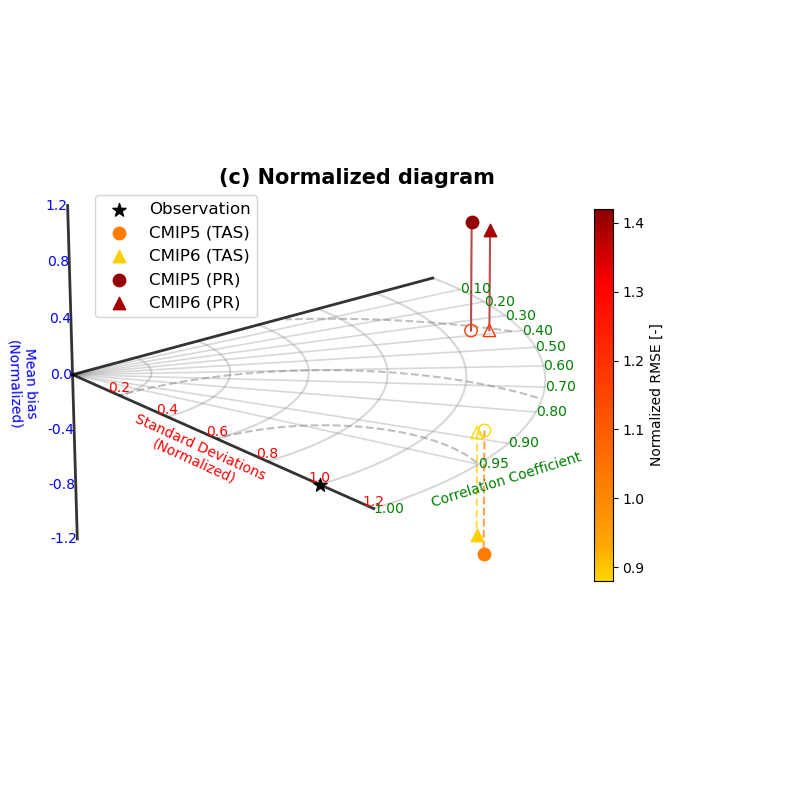

In [12]:
# Modify the 3D Taylor Diagram to add vertical x, y, and z-axis lines for Standard Deviation and Mean Bias passing through the origin
import matplotlib.colors as mcolors

fname = "./fig/Seo_diagram_norm.png"
title = "(c) Normalized diagram"
# Reference dataset standard deviation (observed data)
obs_std = 1.0

# Example model data: (stddev, correlation coefficient, mean bias)

ts_err5, ts_bias5, ts_corr5, ts_mstd5, ts_ostd5 = diagram_coef_norm(ts_c5_rmse, ts_c5_bias, ts_c5_corr, ts_c5_mstd, ts_c5_ostd)
ts_err6, ts_bias6, ts_corr6, ts_mstd6, ts_ostd6 = diagram_coef_norm(ts_c6_rmse, ts_c6_bias, ts_c6_corr, ts_c6_mstd, ts_c6_ostd)

pr_err5, pr_bias5, pr_corr5, pr_mstd5, pr_ostd5 = diagram_coef_norm(pr_c5_rmse, pr_c5_bias, pr_c5_corr, pr_c5_mstd, pr_c5_ostd)
pr_err6, pr_bias6, pr_corr6, pr_mstd6, pr_ostd6 = diagram_coef_norm(pr_c6_rmse, pr_c6_bias, pr_c6_corr, pr_c6_mstd, pr_c6_ostd)


model_data_with_bias5 = [(ts_mstd5, ts_corr5, ts_bias5) ,
                         (pr_mstd5, pr_corr5, pr_bias5) ]

model_data_with_bias6 = [(ts_mstd6, ts_corr6, ts_bias6) ,
                         (pr_mstd6, pr_corr6, pr_bias6) ]


cname5 = ['CMIP5 (TAS)', 'CMIP5 (PR)']
cname6 = ['CMIP6 (TAS)', 'CMIP6 (PR)']

err5 = []
for i, (stddev, corrcoef, mean_bias) in enumerate(model_data_with_bias5):
    aa = obs_std**2 + stddev**2 -2.*stddev*corrcoef + mean_bias*mean_bias
    err5.append(np.sqrt(aa))
err5 = [ts_err5, pr_err5]

err5_2d = []
for i, (stddev, corrcoef, mean_bias) in enumerate(model_data_with_bias5):
    # aa = obs_std**2 + stddev**2 -2.*stddev*corrcoef
    aa = err5[i]**2 - mean_bias*mean_bias
    err5_2d.append(np.sqrt(aa))
    
err6 = []
for i, (stddev, corrcoef, mean_bias) in enumerate(model_data_with_bias6):
    aa = obs_std**2 + stddev**2 -2.*stddev*corrcoef + mean_bias*mean_bias
    err6.append(np.sqrt(aa))
err6 = [ts_err6, pr_err6]

err6_2d = []
for i, (stddev, corrcoef, mean_bias) in enumerate(model_data_with_bias6):
    # aa = obs_std**2 + stddev**2 -2.*stddev*corrcoef
    aa = err6[i]**2 - mean_bias*mean_bias
    err6_2d.append(np.sqrt(aa))

err = []
err.append(err5)
err.append(err6)
error = np.array(err)

emax = 1.42
emin = 0.88

error_rang = ( emax - emin )
clist = [(0.0, 'gold'), (0.1, 'orange'), (0.2, 'darkorange'), (0.8, 'red'),(1, 'darkred')]
colors = mcolors.LinearSegmentedColormap.from_list("", clist)
# print(colors)

error_norm5 = ( np.array(err5) - emin ) / error_rang
error_norm6 = ( np.array(err6) - emin ) / error_rang

error_norm5_2d = ( np.array(err5_2d) - emin ) / error_rang
error_norm6_2d = ( np.array(err6_2d) - emin ) / error_rang

barcolors5 = []
for value in error_norm5:
    barcolors5.append(colors(value))

barcolors5_2d = []
for value in error_norm5_2d:
    barcolors5_2d.append(colors(value))

barcolors6 = []
for value in error_norm6:
    barcolors6.append(colors(value))

barcolors6_2d = []
for value in error_norm6_2d:
    barcolors6_2d.append(colors(value))
    

    
class TaylorDiagram3DWithVerticalAxes:
    """
    A 3D Taylor Diagram that positions the observation at correlation=0, std=1, mean bias=0,
    while adding cyan dashed lines from the origin to the correlation values, adds two spheres,
    replaces green radius lines with blue dashed radius lines, adds lines from observation to model points,
    and adds vertical x, y, and z-axis lines passing through the origin.
    """
    def __init__(self, ref_std, title=None, fig=None, label='Observation'):
        self.ref_std = ref_std  # Reference standard deviation
        self.xylim = 1.2
        self.zlim  = 1.2
        

        # Create 3D figure and axis
        self.fig = fig or plt.figure(figsize=(12, 10))
        self.ax = self.fig.add_subplot(111, projection='3d')
        self.ax.grid(False)
        self.ax.axis(False)
        self.ax.set_title(title,loc='center',fontsize=15,x=0.45,y=0.83, weight='bold')
        
        xlim = [0, self.xylim]
        ylim = [0, self.xylim]
        zlim = [self.zlim*-1, self.zlim]
        
        
        xl = np.linspace(np.array(xlim).min(), np.array(xlim).max(), int((np.array(xlim).max()-np.array(xlim).min())*5)+1)
        for x in xl[1:]:
            # self.ax.text(x, 0, 0, str(round(x,1)), horizontalalignment='center', verticalalignment='top', fontsize=10, color='green')
            self.ax.text(x, 0, 0, str(round(x,1)), horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='red')
            
        # zl = np.linspace(np.array(zlim).min(), np.array(zlim).max(), int((np.array(zlim).max()-np.array(zlim).min())*4)+1)
        zl = np.linspace(np.array(zlim).min(), np.array(zlim).max(), 7)
        for z in zl:
            self.ax.text(0, 0, z, str(round(z,1)), horizontalalignment='right', verticalalignment='center', fontsize=10, color='blue')
            
        # Set the azimuth and elevation angles
        self.ax.view_init(azim=-40, elev=20)
        self.ax.text(0, np.array(ylim).max()*(-0.13), 0.03, 'Mean bias\n(Normalized)', (0, 0, 1), fontsize=10, color='blue', verticalalignment='center', horizontalalignment='center')
        self.ax.text(np.array(xlim).max()*0.5, np.array(ylim).max()*-0.05, -0.07, 'Standard Deviations\n(Normalized)', (1, 0, 0), fontsize=10, color='red', verticalalignment='center', horizontalalignment='center')
        self.ax.text(np.array(xlim).max()*1.05, np.array(ylim).max()*0.3, 0, 'Correlation Coefficient', (0, 1, 0), fontsize=10, color='green', verticalalignment='center', horizontalalignment='center')
        
        # Set axis limits
        self.ax.set_xlim(0, self.xylim)  # x-axis from 0 to 2
        self.ax.set_ylim(0, self.xylim)  # y-axis from 0 to 2
        self.ax.set_zlim(self.zlim*-1, self.zlim)  # z-axis range for mean bias

        # Plot observation point at (1, 0, 0), where correlation=0, std=1, mean bias=0
        self.ax.scatter(1, 0, 0, color='black', marker='*', s=100, label=label)

        # Store observation point coordinates
        self.obs_point = (1, 0, 0)

    def add_model(self, stddev, corrcoef, mean_bias, label=None, marker='o', color='r'):
        """
        Add a model point to the 3D Taylor diagram.
        :param stddev: Standard deviation of the model.
        :param corrcoef: Correlation coefficient of the model.
        :param mean_bias: Mean bias of the model (plotted on the z-axis).
        :param label: Label for the model.
        :param marker: Marker style for the model point.
        :param color: Color of the marker.
        """
        # Convert correlation coefficient to an angle (theta)
        theta = np.arccos(corrcoef)
        x = stddev * np.cos(theta)  # Standard deviation component in x-axis
        y = stddev * np.sin(theta)  # Standard deviation component in y-axis

        # Plot the model point in 3D space (x = standard deviation, y = correlation angle, z = mean bias)
        self.ax.scatter(x, y, mean_bias, marker=marker, color=color, s=80, label=label)

        # Plot line from observation point to model point
        linestyle = '--' if mean_bias < 0 else '-'
        self.ax.plot([x, x], [y, y], [self.obs_point[2], mean_bias],
                     linestyle=linestyle, color=color, linewidth=1.5, alpha=0.7)

    def add_model2(self, stddev, corrcoef, mean_bias, marker='o', color='r'):
        """
        Add a model point to the 3D Taylor diagram.
        :param stddev: Standard deviation of the model.
        :param corrcoef: Correlation coefficient of the model.
        :param mean_bias: Mean bias of the model (plotted on the z-axis).
        :param label: Label for the model.
        :param marker: Marker style for the model point.
        :param color: Color of the marker.
        """
        # Convert correlation coefficient to an angle (theta)
        theta = np.arccos(corrcoef)
        x = stddev * np.cos(theta)  # Standard deviation component in x-axis
        y = stddev * np.sin(theta)  # Standard deviation component in y-axis

        # Plot the model point in 3D space (x = standard deviation, y = correlation angle, z = mean bias)
        self.ax.scatter(x, y, 0, marker=marker, color=color, facecolors='none', s=80)

        
    def add_contours_3d(self, levels=np.arange(0.0, 1.2, 0.2), **kwargs):
        """
        Add RMSE contour-like levels in 3D for visualization, on the x-y plane, with less dense spacing.
        """
        # Create a meshgrid for radial distance and angle
        rs, ts = np.meshgrid(np.linspace(0, 1.2 * self.ref_std, 30), np.linspace(0, np.pi / 2, 15))
        rms = np.sqrt(self.ref_std ** 1.2 + rs ** 1.2 - 1.2 * self.ref_std * rs * np.cos(ts))

        # Map RMSE onto the 3D plane by converting back to x and y components
        x = rs * np.cos(ts)
        y = rs * np.sin(ts)  # Positive y-axis
        z = np.zeros_like(rms)  # RMSE contours will be on the horizontal x-y plane (z = 0)

        # Plot wireframe for contour effect
        self.ax.plot_wireframe(x, y, z, color='green', alpha=0.3, rstride=50, cstride=50)
        
    def add_contours(self, levels, **kwargs):
        """
        Add RMSE contours to the Taylor diagram.
        :param levels: Levels for RMSE contours.
        """
        
        radii = levels
        for r in radii:
            theta = np.linspace(0, np.pi, 100)
            x = self.ref_std + r * np.cos(theta)
            x = np.where(x > 0, x, np.nan)
            xth = ( 1.2**2 + 1 - r **2 ) /2
            x = np.where(x < xth, x, np.nan)
            y = r * np.sin(theta)  # Positive y-axis
            z = np.zeros_like(x)  # RMSE contours will be on the horizontal x-y plane (z = 0)
            
            # Plot replaced auxiliary radius lines on the x-y plane
            self.ax.plot(x, y, z, linestyle='--', linewidth=1.5, alpha=0.5, **kwargs)

    def add_corr_coeff_labels(self):
        """
        Add correlation coefficient labels as green solid lines from origin to the correlation values.
        """
        # Define correlation coefficients (angles) and place labels with cyan dashed lines
        corr_coeffs = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0])
        for r in corr_coeffs:
            theta = np.arccos(r)
            # x = 2.0 * np.cos(theta)
            # y = 2.0 * np.sin(theta)  # Positive y component
            x = 1.2 * np.cos(theta)
            y = 1.2 * np.sin(theta)  # Positive y component
            
            self.ax.text(x, y, 0, f'{r:.2f}', horizontalalignment='left', verticalalignment='center', fontsize=10, color='green')

            # Add dashed cyan line from origin to the correlation value
            if r != 1.0:
                self.ax.plot([0, x], [0, y], [0, 0], linestyle='-', color='gray', linewidth=1.2, alpha=0.3)
                            

    def add_radius_lines(self):
        """
        Replace the auxiliary radius lines on the x-y plane that match the standard deviation axis with blue dashed lines.
        """
        # Define radii for auxiliary lines
        radii = np.array([0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
        for r in radii:
            theta = np.linspace(0, np.pi / 2, 100)
            x = r * np.cos(theta)
            y = r * np.sin(theta)

            # Plot replaced auxiliary radius lines on the x-y plane
            self.ax.plot(x, y, np.zeros_like(x), linestyle='-', color='gray', linewidth=1.5, alpha=0.3)
            
        

    def add_spheres(self):
        """
        Add two spheres centered at the observation point (1, 0, 0), with radii 0.5 and 0.25.
        """
        # Sphere with radius 0.5
        u = np.linspace(0, 1.2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        
        # Sphere with radius
        rads = np.array([0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
        
        for ri,r in enumerate(rads):
            x = 1 + r * np.outer(np.cos(u), np.sin(v))
            y = r * np.outer(np.sin(u), np.sin(v))
            y = np.where(y > 0, y, np.nan)
            z = r * np.outer(np.ones(np.size(u)), np.cos(v))
            self.ax.plot_surface(x, y, z, color='powderblue', alpha=0.1, rstride=1, cstride=1)

    def add_vertical_axes(self):
        """
        Add vertical x, y, and z-axis lines passing through the origin of the Taylor diagram.
        """
        # Plot vertical x-axis line passing through the origin
        self.ax.plot([0, self.xylim], [0, 0], [0, 0], linestyle='-', color='black', linewidth=2, alpha=0.8)

        # Plot vertical y-axis line passing through the origin
        self.ax.plot([0, 0], [0, self.xylim], [0, 0], linestyle='-', color='black', linewidth=2, alpha=0.8)

        # Plot vertical z-axis line passing through the origin
        self.ax.plot([0, 0], [0, 0], [self.zlim*-1, self.zlim], linestyle='-', color='black', linewidth=2, alpha=0.8)
        
        

# Create the 3D Taylor diagram
td_3d_vertical_axes = TaylorDiagram3DWithVerticalAxes(ref_std=obs_std,title=title)

# Plot the models on the diagram

stddev, corrcoef, mean_bias = model_data_with_bias5[0]
td_3d_vertical_axes.add_model(stddev, corrcoef, mean_bias, label='{}'.format(cname5[0]), marker='o', color=barcolors5[0])
td_3d_vertical_axes.add_model2(stddev, corrcoef, mean_bias, marker='o', color=barcolors5_2d[0])

stddev, corrcoef, mean_bias = model_data_with_bias6[0]
td_3d_vertical_axes.add_model(stddev, corrcoef, mean_bias, label='{}'.format(cname6[0]), marker='^', color=barcolors6[0])
td_3d_vertical_axes.add_model2(stddev, corrcoef, mean_bias, marker='^', color=barcolors6_2d[0])

stddev, corrcoef, mean_bias = model_data_with_bias5[1]
td_3d_vertical_axes.add_model(stddev, corrcoef, mean_bias, label='{}'.format(cname5[1]), marker='o', color=barcolors5[1])
td_3d_vertical_axes.add_model2(stddev, corrcoef, mean_bias, marker='o', color=barcolors5_2d[1])

stddev, corrcoef, mean_bias = model_data_with_bias6[1]
td_3d_vertical_axes.add_model(stddev, corrcoef, mean_bias, label='{}'.format(cname6[1]), marker='^', color=barcolors6[1])
td_3d_vertical_axes.add_model2(stddev, corrcoef, mean_bias, marker='^', color=barcolors6_2d[1])

# Add RMSE contours in green
td_3d_vertical_axes.add_contours(levels=np.arange(0.0, 2.0, 0.4), color='gray')

# Add correlation coefficient labels and cyan dashed lines
td_3d_vertical_axes.add_corr_coeff_labels()

# Replace the auxiliary radius lines on the x-y plane with blue dashed lines
td_3d_vertical_axes.add_radius_lines()

# Add the vertical x, y, and z-axis lines passing through the origin
td_3d_vertical_axes.add_vertical_axes()

# Show plot with legend
td_3d_vertical_axes.ax.legend(loc='upper left', bbox_to_anchor=(0.1, 0.77), fontsize=12)


from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
# norm = Normalize(vmin=error.min(), vmax=error.max())
norm = Normalize(vmin=emin, vmax=emax)
colormapping = ScalarMappable(norm=norm, cmap=colors)
cbar = plt.colorbar(colormapping, ax=plt.gca(), orientation='vertical', fraction=0.02, pad=-0.2)

cbar.set_label('Normalized RMSE [-]')

# plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

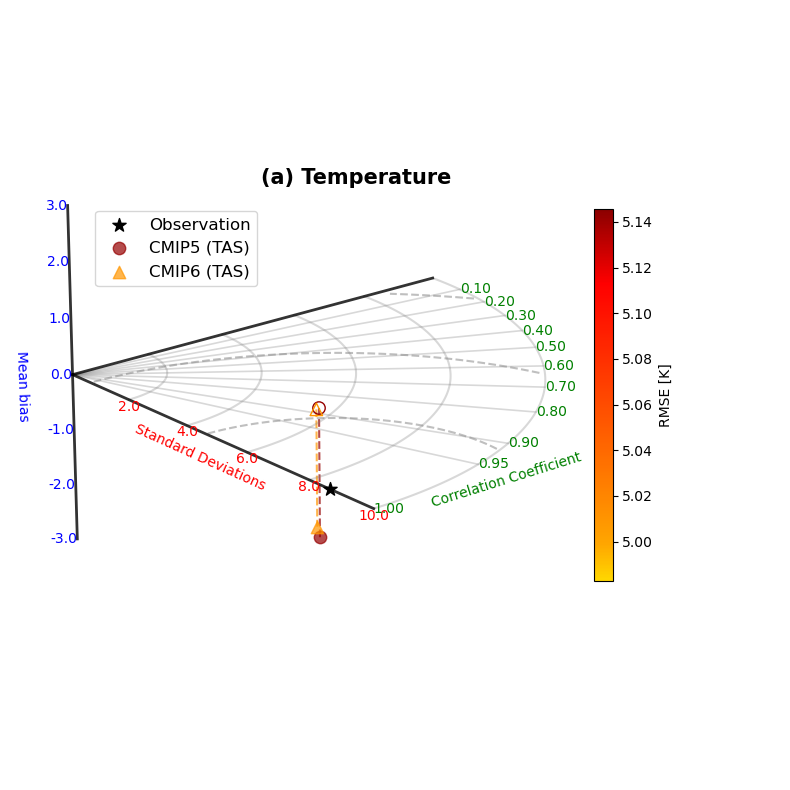

In [13]:
# Modify the 3D Taylor Diagram to add vertical x, y, and z-axis lines for Standard Deviation and Mean Bias passing through the origin
import matplotlib.colors as mcolors

fname = "./fig/Seo_diagram_tas.png"
title = "(a) Temperature"


# Example model data: (stddev, correlation coefficient, mean bias)
ts_err5, ts_bias5, ts_corr5, ts_mstd5, ts_ostd5 = diagram_coef(ts_c5_rmse, ts_c5_bias, ts_c5_corr, ts_c5_mstd, ts_c5_ostd)
ts_err6, ts_bias6, ts_corr6, ts_mstd6, ts_ostd6 = diagram_coef(ts_c6_rmse, ts_c6_bias, ts_c6_corr, ts_c6_mstd, ts_c6_ostd)

# Reference dataset standard deviation (observed data)
obs_std = ts_ostd5

model_data_with_bias5 = [(ts_mstd5, ts_corr5, ts_bias5) ]
model_data_with_bias6 = [(ts_mstd6, ts_corr6, ts_bias6) ]

# cmip5_name = ['CMIP5 (TAS)', 'CMIP5 (PR)']
# cmip6_name = ['CMIP6 (TAS)', 'CMIP6 (PR)']
cname5 = ['CMIP5 (TAS)']
cname6 = ['CMIP6 (TAS)']

err5 = []
for i, (stddev, corrcoef, mean_bias) in enumerate(model_data_with_bias5):
    aa = obs_std**2 + stddev**2 -2.*stddev*obs_std*corrcoef + mean_bias*mean_bias
    err5.append(np.sqrt(aa))
err5 = [ts_err5]

err6 = []
for i, (stddev, corrcoef, mean_bias) in enumerate(model_data_with_bias6):
    aa = obs_std**2 + stddev**2 -2.*stddev*obs_std*corrcoef + mean_bias*mean_bias
    err6.append(np.sqrt(aa))
err6 = [ts_err6]    

err = []
err.append(err5)
err.append(err6)
error = np.array(err)

emax = 5.15
emin = 4.95

error_rang = ( emax - emin )
clist = [(0.0, 'gold'), (0.1, 'orange'), (0.2, 'darkorange'), (0.8, 'red'),(1, 'darkred')]
colors = mcolors.LinearSegmentedColormap.from_list("", clist)

error_norm5 = ( np.array(err5) - emin ) / error_rang
error_norm6 = ( np.array(err6) - emin ) / error_rang
barcolors5 = []
for value in error_norm5:
    barcolors5.append(colors(value))

barcolors6 = []
for value in error_norm6:
    barcolors6.append(colors(value))

    
class TaylorDiagram3DWithVerticalAxes:
    """
    A 3D Taylor Diagram that positions the observation at correlation=0, std=1, mean bias=0,
    while adding cyan dashed lines from the origin to the correlation values, adds two spheres,
    replaces green radius lines with blue dashed radius lines, adds lines from observation to model points,
    and adds vertical x, y, and z-axis lines passing through the origin.
    """
    def __init__(self, ref_std, title=None, fig=None, label='Observation'):
        self.ref_std = ref_std  # Reference standard deviation
        self.xylim  = 10.0
        self.zlim  = 3.0

        # Create 3D figure and axis
        self.fig = fig or plt.figure(figsize=(12, 10))
        self.ax = self.fig.add_subplot(111, projection='3d')
        self.ax.grid(False)
        self.ax.axis(False)
        self.ax.set_title(title,loc='center',fontsize=15,x=0.45,y=0.83, weight='bold')
        
        xlim = [0, self.xylim]
        ylim = [0, self.xylim]
        zlim = [self.zlim*-1, self.zlim]
        
        xl = np.linspace(np.array(xlim).min(), np.array(xlim).max(), 6)
        for x in xl[1:]:
            self.ax.text(x, 0, 0, str(round(x,1)), horizontalalignment='center', verticalalignment='top', fontsize=10, color='red')
            
        zl = np.linspace(np.array(zlim).min(), np.array(zlim).max(), 7)
        for z in zl:
            self.ax.text(0, 0, z, str(round(z,1)), horizontalalignment='right', verticalalignment='center', fontsize=10, color='blue')
            
        # Set the azimuth and elevation angles
        self.ax.view_init(azim=-40, elev=20)
        self.ax.text(0, np.array(ylim).max()*(-0.13), 0.03, 'Mean bias', (0, 0, 1), fontsize=10, color='blue', verticalalignment='center', horizontalalignment='center')
        self.ax.text(np.array(xlim).max()*0.55, np.array(ylim).max()*-0.08, -0.05, 'Standard Deviations', (1, 0, 0), fontsize=10, color='red', verticalalignment='center', horizontalalignment='center')
        self.ax.text(np.array(xlim).max()*1.05, np.array(ylim).max()*0.3, 0, 'Correlation Coefficient', (0, 1, 0), fontsize=10, color='green', verticalalignment='center', horizontalalignment='center')
        
        # Set axis limits
        self.ax.set_xlim(0, self.xylim)  # x-axis from 0 to 2
        self.ax.set_ylim(0, self.xylim)  # y-axis from 0 to 2
        self.ax.set_zlim(self.zlim*-1, self.zlim)  # z-axis range for mean bias

        # Plot observation point at (1, 0, 0), where correlation=0, std=1, mean bias=0
        self.ax.scatter(ref_std, 0, 0, color='black', marker='*', s=100, label=label)

        # Store observation point coordinates
        self.obs_point = (ref_std, 0, 0)

    def add_model(self, stddev, corrcoef, mean_bias, label=None, marker='o', color='r'):
        """
        Add a model point to the 3D Taylor diagram.
        :param stddev: Standard deviation of the model.
        :param corrcoef: Correlation coefficient of the model.
        :param mean_bias: Mean bias of the model (plotted on the z-axis).
        :param label: Label for the model.
        :param marker: Marker style for the model point.
        :param color: Color of the marker.
        """
        # Convert correlation coefficient to an angle (theta)
        theta = np.arccos(corrcoef)
        x = stddev * np.cos(theta)  # Standard deviation component in x-axis
        y = stddev * np.sin(theta)  # Standard deviation component in y-axis

        # Plot the model point in 3D space (x = standard deviation, y = correlation angle, z = mean bias)
        self.ax.scatter(x, y, mean_bias, marker=marker, color=color, s=80, label=label, alpha=0.7)

        # Plot line from observation point to model point
        linestyle = '--' if mean_bias < 0 else '-'
        self.ax.plot([x, x], [y, y], [self.obs_point[2], mean_bias],
                     linestyle=linestyle, color=color, linewidth=1.5, alpha=0.7)

    def add_model2(self, stddev, corrcoef, mean_bias, marker='o', color='r'):
        """
        Add a model point to the 3D Taylor diagram.
        :param stddev: Standard deviation of the model.
        :param corrcoef: Correlation coefficient of the model.
        :param mean_bias: Mean bias of the model (plotted on the z-axis).
        :param label: Label for the model.
        :param marker: Marker style for the model point.
        :param color: Color of the marker.
        """
        # Convert correlation coefficient to an angle (theta)
        theta = np.arccos(corrcoef)
        x = stddev * np.cos(theta)  # Standard deviation component in x-axis
        y = stddev * np.sin(theta)  # Standard deviation component in y-axis

        # Plot the model point in 3D space (x = standard deviation, y = correlation angle, z = mean bias)
        self.ax.scatter(x, y, 0, marker=marker, color=color, facecolors='none', s=80)

        
    def add_contours_3d(self, levels=np.arange(0.0, 1.2, 0.2), **kwargs):
        """
        Add RMSE contour-like levels in 3D for visualization, on the x-y plane, with less dense spacing.
        """
        # Create a meshgrid for radial distance and angle
        rs, ts = np.meshgrid(np.linspace(0, self.xylim * self.ref_std, 30), np.linspace(0, np.pi / 2, 15))
        rms = np.sqrt(self.ref_std ** self.xylim + rs ** self.xylim - self.xylim * self.ref_std * rs * np.cos(ts))

        # Map RMSE onto the 3D plane by converting back to x and y components
        x = rs * np.cos(ts)
        y = rs * np.sin(ts)  # Positive y-axis
        z = np.zeros_like(rms)  # RMSE contours will be on the horizontal x-y plane (z = 0)

        # Plot wireframe for contour effect
        self.ax.plot_wireframe(x, y, z, color='green', alpha=0.3, rstride=50, cstride=50)
        
    def add_contours(self, levels, **kwargs):
        """
        Add RMSE contours to the Taylor diagram.
        :param levels: Levels for RMSE contours.
        """
        
        radii = levels
        for r in radii:
            theta = np.linspace(0, np.pi, 100)
            x = self.ref_std + r * np.cos(theta)
            x = np.where(x > 0, x, np.nan)
            xth = ( self.xylim**2 + self.ref_std**2 - r **2 ) / ( 2*self.ref_std )
            x = np.where(x < xth, x, np.nan)
            y = r * np.sin(theta)  # Positive y-axis
            z = np.zeros_like(x)  # RMSE contours will be on the horizontal x-y plane (z = 0)
            
            # Plot replaced auxiliary radius lines on the x-y plane
            self.ax.plot(x, y, z, linestyle='--', linewidth=1.5, alpha=0.5, **kwargs)
    


    def add_corr_coeff_labels(self):
        """
        Add correlation coefficient labels as green solid lines from origin to the correlation values.
        """
        # Define correlation coefficients (angles) and place labels with cyan dashed lines
        corr_coeffs = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0])
        for r in corr_coeffs:
            theta = np.arccos(r)
            x = self.xylim * np.cos(theta)
            y = self.xylim * np.sin(theta)  # Positive y component
            
            self.ax.text(x, y, 0, f'{r:.2f}', horizontalalignment='left', verticalalignment='center', fontsize=10, color='green')

            # Add dashed cyan line from origin to the correlation value
            if r != 1.0:
                self.ax.plot([0, x], [0, y], [0, 0], linestyle='-', color='gray', linewidth=1.2, alpha=0.3)
                            

    def add_radius_lines(self, levels):
        """
        Replace the auxiliary radius lines on the x-y plane that match the standard deviation axis with blue dashed lines.
        """
        # Define radii for auxiliary lines
        # radii = np.array([0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0])
        radii = levels
        for r in radii:
            theta = np.linspace(0, np.pi / 2, 100)
            x = r * np.cos(theta)
            y = r * np.sin(theta)

            # Plot replaced auxiliary radius lines on the x-y plane
            self.ax.plot(x, y, np.zeros_like(x), linestyle='-', color='gray', linewidth=1.5, alpha=0.3)
            
        

    def add_spheres(self):
        """
        Add two spheres centered at the observation point (1, 0, 0), with radii 0.5 and 0.25.
        """
        # Sphere with radius 0.5
        u = np.linspace(0, self.xylim * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        
        # Sphere with radius
        rads = levels
        
        for ri,r in enumerate(rads):
            x = 1 + r * np.outer(np.cos(u), np.sin(v))
            y = r * np.outer(np.sin(u), np.sin(v))
            y = np.where(y > 0, y, np.nan)
            z = r * np.outer(np.ones(np.size(u)), np.cos(v))
            self.ax.plot_surface(x, y, z, color='powderblue', alpha=0.1, rstride=1, cstride=1)

    def add_vertical_axes(self):
        """
        Add vertical x, y, and z-axis lines passing through the origin of the Taylor diagram.
        """
        # Plot vertical x-axis line passing through the origin
        self.ax.plot([0, self.xylim], [0, 0], [0, 0], linestyle='-', color='black', linewidth=2, alpha=0.8)

        # Plot vertical y-axis line passing through the origin
        self.ax.plot([0, 0], [0, self.xylim], [0, 0], linestyle='-', color='black', linewidth=2, alpha=0.8)

        # Plot vertical z-axis line passing through the origin
        self.ax.plot([0, 0], [0, 0], [self.zlim*-1, self.zlim], linestyle='-', color='black', linewidth=2, alpha=0.8)
        
        

# Create the 3D Taylor diagram
td_3d_vertical_axes = TaylorDiagram3DWithVerticalAxes(ref_std=obs_std,title=title)

stddev, corrcoef, mean_bias = model_data_with_bias5[0]
td_3d_vertical_axes.add_model(stddev, corrcoef, mean_bias, label='{}'.format(cname5[0]), marker='o', color=barcolors5[0])
td_3d_vertical_axes.add_model2(stddev, corrcoef, mean_bias, marker='o', color=barcolors5[0])

stddev, corrcoef, mean_bias = model_data_with_bias6[0]
td_3d_vertical_axes.add_model(stddev, corrcoef, mean_bias, label='{}'.format(cname6[0]), marker='^', color=barcolors6[0])
td_3d_vertical_axes.add_model2(stddev, corrcoef, mean_bias, marker='^', color=barcolors6[0])


# Add RMSE contours in green
td_3d_vertical_axes.add_contours(levels=np.arange(0.0, 20.0, 4), color='gray')

# Add correlation coefficient labels and cyan dashed lines
td_3d_vertical_axes.add_corr_coeff_labels()

# Replace the auxiliary radius lines on the x-y plane with blue dashed lines
td_3d_vertical_axes.add_radius_lines(levels=np.arange(0.0, 11.0, 2.))

# Add the two spheres around the observation point
# td_3d_vertical_axes.add_spheres()

# Add the vertical x, y, and z-axis lines passing through the origin
td_3d_vertical_axes.add_vertical_axes()

# Show plot with legend
td_3d_vertical_axes.ax.legend(loc='upper left', bbox_to_anchor=(0.1, 0.75), fontsize=12)


from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
norm = Normalize(vmin=error.min(), vmax=error.max())
colormapping = ScalarMappable(norm=norm, cmap=colors)
cbar = plt.colorbar(colormapping, ax=plt.gca(), orientation='vertical', fraction=0.02, pad=-0.2)

cbar.set_label('RMSE [K]')

# plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

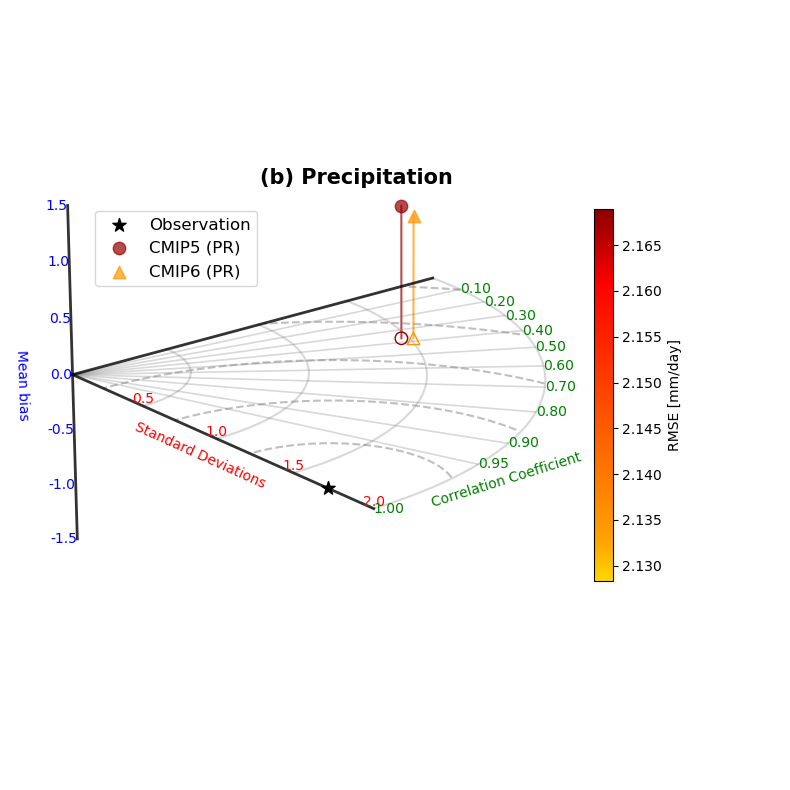

In [14]:
# Modify the 3D Taylor Diagram to add vertical x, y, and z-axis lines for Standard Deviation and Mean Bias passing through the origin
import matplotlib.colors as mcolors

fname = "./fig/Seo_diagram_pr.png"
title = "(b) Precipitation"
# Reference dataset standard deviation (observed data)
obs_std = area_avg_weight(pr_c5_ostd,'lon','lat').values

# Example model data: (stddev, correlation coefficient, mean bias)
pr_err5, pr_bias5, pr_corr5, pr_mstd5, pr_ostd5 = diagram_coef(pr_c5_rmse, pr_c5_bias, pr_c5_corr, pr_c5_mstd, pr_c5_ostd)
pr_err6, pr_bias6, pr_corr6, pr_mstd6, pr_ostd6 = diagram_coef(pr_c6_rmse, pr_c6_bias, pr_c6_corr, pr_c6_mstd, pr_c6_ostd)

# Reference dataset standard deviation (observed data)
obs_std = pr_ostd5

model_data_with_bias5 = [(pr_mstd5, pr_corr5, pr_bias5) ]
model_data_with_bias6 = [(pr_mstd6, pr_corr6, pr_bias6) ]


cname5 = ['CMIP5 (PR)']
cname6 = ['CMIP6 (PR)']

err5 = []
for i, (stddev, corrcoef, mean_bias) in enumerate(model_data_with_bias5):
    aa = obs_std**2 + stddev**2 -2.*stddev*obs_std*corrcoef + mean_bias*mean_bias
    err5.append(np.sqrt(aa))
err5 = [pr_err5]

err6 = []
for i, (stddev, corrcoef, mean_bias) in enumerate(model_data_with_bias6):
    aa = obs_std**2 + stddev**2 -2.*stddev*obs_std*corrcoef + mean_bias*mean_bias
    err6.append(np.sqrt(aa))
err6 = [pr_err6]

err = []
err.append(err5)
err.append(err6)
error = np.array(err)

emax = 2.17
emin = 2.12

error_rang = ( emax - emin )
clist = [(0.0, 'gold'), (0.1, 'orange'), (0.2, 'darkorange'), (0.8, 'red'),(1, 'darkred')]
colors = mcolors.LinearSegmentedColormap.from_list("", clist)

error_norm5 = ( np.array(err5) - emin ) / error_rang
error_norm6 = ( np.array(err6) - emin ) / error_rang
barcolors5 = []
for value in error_norm5:
    barcolors5.append(colors(value))

barcolors6 = []
for value in error_norm6:
    barcolors6.append(colors(value))

    
class TaylorDiagram3DWithVerticalAxes:
    """
    A 3D Taylor Diagram that positions the observation at correlation=0, std=1, mean bias=0,
    while adding cyan dashed lines from the origin to the correlation values, adds two spheres,
    replaces green radius lines with blue dashed radius lines, adds lines from observation to model points,
    and adds vertical x, y, and z-axis lines passing through the origin.
    """
    def __init__(self, ref_std, title=None, fig=None, label='Observation'):
        self.ref_std = ref_std  # Reference standard deviation
        self.xylim  = 2.0
        self.zlim  = 1.5

        # Create 3D figure and axis
        self.fig = fig or plt.figure(figsize=(12, 10))
        self.ax = self.fig.add_subplot(111, projection='3d')
        self.ax.grid(False)
        self.ax.axis(False)
        self.ax.set_title(title,loc='center',fontsize=15,x=0.45,y=0.83, weight='bold')
        
        xlim = [0, self.xylim]
        ylim = [0, self.xylim]
        zlim = [self.zlim*-1, self.zlim]
        
        xl = np.linspace(np.array(xlim).min(), np.array(xlim).max(), 5)
        for x in xl[1:]:
            self.ax.text(x, 0, 0, str(round(x,1)), horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='red')
            
        zl = np.linspace(np.array(zlim).min(), np.array(zlim).max(), 7)
        for z in zl:
            self.ax.text(0, 0, z, str(round(z,1)), horizontalalignment='right', verticalalignment='center', fontsize=10, color='blue')
            
        # Set the azimuth and elevation angles
        self.ax.view_init(azim=-40, elev=20)
        self.ax.text(0, np.array(ylim).max()*(-0.13), 0.03, 'Mean bias', (0, 0, 1), fontsize=10, color='blue', verticalalignment='center', horizontalalignment='center')
        self.ax.text(np.array(xlim).max()*0.55, np.array(ylim).max()*-0.08, -0.01, 'Standard Deviations', (1, 0, 0), fontsize=10, color='red', verticalalignment='center', horizontalalignment='center')
        self.ax.text(np.array(xlim).max()*1.05, np.array(ylim).max()*0.3, 0, 'Correlation Coefficient', (0, 1, 0), fontsize=10, color='green', verticalalignment='center', horizontalalignment='center')
        
        # Set axis limits
        self.ax.set_xlim(0, self.xylim)  # x-axis from 0 to 2
        self.ax.set_ylim(0, self.xylim)  # y-axis from 0 to 2
        self.ax.set_zlim(self.zlim*-1, self.zlim)  # z-axis range for mean bias

        # Plot observation point at (1, 0, 0), where correlation=0, std=1, mean bias=0
        self.ax.scatter(ref_std, 0, 0, color='black', marker='*', s=100, label=label)

        # Store observation point coordinates
        self.obs_point = (ref_std, 0, 0)

    def add_model(self, stddev, corrcoef, mean_bias, label=None, marker='o', color='r'):
        """
        Add a model point to the 3D Taylor diagram.
        :param stddev: Standard deviation of the model.
        :param corrcoef: Correlation coefficient of the model.
        :param mean_bias: Mean bias of the model (plotted on the z-axis).
        :param label: Label for the model.
        :param marker: Marker style for the model point.
        :param color: Color of the marker.
        """
        # Convert correlation coefficient to an angle (theta)
        theta = np.arccos(corrcoef)
        x = stddev * np.cos(theta)  # Standard deviation component in x-axis
        y = stddev * np.sin(theta)  # Standard deviation component in y-axis

        # Plot the model point in 3D space (x = standard deviation, y = correlation angle, z = mean bias)
        self.ax.scatter(x, y, mean_bias, marker=marker, color=color, s=80, label=label, alpha=0.7)

        # Plot line from observation point to model point
        linestyle = '--' if mean_bias < 0 else '-'
        self.ax.plot([x, x], [y, y], [self.obs_point[2], mean_bias],
                     linestyle=linestyle, color=color, linewidth=1.5, alpha=0.7)

    def add_model2(self, stddev, corrcoef, mean_bias, marker='o', color='r'):
        """
        Add a model point to the 3D Taylor diagram.
        :param stddev: Standard deviation of the model.
        :param corrcoef: Correlation coefficient of the model.
        :param mean_bias: Mean bias of the model (plotted on the z-axis).
        :param label: Label for the model.
        :param marker: Marker style for the model point.
        :param color: Color of the marker.
        """
        # Convert correlation coefficient to an angle (theta)
        theta = np.arccos(corrcoef)
        x = stddev * np.cos(theta)  # Standard deviation component in x-axis
        y = stddev * np.sin(theta)  # Standard deviation component in y-axis

        # Plot the model point in 3D space (x = standard deviation, y = correlation angle, z = mean bias)
        self.ax.scatter(x, y, 0, marker=marker, color=color, facecolors='none', s=80)

        
    def add_contours_3d(self, levels=np.arange(0.0, 1.2, 0.2), **kwargs):
        """
        Add RMSE contour-like levels in 3D for visualization, on the x-y plane, with less dense spacing.
        """
        # Create a meshgrid for radial distance and angle
        rs, ts = np.meshgrid(np.linspace(0, self.xylim * self.ref_std, 30), np.linspace(0, np.pi / 2, 15))
        rms = np.sqrt(self.ref_std ** self.xylim + rs ** self.xylim - self.xylim * self.ref_std * rs * np.cos(ts))

        # Map RMSE onto the 3D plane by converting back to x and y components
        x = rs * np.cos(ts)
        y = rs * np.sin(ts)  # Positive y-axis
        z = np.zeros_like(rms)  # RMSE contours will be on the horizontal x-y plane (z = 0)

        # Plot wireframe for contour effect
        self.ax.plot_wireframe(x, y, z, color='green', alpha=0.3, rstride=50, cstride=50)
        
    def add_contours(self, levels, **kwargs):
        """
        Add RMSE contours to the Taylor diagram.
        :param levels: Levels for RMSE contours.
        """
        
        radii = levels
        for r in radii:
            theta = np.linspace(0, np.pi, 100)
            x = self.ref_std + r * np.cos(theta)
            x = np.where(x > 0, x, np.nan)
            xth = ( self.xylim**2 + self.ref_std**2 - r **2 ) / ( 2*self.ref_std )
            x = np.where(x < xth, x, np.nan)
            y = r * np.sin(theta)  # Positive y-axis
            z = np.zeros_like(x)  # RMSE contours will be on the horizontal x-y plane (z = 0)
            
            # Plot replaced auxiliary radius lines on the x-y plane
            self.ax.plot(x, y, z, linestyle='--', linewidth=1.5, alpha=0.5, **kwargs)
    


    def add_corr_coeff_labels(self):
        """
        Add correlation coefficient labels as green solid lines from origin to the correlation values.
        """
        # Define correlation coefficients (angles) and place labels with cyan dashed lines
        corr_coeffs = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0])
        for r in corr_coeffs:
            theta = np.arccos(r)
            x = self.xylim * np.cos(theta)
            y = self.xylim * np.sin(theta)  # Positive y component
            
            self.ax.text(x, y, 0, f'{r:.2f}', horizontalalignment='left', verticalalignment='center', fontsize=10, color='green')

            # Add dashed cyan line from origin to the correlation value
            if r != 1.0:
                self.ax.plot([0, x], [0, y], [0, 0], linestyle='-', color='gray', linewidth=1.2, alpha=0.3)
                            

    def add_radius_lines(self, levels):
        """
        Replace the auxiliary radius lines on the x-y plane that match the standard deviation axis with blue dashed lines.
        """
        # Define radii for auxiliary lines
        radii = levels
        for r in radii:
            theta = np.linspace(0, np.pi / 2, 100)
            x = r * np.cos(theta)
            y = r * np.sin(theta)

            # Plot replaced auxiliary radius lines on the x-y plane
            self.ax.plot(x, y, np.zeros_like(x), linestyle='-', color='gray', linewidth=1.5, alpha=0.3)
            
        

    def add_spheres(self):
        """
        Add two spheres centered at the observation point (1, 0, 0), with radii 0.5 and 0.25.
        """
        # Sphere with radius 0.5
        u = np.linspace(0, self.xylim * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        
        # Sphere with radius
        rads = levels
        
        for ri,r in enumerate(rads):
            x = 1 + r * np.outer(np.cos(u), np.sin(v))
            y = r * np.outer(np.sin(u), np.sin(v))
            y = np.where(y > 0, y, np.nan)
            z = r * np.outer(np.ones(np.size(u)), np.cos(v))
            self.ax.plot_surface(x, y, z, color='powderblue', alpha=0.1, rstride=1, cstride=1)

    def add_vertical_axes(self):
        """
        Add vertical x, y, and z-axis lines passing through the origin of the Taylor diagram.
        """
        # Plot vertical x-axis line passing through the origin
        self.ax.plot([0, self.xylim], [0, 0], [0, 0], linestyle='-', color='black', linewidth=2, alpha=0.8)

        # Plot vertical y-axis line passing through the origin
        self.ax.plot([0, 0], [0, self.xylim], [0, 0], linestyle='-', color='black', linewidth=2, alpha=0.8)

        # Plot vertical z-axis line passing through the origin
        self.ax.plot([0, 0], [0, 0], [self.zlim*-1, self.zlim], linestyle='-', color='black', linewidth=2, alpha=0.8)
        
        

# Create the 3D Taylor diagram
td_3d_vertical_axes = TaylorDiagram3DWithVerticalAxes(ref_std=obs_std,title=title)

stddev, corrcoef, mean_bias = model_data_with_bias5[0]
td_3d_vertical_axes.add_model(stddev, corrcoef, mean_bias, label='{}'.format(cname5[0]), marker='o', color=barcolors5[0])
td_3d_vertical_axes.add_model2(stddev, corrcoef, mean_bias, marker='o', color=barcolors5[0])

stddev, corrcoef, mean_bias = model_data_with_bias6[0]
td_3d_vertical_axes.add_model(stddev, corrcoef, mean_bias, label='{}'.format(cname6[0]), marker='^', color=barcolors6[0])
td_3d_vertical_axes.add_model2(stddev, corrcoef, mean_bias, marker='^', color=barcolors6[0])

# Add RMSE contours in green
td_3d_vertical_axes.add_contours(levels=np.arange(0.0, 20.0, 0.5), color='gray')

# Add correlation coefficient labels and cyan dashed lines
td_3d_vertical_axes.add_corr_coeff_labels()

# Replace the auxiliary radius lines on the x-y plane with blue dashed lines
td_3d_vertical_axes.add_radius_lines(levels=np.arange(0.0, 2.2, 0.5))

# Add the two spheres around the observation point
# td_3d_vertical_axes.add_spheres()

# Add the vertical x, y, and z-axis lines passing through the origin
td_3d_vertical_axes.add_vertical_axes()

# Show plot with legend
td_3d_vertical_axes.ax.legend(loc='upper left', bbox_to_anchor=(0.1, 0.75), fontsize=12)


from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
norm = Normalize(vmin=error.min(), vmax=error.max())
colormapping = ScalarMappable(norm=norm, cmap=colors)
cbar = plt.colorbar(colormapping, ax=plt.gca(), orientation='vertical', fraction=0.02, pad=-0.2)

cbar.set_label('RMSE [mm/day]')

# plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

# Fig.2

In [15]:
cmip5_name = ['ACCESS1-0','CanESM2','CCSM4','CMCC-CM','CNRM-CM5',
              'GFDL-CM2.1','GISS-E2-H','INM-CM4-0','IPSL-CM5A-LR','MIROC5',
              'HadGEM2-AO','MPI-ESM-LR','MRI-ESM1','NorESM1-M']
cmip6_name = ['ACCESS-CM2','CanESM5','CESM2-WACCM','CMCC-CM2-HR4','CNRM-ESM2-1',
              'GFDL-CM4','GISS-E2-1-H','INM-CM5-0','IPSL-CM6A-LR','MIROC6',
              'HadGEM3-GC31-LL','MPI-ESM1-2-LR','MRI-ESM2-0','NorESM2-MM']
cname = ['A','C1','C2','C3','C4',
         'G1','G2','I1','I2','M1',
         'M2','M3','M4','N']

In [16]:
map_t = xr.DataArray(data = np.empty([2,3,len(cmip5_name),4,len(ot.lat),len(ot.lon)]) * np.nan, 
                    dims=["norm","mips","models","scores","lat","lon"],
                    coords = dict(norm=(["norm"], [x for x in range(2)]),
                                  mips=(["mips"], [x for x in range(3)]),
                                  models=(["models"], [x for x in range(len(cmip5_name))]),
                                  scores=(["scores"], [x for x in range(4)]),
                                  lat=(["lat"], ot.lat.values),
                                  lon=(["lon"], ot.lon.values),
                                 )
                   )
sig_t = xr.DataArray(data = np.empty([2,4,len(ot.lat),len(ot.lon)]) * np.nan,
                        dims=["norm","scores","lat","lon"],
                        coords = dict(norm=(["norm"], [x for x in range(2)]),
                                      scores=(["scores"], [x for x in range(4)]),
                                      lat=(["lat"], ot.lat.values),
                                      lon=(["lon"], ot.lon.values),
                                     )
                       )

map_t[0,0,:,0,:,:] = ts_c5_rmse * ts_c5_rmse
map_t[0,0,:,1,:,:] = ts_c5_bias * ts_c5_bias
map_t[0,0,:,2,:,:] = ( ts_c5_mstd - ts_c5_ostd )**2
map_t[0,0,:,3,:,:] = ( 2 * ts_c5_mstd * ts_c5_ostd ) * ( 1 - ts_c5_corr )
map_t[0,1,:,0,:,:] = ts_c6_rmse * ts_c6_rmse
map_t[0,1,:,1,:,:] = ts_c6_bias * ts_c6_bias
map_t[0,1,:,2,:,:] = ( ts_c6_mstd - ts_c6_ostd )**2
map_t[0,1,:,3,:,:] = ( 2 * ts_c6_mstd * ts_c6_ostd ) * ( 1 - ts_c6_corr )
map_t[0,2,:,:,:,:] = map_t[0,1,:,:,:,:] - map_t[0,0,:,:,:,:]

map_t[1,0,:,0,:,:] = ts_c5_rmse * ts_c5_rmse / (ts_c5_ostd**2)
map_t[1,0,:,1,:,:] = ts_c5_bias * ts_c5_bias / (ts_c5_ostd**2)
map_t[1,0,:,2,:,:] = ( (ts_c5_mstd/ts_c5_ostd) -1 )**2
map_t[1,0,:,3,:,:] = ( 2 * ts_c5_mstd/ts_c5_ostd ) * ( 1 - ts_c5_corr )
map_t[1,1,:,0,:,:] = ts_c6_rmse * ts_c6_rmse / (ts_c6_ostd**2)
map_t[1,1,:,1,:,:] = ts_c6_bias * ts_c6_bias / (ts_c6_ostd**2)
map_t[1,1,:,2,:,:] = ( (ts_c6_mstd/ts_c6_ostd) -1 )**2
map_t[1,1,:,3,:,:] = ( 2 * ts_c6_mstd/ts_c6_ostd ) * ( 1 - ts_c6_corr )
map_t[1,2,:,:,:,:] = map_t[1,1,:,:,:,:] - map_t[1,0,:,:,:,:]

sig_t[0,:,:,:] = stats.ttest_ind( map_t[0,0,:,:,:,:], map_t[0,1,:,:,:,:], axis=0, equal_var=False ).pvalue
sig_t[1,:,:,:] = stats.ttest_ind( map_t[1,0,:,:,:,:], map_t[1,1,:,:,:,:], axis=0, equal_var=False ).pvalue

In [17]:
map_p = xr.DataArray(data = np.empty([2,3,len(cmip5_name),4,len(ot.lat),len(ot.lon)]) * np.nan, 
                    dims=["norm","mips","models","scores","lat","lon"],
                    coords = dict(norm=(["norm"], [x for x in range(2)]),
                                  mips=(["mips"], [x for x in range(3)]),
                                  models=(["models"], [x for x in range(len(cmip5_name))]),
                                  scores=(["scores"], [x for x in range(4)]),
                                  lat=(["lat"], ot.lat.values),
                                  lon=(["lon"], ot.lon.values),
                                 )
                   )
sig_p = xr.DataArray(data = np.empty([2,4,len(ot.lat),len(ot.lon)]) * np.nan,
                        dims=["norm","scores","lat","lon"],
                        coords = dict(norm=(["norm"], [x for x in range(2)]),
                                      scores=(["scores"], [x for x in range(4)]),
                                      lat=(["lat"], ot.lat.values),
                                      lon=(["lon"], ot.lon.values),
                                     )
                       )

map_p[0,0,:,0,:,:] = pr_c5_rmse * pr_c5_rmse
map_p[0,0,:,1,:,:] = pr_c5_bias * pr_c5_bias
map_p[0,0,:,2,:,:] = ( pr_c5_mstd - pr_c5_ostd )**2
map_p[0,0,:,3,:,:] = ( 2 * pr_c5_mstd * pr_c5_ostd ) * ( 1 - pr_c5_corr )
map_p[0,1,:,0,:,:] = pr_c6_rmse * pr_c6_rmse
map_p[0,1,:,1,:,:] = pr_c6_bias * pr_c6_bias
map_p[0,1,:,2,:,:] = ( pr_c6_mstd - pr_c6_ostd )**2
map_p[0,1,:,3,:,:] = ( 2 * pr_c6_mstd * pr_c6_ostd ) * ( 1 - pr_c6_corr )
map_p[0,2,:,:,:,:] = map_p[0,1,:,:,:,:] - map_p[0,0,:,:,:,:]

map_p[1,0,:,0,:,:] = pr_c5_rmse * pr_c5_rmse / (pr_c5_ostd**2)
map_p[1,0,:,1,:,:] = pr_c5_bias * pr_c5_bias / (pr_c5_ostd**2)
map_p[1,0,:,2,:,:] = ( (pr_c5_mstd/pr_c5_ostd) -1 )**2
map_p[1,0,:,3,:,:] = ( 2 * pr_c5_mstd/pr_c5_ostd ) * ( 1 - pr_c5_corr )
map_p[1,1,:,0,:,:] = pr_c6_rmse * pr_c6_rmse / (pr_c6_ostd**2)
map_p[1,1,:,1,:,:] = pr_c6_bias * pr_c6_bias / (pr_c6_ostd**2)
map_p[1,1,:,2,:,:] = ( (pr_c6_mstd/pr_c6_ostd) -1 )**2
map_p[1,1,:,3,:,:] = ( 2 * pr_c6_mstd/pr_c6_ostd ) * ( 1 - pr_c6_corr )
map_p[1,2,:,:,:,:] = map_p[1,1,:,:,:,:] - map_p[1,0,:,:,:,:]

sig_p[0,:,:,:] = stats.ttest_ind( map_p[0,0,:,:,:,:], map_p[0,1,:,:,:,:], axis=0, equal_var=False ).pvalue
sig_p[1,:,:,:] = stats.ttest_ind( map_p[1,0,:,:,:,:], map_p[1,1,:,:,:,:], axis=0, equal_var=False ).pvalue

In [35]:
map1 = xr.DataArray(data = np.empty([2,3,len(cmip5_name),4,len(ot.lat),len(ot.lon)]) * np.nan, 
                    dims=["vars","mips","models","scores","lat","lon"],
                    coords = dict(vars=(["vars"], [x for x in range(2)]),
                                  mips=(["mips"], [x for x in range(3)]),
                                  models=(["models"], [x for x in range(len(cmip5_name))]),
                                  scores=(["scores"], [x for x in range(4)]),
                                  lat=(["lat"], ot.lat.values),
                                  lon=(["lon"], ot.lon.values),
                                 )
                   )
sig_map1 = xr.DataArray(data = np.empty([2,4,len(ot.lat),len(ot.lon)]) * np.nan,
                        dims=["vars","scores","lat","lon"],
                        coords = dict(vars=(["vars"], [x for x in range(2)]),
                                      scores=(["scores"], [x for x in range(4)]),
                                      lat=(["lat"], ot.lat.values),
                                      lon=(["lon"], ot.lon.values),
                                     )
                       )

map1[0,0,:,0,:,:] = ts_c5_rmse * ts_c5_rmse / (ts_c5_ostd**2)
map1[0,0,:,1,:,:] = ts_c5_bias * ts_c5_bias / (ts_c5_ostd**2)
map1[0,0,:,2,:,:] = ( (ts_c5_mstd/ts_c5_ostd) -1 )**2
map1[0,0,:,3,:,:] = ( 2 * ts_c5_mstd/ts_c5_ostd ) * ( 1 - ts_c5_corr )
map1[0,1,:,0,:,:] = ts_c6_rmse * ts_c6_rmse / (ts_c6_ostd**2)
map1[0,1,:,1,:,:] = ts_c6_bias * ts_c6_bias / (ts_c6_ostd**2)
map1[0,1,:,2,:,:] = ( (ts_c6_mstd/ts_c6_ostd) -1 )**2
map1[0,1,:,3,:,:] = ( 2 * ts_c6_mstd/ts_c6_ostd ) * ( 1 - ts_c6_corr )
map1[0,2,:,:,:,:] = map1[0,1,:,:,:,:] - map1[0,0,:,:,:,:]

map1[1,0,:,0,:,:] = pr_c5_rmse * pr_c5_rmse / (pr_c5_ostd**2)
map1[1,0,:,1,:,:] = pr_c5_bias * pr_c5_bias / (pr_c5_ostd**2)
map1[1,0,:,2,:,:] = ( (pr_c5_mstd/pr_c5_ostd) -1 )**2
map1[1,0,:,3,:,:] = ( 2 * pr_c5_mstd/pr_c5_ostd ) * ( 1 - pr_c5_corr )
map1[1,1,:,0,:,:] = pr_c6_rmse * pr_c6_rmse / (pr_c6_ostd**2)
map1[1,1,:,1,:,:] = pr_c6_bias * pr_c6_bias / (pr_c6_ostd**2)
map1[1,1,:,2,:,:] = ( (pr_c6_mstd/pr_c6_ostd) -1 )**2
map1[1,1,:,3,:,:] = ( 2 * pr_c6_mstd/pr_c6_ostd ) * ( 1 - pr_c6_corr )
map1[1,2,:,:,:,:] = map1[1,1,:,:,:,:] - map1[1,0,:,:,:,:]

sig_map1[0,:,:,:] = stats.ttest_ind( map1[0,0,:,:,:,:], map1[0,1,:,:,:,:], axis=0, equal_var=False ).pvalue
sig_map1[1,:,:,:] = stats.ttest_ind( map1[1,0,:,:,:,:], map1[1,1,:,:,:,:], axis=0, equal_var=False ).pvalue

In [36]:
map2 = xr.DataArray(data = np.empty([2,3,len(cmip5_name),4,len(ot.lat),len(ot.lon)]) * np.nan, 
                    dims=["vars","mips","models","scores","lat","lon"],
                    coords = dict(vars=(["vars"], [x for x in range(2)]),
                                  mips=(["mips"], [x for x in range(3)]),
                                  models=(["models"], [x for x in range(len(cmip5_name))]),
                                  scores=(["scores"], [x for x in range(4)]),
                                  lat=(["lat"], ot.lat.values),
                                  lon=(["lon"], ot.lon.values),
                                 )
                   )
sig_map2 = xr.DataArray(data = np.empty([2,4,len(ot.lat),len(ot.lon)]) * np.nan,
                        dims=["vars","scores","lat","lon"],
                        coords = dict(vars=(["vars"], [x for x in range(2)]),
                                      scores=(["scores"], [x for x in range(4)]),
                                      lat=(["lat"], ot.lat.values),
                                      lon=(["lon"], ot.lon.values),
                                     )
                       )

map2[0,0,:,0,:,:] = ts_c5_rmse * ts_c5_rmse
map2[0,0,:,1,:,:] = ts_c5_bias * ts_c5_bias
map2[0,0,:,2,:,:] = ( ts_c5_mstd - ts_c5_ostd )**2
map2[0,0,:,3,:,:] = ( 2 * ts_c5_mstd * ts_c5_ostd ) * ( 1 - ts_c5_corr )
map2[0,1,:,0,:,:] = ts_c6_rmse * ts_c6_rmse
map2[0,1,:,1,:,:] = ts_c6_bias * ts_c6_bias
map2[0,1,:,2,:,:] = ( ts_c6_mstd - ts_c6_ostd )**2
map2[0,1,:,3,:,:] = ( 2 * ts_c6_mstd * ts_c6_ostd ) * ( 1 - ts_c6_corr )
map2[0,2,:,:,:,:] = map2[0,1,:,:,:,:] - map2[0,0,:,:,:,:]

map2[1,0,:,0,:,:] = pr_c5_rmse * pr_c5_rmse
map2[1,0,:,1,:,:] = pr_c5_bias * pr_c5_bias
map2[1,0,:,2,:,:] = ( pr_c5_mstd - pr_c5_ostd )**2
map2[1,0,:,3,:,:] = ( 2 * pr_c5_mstd * pr_c5_ostd ) * ( 1 - pr_c5_corr )
map2[1,1,:,0,:,:] = pr_c6_rmse * pr_c6_rmse
map2[1,1,:,1,:,:] = pr_c6_bias * pr_c6_bias
map2[1,1,:,2,:,:] = ( pr_c6_mstd - pr_c6_ostd )**2
map2[1,1,:,3,:,:] = ( 2 * pr_c6_mstd * pr_c6_ostd ) * ( 1 - pr_c6_corr )
map2[1,2,:,:,:,:] = map2[1,1,:,:,:,:] - map2[1,0,:,:,:,:]

sig_map2[0,:,:,:] = stats.ttest_ind( map2[0,0,:,:,:,:], map2[0,1,:,:,:,:], axis=0, equal_var=False ).pvalue
sig_map2[1,:,:,:] = stats.ttest_ind( map2[1,0,:,:,:,:], map2[1,1,:,:,:,:], axis=0, equal_var=False ).pvalue

In [37]:
map12 = xr.DataArray(data = np.empty([2,2,len(cmip5_name),4,len(ot.lat),len(ot.lon)]) * np.nan, 
                    dims=["vars","mips","models","scores","lat","lon"],
                    coords = dict(vars=(["vars"], [x for x in range(2)]),
                                  mips=(["mips"], [x for x in range(2)]),
                                  models=(["models"], [x for x in range(len(cmip5_name))]),
                                  scores=(["scores"], [x for x in range(4)]),
                                  lat=(["lat"], ot.lat.values),
                                  lon=(["lon"], ot.lon.values),
                                 )
                   )

map12[0,0,:,:,:,:] = map1[0,1,:,:,:,:]
map12[0,1,:,:,:,:] = map1[0,1,:,:,:,:] - map1[0,0,:,:,:,:]
map12[1,0,:,:,:,:] = map1[1,1,:,:,:,:]
map12[1,1,:,:,:,:] = map1[1,1,:,:,:,:] - map1[1,0,:,:,:,:]


In [43]:
map3 = xr.DataArray(data = np.empty([2,3,4,len(ot.lat),len(ot.lon)]) * np.nan, 
                    dims=["vars","mips","scores","lat","lon"],
                    coords = dict(vars=(["vars"], [x for x in range(2)]),
                                  mips=(["mips"], [x for x in range(3)]),
                                  scores=(["scores"], [x for x in range(4)]),
                                  lat=(["lat"], ot.lat.values),
                                  lon=(["lon"], ot.lon.values),
                                 )
                   )

map3[0,0,0,:,:] = ts_c5_rmse_mme * ts_c5_rmse_mme / (ts_c5_ostd_mme**2)
map3[0,0,1,:,:] = ts_c5_bias_mme * ts_c5_bias_mme / (ts_c5_ostd_mme**2)
map3[0,0,2,:,:] = ( (ts_c5_mstd_mme/ts_c5_ostd_mme) -1 )**2
map3[0,0,3,:,:] = ( 2 * ts_c5_mstd_mme/ts_c5_ostd_mme ) * ( 1 - ts_c5_corr_mme )
map3[0,1,0,:,:] = ts_c6_rmse_mme * ts_c6_rmse_mme / (ts_c6_ostd_mme**2)
map3[0,1,1,:,:] = ts_c6_bias_mme * ts_c6_bias_mme / (ts_c6_ostd_mme**2)
map3[0,1,2,:,:] = ( (ts_c6_mstd_mme/ts_c6_ostd_mme) -1 )**2
map3[0,1,3,:,:] = ( 2 * ts_c6_mstd_mme/ts_c6_ostd_mme ) * ( 1 - ts_c6_corr_mme )
map3[0,2,:,:,:] = map3[0,1,:,:,:] - map3[0,0,:,:,:]

map3[1,0,0,:,:] = pr_c5_rmse_mme * pr_c5_rmse_mme / (pr_c5_ostd_mme**2)
map3[1,0,1,:,:] = pr_c5_bias_mme * pr_c5_bias_mme / (pr_c5_ostd_mme**2)
map3[1,0,2,:,:] = ( (pr_c5_mstd_mme/pr_c5_ostd_mme) -1 )**2
map3[1,0,3,:,:] = ( 2 * pr_c5_mstd_mme/pr_c5_ostd_mme ) * ( 1 - pr_c5_corr_mme )
map3[1,1,0,:,:] = pr_c6_rmse_mme * pr_c6_rmse_mme / (pr_c6_ostd_mme**2)
map3[1,1,1,:,:] = pr_c6_bias_mme * pr_c6_bias_mme / (pr_c6_ostd_mme**2)
map3[1,1,2,:,:] = ( (pr_c6_mstd_mme/pr_c6_ostd_mme) -1 )**2
map3[1,1,3,:,:] = ( 2 * pr_c6_mstd_mme/pr_c6_ostd_mme ) * ( 1 - pr_c6_corr_mme )
map3[1,2,:,:,:] = map3[1,1,:,:,:] - map3[1,0,:,:,:]

In [44]:
map4 = xr.DataArray(data = np.empty([2,3,4,len(ot.lat),len(ot.lon)]) * np.nan, 
                    dims=["vars","mips","scores","lat","lon"],
                    coords = dict(vars=(["vars"], [x for x in range(2)]),
                                  mips=(["mips"], [x for x in range(3)]),
                                  scores=(["scores"], [x for x in range(4)]),
                                  lat=(["lat"], ot.lat.values),
                                  lon=(["lon"], ot.lon.values),
                                 )
                   )

map4[0,0,0,:,:] = ts_c5_rmse_mme * ts_c5_rmse_mme
map4[0,0,1,:,:] = ts_c5_bias_mme * ts_c5_bias_mme
map4[0,0,2,:,:] = ( ts_c5_mstd_mme - ts_c5_ostd_mme )**2
map4[0,0,3,:,:] = ( 2 * ts_c5_mstd_mme * ts_c5_ostd_mme ) * ( 1 - ts_c5_corr_mme )
map4[0,1,0,:,:] = ts_c6_rmse_mme * ts_c6_rmse_mme
map4[0,1,1,:,:] = ts_c6_bias_mme * ts_c6_bias_mme
map4[0,1,2,:,:] = ( ts_c6_mstd_mme - ts_c6_ostd_mme )**2
map4[0,1,3,:,:] = ( 2 * ts_c6_mstd_mme * ts_c6_ostd_mme ) * ( 1 - ts_c6_corr_mme )
map4[0,2,:,:,:] = map4[0,1,:,:,:] - map4[0,0,:,:,:]

map4[1,0,0,:,:] = pr_c5_rmse_mme * pr_c5_rmse_mme
map4[1,0,1,:,:] = pr_c5_bias_mme * pr_c5_bias_mme
map4[1,0,2,:,:] = ( pr_c5_mstd_mme - pr_c5_ostd_mme )**2
map4[1,0,3,:,:] = ( 2 * pr_c5_mstd_mme * pr_c5_ostd_mme ) * ( 1 - pr_c5_corr_mme )
map4[1,1,0,:,:] = pr_c6_rmse_mme * pr_c6_rmse_mme
map4[1,1,1,:,:] = pr_c6_bias_mme * pr_c6_bias_mme
map4[1,1,2,:,:] = ( pr_c6_mstd_mme - pr_c6_ostd_mme )**2
map4[1,1,3,:,:] = ( 2 * pr_c6_mstd_mme * pr_c6_ostd_mme ) * ( 1 - pr_c6_corr_mme )
map4[1,2,:,:,:] = map4[1,1,:,:,:] - map4[1,0,:,:,:]

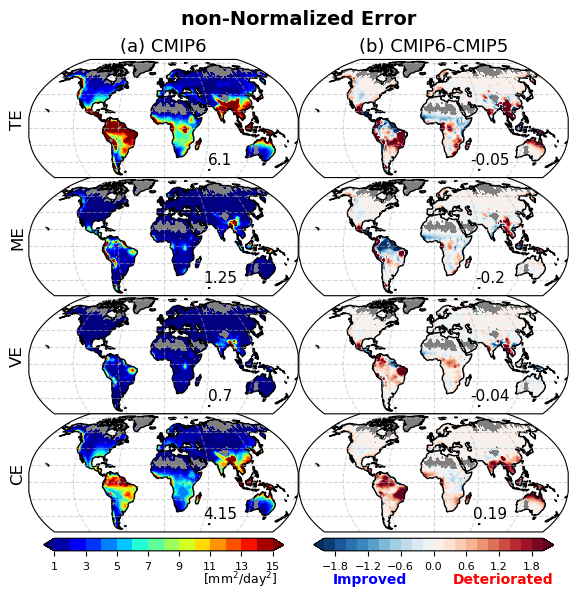

In [19]:
import string
from shapely.geometry.polygon import LinearRing, Polygon
import matplotlib.colors

alphabet = list(string.ascii_lowercase)

nvar = 'pr'
stitle = 'non-Normalized Error'
# stitle = 'Normalized Error'

if stitle == 'non-Normalized Error':
    titles = ['(a) CMIP6','(b) CMIP6-CMIP5']
    var_names = ['TE','ME','VE','CE']
    fname='./fig/error_map_'+nvar+'_'+stitle+'.png'
else:
    titles = ['(c) CMIP6','(d) CMIP6-CMIP5']
    var_names = ['nTE','nME','nVE','nCE']
    fname='./fig/error_map_'+nvar+'_'+stitle+'.png'
    

nrows = 4
ncols = 2


# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                        figsize=(6,6.3))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    
    if nvar=='tas' and stitle == 'non-Normalized Error':
        data = map_t[0,pp%ncols+1,:,pp//ncols,:,:].mean(dim='models').sel(lat=slice(-60,90))
        clevs1=np.arange(1,21,1)
        clevs2=np.arange(-5,5.5,0.5)
        units = 'K$^2$'
    elif nvar=='tas' and stitle == 'Normalized Error':
        data = map_t[1,pp%ncols+1,:,pp//ncols,:,:].mean(dim='models').sel(lat=slice(-60,90))
        clevs1=np.arange(0.2,3.2,0.2)
        clevs2=np.arange(-0.4,0.45,0.05)
        units = '-'
    elif nvar=='pr' and stitle == 'non-Normalized Error':
        data = map_p[0,pp%ncols+1,:,pp//ncols,:,:].mean(dim='models').sel(lat=slice(-60,90))
        clevs1=np.arange(1,16,1)
        clevs2=np.arange(-2,2.2,0.2)
        units = 'mm$^2$/day$^2$'
    elif nvar=='pr' and stitle == 'Normalized Error':
        data = map_p[1,pp%ncols+1,:,pp//ncols,:,:].mean(dim='models').sel(lat=slice(-60,90))
        clevs1=np.arange(0.2,3.2,0.2)
        # clevs2=np.arange(-0.24,0.26,0.04)
        clevs2=np.arange(-0.3,0.35,0.05)
        units = '-'
    
    if pp==1 or pp==3 or pp==5 or pp==7:
        clevs = clevs2
        cmap = 'RdBu_r'
    else:
        clevs = clevs1
        cmap = 'jet'


    lon2d, lat2d = np.meshgrid(data.lon, data.lat)
    cs = axs[pp].contourf(lon2d,lat2d,data,clevs,
                      transform = ccrs.PlateCarree(),
                      cmap=cmap,extend='both')
    
    if pp==1 or pp==3 or pp==5 or pp==7:
        cs2 = cs
    else:
        cs1 = cs
    
    # Title each subplot with the name of the model
    if pp//ncols == 0:
        axs[pp].set_title(titles[pp], fontsize=13)
        
    # Draw the coastines for each subplot
    axs[pp].coastlines()
    axs[pp].add_feature(cfeature.LAND, facecolor='gray')
    
    bias = data.mean().item()
    axs[pp].annotate('{}'.format(round(bias,2)),xy=(0.71, 0.22), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='top', color='black', fontsize=11)
    
    
    # Draw gridlines except for xlabels_top and ylabels_left
    gl = axs[pp].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    gl.ylabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    
    
for pp in range(nrows*ncols):
    if pp%ncols == 0:
        axs[pp].text(-0.07,0.5, var_names[pp//ncols], size=12, rotation=90, verticalalignment="center", transform=axs[pp].transAxes)
    
# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.15, top=0.9, left=0.05, right=0.95,
                    wspace=0.0, hspace=0.0) # wspace: horizontal space, hspace: vertical space


# Add a colorbar axis at the bottom of the graph
cbar_ax  = fig.add_axes([0.075, 0.12, 0.4, 0.02])
cbar_ax1 = fig.add_axes([0.525, 0.12, 0.4, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs1, cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=8)

cbar1=fig.colorbar(cs2, cax=cbar_ax1,orientation='horizontal')
cbar1.ax.tick_params(labelsize=8)

axs[pp].text(0.4,-0.4, 'Improved', color='blue', size=10, rotation=0, verticalalignment="center", horizontalalignment='right', transform=axs[pp].transAxes, weight='bold')
axs[pp].text(0.57,-0.4, 'Deteriorated', color='red', size=10, rotation=0, verticalalignment="center", horizontalalignment='left', transform=axs[pp].transAxes, weight='bold')
axs[pp].text(-0.08,-0.4, '[{}]'.format(units), color='black', size=9, rotation=0, verticalalignment="center", horizontalalignment='right', transform=axs[pp].transAxes)

# Add a big title at the top
plt.suptitle(stitle,fontsize=14, weight='bold')
# plt.savefig(fname, dpi=500, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

# Fig.3

In [26]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [27]:
def model_eval_2nd_sig_norm(x, y, dname):
    # x is model
    # y is observation
    xmean = x.mean(dim=dname)
    ymean = y.mean(dim=dname)
    xstd = x.std(dim=dname)
    ystd = y.std(dim=dname)
    diff = ( (x-y)**2 ).mean(dim=dname)
    score  = diff/(2*xstd*ystd)
    bias  = xmean - ymean
    bsig = (bias/abs(bias)) 
    vsig = np.log( xstd / ystd )
    score1 = ( (xmean-ymean)**2 )/(ystd**2)
    score21 = ( (xstd/ystd)-1 )**2
    score22 = (2*xstd/ystd)*(1-xr.corr(x,y,dim=dname))
    score2 = score21 + score22
    score1_sig = score1 * bsig
    score21_sig = score21 * vsig
    return score.where(np.isfinite(score)), score1.where(np.isfinite(score1)), score2.where(np.isfinite(score2)), score21.where(np.isfinite(score21)), score22.where(np.isfinite(score22)), score1_sig.where(np.isfinite(score1_sig)), score21_sig.where(np.isfinite(score21_sig))

def model_eval_2nd_sig(x, y, dname):
    # x is model
    # y is observation
    xmean = x.mean(dim=dname)
    ymean = y.mean(dim=dname)
    xstd = x.std(dim=dname)
    ystd = y.std(dim=dname)
    diff = ( (x-y)**2 ).mean(dim=dname)
    score  = diff
    bias  = xmean - ymean
    bsig = (bias/abs(bias)) 
    vsig = np.log( xstd / ystd )
    score1 = ( (xmean-ymean)**2 )
    score21 = ( (xstd-ystd)**2 )
    score22 = (2*xstd*ystd)*(1-xr.corr(x,y,dim=dname))
    score2 = score21 + score22
    score1_sig = score1 * bsig
    score21_sig = score21 * vsig
    return score.where(np.isfinite(score)), score1.where(np.isfinite(score1)), score2.where(np.isfinite(score2)), score21.where(np.isfinite(score21)), score22.where(np.isfinite(score22)), score1_sig.where(np.isfinite(score1_sig)), score21_sig.where(np.isfinite(score21_sig))

In [28]:
_, _, _, _, _, ts1_mon_c5_sig_norm, ts21_mon_c5_sig_norm = model_eval_2nd_sig_norm(t_c5, ot, 'time')
_, _, _, _, _, ts1_mon_c6_sig_norm, ts21_mon_c6_sig_norm = model_eval_2nd_sig_norm(t_c6, ot, 'time')
_, _, _, _, _, ps1_mon_c5_sig_norm, ps21_mon_c5_sig_norm = model_eval_2nd_sig_norm(p_c5, op, 'time')
_, _, _, _, _, ps1_mon_c6_sig_norm, ps21_mon_c6_sig_norm = model_eval_2nd_sig_norm(p_c6, op, 'time')

In [29]:
_, _, _, _, _, ts1_mon_c5_sig_norm_mme, ts21_mon_c5_sig_norm_mme = model_eval_2nd_sig_norm(t_c5.mean(dim='models'), ot, 'time')
_, _, _, _, _, ts1_mon_c6_sig_norm_mme, ts21_mon_c6_sig_norm_mme = model_eval_2nd_sig_norm(t_c6.mean(dim='models'), ot, 'time')
_, _, _, _, _, ps1_mon_c5_sig_norm_mme, ps21_mon_c5_sig_norm_mme = model_eval_2nd_sig_norm(p_c5.mean(dim='models'), op, 'time')
_, _, _, _, _, ps1_mon_c6_sig_norm_mme, ps21_mon_c6_sig_norm_mme = model_eval_2nd_sig_norm(p_c6.mean(dim='models'), op, 'time')

In [30]:
_, _, _, _, _, ts1_mon_c5_sig, ts21_mon_c5_sig = model_eval_2nd_sig(t_c5, ot, 'time')
_, _, _, _, _, ts1_mon_c6_sig, ts21_mon_c6_sig = model_eval_2nd_sig(t_c6, ot, 'time')
_, _, _, _, _, ps1_mon_c5_sig, ps21_mon_c5_sig = model_eval_2nd_sig(p_c5, op, 'time')
_, _, _, _, _, ps1_mon_c6_sig, ps21_mon_c6_sig = model_eval_2nd_sig(p_c6, op, 'time')

In [31]:
_, _, _, _, _, ts1_mon_c5_sig_mme, ts21_mon_c5_sig_mme = model_eval_2nd_sig(t_c5.mean(dim='models'), ot, 'time')
_, _, _, _, _, ts1_mon_c6_sig_mme, ts21_mon_c6_sig_mme = model_eval_2nd_sig(t_c6.mean(dim='models'), ot, 'time')
_, _, _, _, _, ps1_mon_c5_sig_mme, ps21_mon_c5_sig_mme = model_eval_2nd_sig(p_c5.mean(dim='models'), op, 'time')
_, _, _, _, _, ps1_mon_c6_sig_mme, ps21_mon_c6_sig_mme = model_eval_2nd_sig(p_c6.mean(dim='models'), op, 'time')

In [32]:
smap1 = xr.DataArray(data = np.empty([2,3,len(cmip5_name),2,len(ot.lat),len(ot.lon)]) * np.nan, 
                    dims=["vars","mips","models","scores","lat","lon"],
                    coords = dict(vars=(["vars"], [x for x in range(2)]),
                                  mips=(["mips"], [x for x in range(3)]),
                                  models=(["models"], [x for x in range(len(cmip5_name))]),
                                  scores=(["scores"], [x for x in range(2)]),
                                  lat=(["lat"], ot.lat.values),
                                  lon=(["lon"], ot.lon.values),
                                 )
                   )
smap2 = smap1.copy(deep=True)

smap1[0,0,:,0,:,:] = ts1_mon_c5_sig_norm
smap1[0,0,:,1,:,:] = ts21_mon_c5_sig_norm
smap1[0,1,:,0,:,:] = ts1_mon_c6_sig_norm
smap1[0,1,:,1,:,:] = ts21_mon_c6_sig_norm
smap1[0,2,:,:,:,:] = smap1[0,1,:,:,:,:] - smap1[0,0,:,:,:,:]

smap1[1,0,:,0,:,:] = ps1_mon_c5_sig_norm
smap1[1,0,:,1,:,:] = ps21_mon_c5_sig_norm
smap1[1,1,:,0,:,:] = ps1_mon_c6_sig_norm
smap1[1,1,:,1,:,:] = ps21_mon_c6_sig_norm
smap1[1,2,:,:,:,:] = smap1[1,1,:,:,:,:] - smap1[1,0,:,:,:,:]

smap2[0,0,:,0,:,:] = ts1_mon_c5_sig
smap2[0,0,:,1,:,:] = ts21_mon_c5_sig
smap2[0,1,:,0,:,:] = ts1_mon_c6_sig
smap2[0,1,:,1,:,:] = ts21_mon_c6_sig
smap2[0,2,:,:,:,:] = smap2[0,1,:,:,:,:] - smap2[0,0,:,:,:,:]

smap2[1,0,:,0,:,:] = ps1_mon_c5_sig
smap2[1,0,:,1,:,:] = ps21_mon_c5_sig
smap2[1,1,:,0,:,:] = ps1_mon_c6_sig
smap2[1,1,:,1,:,:] = ps21_mon_c6_sig
smap2[1,2,:,:,:,:] = smap2[1,1,:,:,:,:] - smap2[1,0,:,:,:,:]

In [33]:
smap_mme1 = xr.DataArray(data = np.empty([2,3,2,len(ot.lat),len(ot.lon)]) * np.nan, 
                    dims=["vars","mips","scores","lat","lon"],
                    coords = dict(vars=(["vars"], [x for x in range(2)]),
                                  mips=(["mips"], [x for x in range(3)]),
                                  scores=(["scores"], [x for x in range(2)]),
                                  lat=(["lat"], ot.lat.values),
                                  lon=(["lon"], ot.lon.values),
                                 )
                   )
smap_mme2 = smap_mme1.copy(deep=True)

smap_mme1[0,0,0,:,:] = ts1_mon_c5_sig_norm_mme
smap_mme1[0,0,1,:,:] = ts21_mon_c5_sig_norm_mme
smap_mme1[0,1,0,:,:] = ts1_mon_c6_sig_norm_mme
smap_mme1[0,1,1,:,:] = ts21_mon_c6_sig_norm_mme
smap_mme1[0,2,:,:,:] = smap_mme1[0,1,:,:,:] - smap_mme1[0,0,:,:,:]

smap_mme1[1,0,0,:,:] = ps1_mon_c5_sig_norm_mme
smap_mme1[1,0,1,:,:] = ps21_mon_c5_sig_norm_mme
smap_mme1[1,1,0,:,:] = ps1_mon_c6_sig_norm_mme
smap_mme1[1,1,1,:,:] = ps21_mon_c6_sig_norm_mme
smap_mme1[1,2,:,:,:] = smap_mme1[1,1,:,:,:] - smap_mme1[1,0,:,:,:]

smap_mme2[0,0,0,:,:] = ts1_mon_c5_sig_mme
smap_mme2[0,0,1,:,:] = ts21_mon_c5_sig_mme
smap_mme2[0,1,0,:,:] = ts1_mon_c6_sig_mme
smap_mme2[0,1,1,:,:] = ts21_mon_c6_sig_mme
smap_mme2[0,2,:,:,:] = smap_mme2[0,1,:,:,:] - smap_mme2[0,0,:,:,:]

smap_mme2[1,0,0,:,:] = ps1_mon_c5_sig_mme
smap_mme2[1,0,1,:,:] = ps21_mon_c5_sig_mme
smap_mme2[1,1,0,:,:] = ps1_mon_c6_sig_mme
smap_mme2[1,1,1,:,:] = ps21_mon_c6_sig_mme
smap_mme2[1,2,:,:,:] = smap_mme2[1,1,:,:,:] - smap_mme2[1,0,:,:,:]

In [60]:
gm1  = map1.mean(dim= ('lon', 'lat'))
gsm1 = smap1.mean(dim= ('lon', 'lat'))

gm2  = map2.mean(dim= ('lon', 'lat'))
gsm2 = smap2.mean(dim= ('lon', 'lat'))

gm3  = map3.mean(dim= ('lon', 'lat'))
gsm3 = smap_mme1.mean(dim= ('lon', 'lat'))

gm4  = map4.mean(dim= ('lon', 'lat'))
gsm4 = smap_mme2.mean(dim= ('lon', 'lat'))

In [48]:
ary = gm1[0,2,:,0].values
value = sorted(ary, reverse=True)
index = sorted(range(len(ary)), key=lambda k: ary[k],reverse=True)
[cname[x] for x in index]

['M1',
 'G2',
 'M3',
 'C4',
 'A',
 'I2',
 'M2',
 'C3',
 'M4',
 'C2',
 'C1',
 'G1',
 'N',
 'I1']

[0.10230226641993045, 0.012024599570582403, 0.23766271092880592, 0.8673194817107259, 0.15033829901190165, 0.09301280492554934, 0.05573823195809962, 0.039418425500015425, 0.01883159774017262, 0.034282946088387944, 0.05746731590096357, 0.016261275010895703, 0.12890717152519215, 0.013048023844903403]
[0.21920253244119992, 0.08458723243360032, 0.27142282660565437, 0.10469423269213109, 0.12199298764560085, 0.012850191503001424, 0.06573420656522061, 0.007835672064451878, 0.03339722425350735, 0.04061552598790433, 0.04617701330238595, 0.02005567713469675, 0.02167184658450871, 0.014980475798837982]
[0.2019192317887864, 0.17803799618255625, 0.034253294071513715, -0.033715673525303975, 0.2238166321299039, 0.08981971791174062, 0.28767626132573065, 0.04069396383587859, 0.282740515868389, 0.13417071727987945, 0.39112103462728576, 0.34813848611517817, 0.6119350005285311, 0.45720455059191434]
[0.3092994322052725, 0.31840483438238254, 0.397740146671579, 0.14032938269578654, 0.17815369891287436, 0.22901

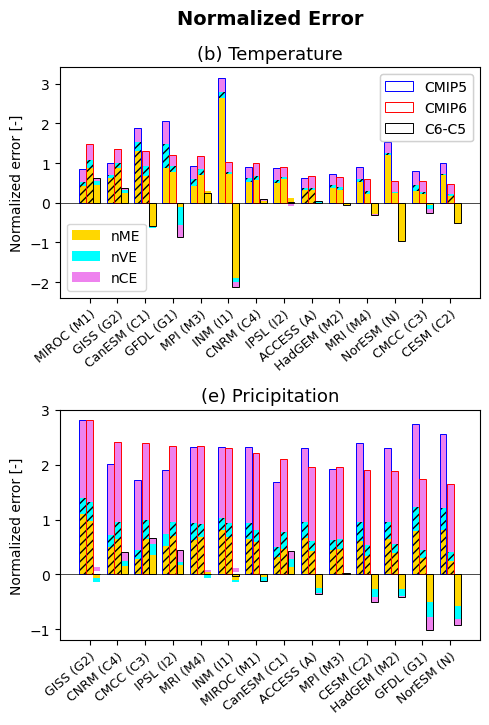

In [47]:
cname2 = ['ACCESS (A)','CanESM (C1)','CESM (C2)','CMCC (C3)','CNRM (C4)',
         'GFDL (G1)','GISS (G2)','INM (I1)','IPSL (I2)','MIROC (M1)',
         'HadGEM (M2)','MPI (M3)','MRI (M4)','NorESM (N)']
cname = ['A','C1','C2','C3','C4',
         'G1','G2','I1','I2','M1',
         'M2','M3','M4','N']

fname="./fig/bar_error.png"
stitle='Normalized Error'

fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(5,7))
width = 0.25  # the width of the bars: can also be len(x) sequence
nscore = ['nME','nVE','nCE']
colors = ['gold','cyan','violet']

gm = gm1
gsm = gsm1
ary = gm[0,1,:,0].values
value = sorted(ary, reverse=True)
index = sorted(range(len(ary)), key=lambda k: ary[k],reverse=True)
t_cname = [cname[x] for x in index]
t_cname2 = [cname2[x] for x in index]

bottom1 = np.zeros(gm.shape[2])
bottom2 = np.zeros(gm.shape[2])
bottom3 = np.zeros(gm.shape[2])
bot = np.zeros((len(cname),4))
for x in range(1,gm.shape[3]):
    ary1 = gm[0,0,:,x].values
    data = [ary1[i] for i in index]
    bdata = [ary1[i] for i in index]
    bar = axs[0].bar(np.arange(len(ary1))-width-0.01, data, width, label=nscore[x-1], color=colors[x-1], bottom=bottom1)
    
    if x <= 2:
        sary1 = gsm[0,0,:,x-1].values
        sdata = [sary1[i] for i in index]
        if x ==2:
            print(sdata)
        for i in range(len(data)):
            if sdata[i] < 0:
                data[i] = np.nan
        
        axs[0].bar(np.arange(len(ary1))-width-0.01, data, width, hatch='////', bottom=bottom1, fill=False, linewidth=0.)
        del sdata
   
    bottom1 += bdata
    del bdata, data
    
    
    
    ary2 = gm[0,1,:,x].values
    data = [ary2[i] for i in index]
    bdata = [ary2[i] for i in index]
    axs[0].bar(np.arange(len(ary2))-0.0, data, width, label=nscore[x-1], color=colors[x-1], bottom=bottom2)
    
    if x <= 2:
        sary2 = gsm[0,1,:,x-1].values
        sdata = [sary2[i] for i in index]
        if x ==2:
            print(sdata)
        for i in range(len(data)):
            if sdata[i] < 0:
                data[i] = np.nan
        axs[0].bar(np.arange(len(ary2))-0.0, data, width, hatch='////', bottom=bottom2, fill=False, linewidth=0.)
        del sdata
   
    bottom2 += bdata
    del bdata, data   
    
    
    ary3 = gm[0,2,:,x].values
    data = [ary3[i] for i in index]
    if x==2:
        bottom3 = np.zeros(gm.shape[2])
        for i in range(len(cname)):
            if data[i] >= 0:
                bottom3[i] = bot[i,x-1]
            elif data[i] < 0:
                bottom3[i] = bot[i,:].min()
    elif x==3:
        bottom3 = np.zeros(gm.shape[2])
        for i in range(len(cname)):
            if data[i] >= 0:
                if bot[i,x-2] >=0 and bot[i,x-1] >=0:
                    bottom3[i] = bot[i,:].sum()
                else:
                    bottom3[i] = bot[i,:].max()
            elif data[i] < 0:
                if bot[i,x-2] <=0 and bot[i,x-1] <=0:
                    bottom3[i] = bot[i,:].sum()
                else:
                    bottom3[i] = bot[i,:].min()
                
    axs[0].bar(np.arange(len(ary3))+width+0.01, data, width, label=nscore[x-1], color=colors[x-1], bottom=bottom3)
    bot[:,x] = data
    if x == 1:
        b1 = bar
    elif x == 2:
        b2 = bar
    elif x == 3:
        b3 = bar

d1 = gm[0,0,:,0].values
d2 = gm[0,1,:,0].values
d3 = gm[0,2,:,0].values
data = [d1[i] for i in index]
c1 = axs[0].bar(np.arange(len(ary1))-width-0.01, data, width, label='CMIP5', edgecolor='blue', fill=False, linewidth=0.7)
data = [d2[i] for i in index]
c2 = axs[0].bar(np.arange(len(ary1)),            data, width, label='CMIP6', edgecolor='red', fill=False, linewidth=0.7)
data = [d3[i] for i in index]
c3 = axs[0].bar(np.arange(len(ary1))+width+0.01, data, width, label='C6-C5', edgecolor='black', fill=False, linewidth=0.7)

axs[0].set_title('(b) Temperature', fontsize=13)
leg1 = axs[0].legend(handles=(b1,b2,b3),loc='lower left')
axs[0].add_artist(leg1)
leg2 = axs[0].legend(handles=(c1,c2,c3),loc='upper right')
axs[0].add_artist(leg2)

axs[0].set_xticks(np.arange(gm.shape[2]))
axs[0].set_xticklabels(t_cname2, fontsize=9)
axs[0].axhline(y=0., color='black', linestyle='-', linewidth=0.5)
axs[0].set_ylabel('{}'.format('Normalized error [-]'),fontsize=10)

plt.setp(axs[0].get_xticklabels(), rotation=40, ha="right",
         rotation_mode="anchor")

del ary,value, index, c1, c2, c3, bot, bottom1, bottom2,bottom3
ary = gm[1,1,:,0].values
value = sorted(ary, reverse=True)
index = sorted(range(len(ary)), key=lambda k: ary[k],reverse=True)
p_cname = [cname[x] for x in index]
p_cname2 = [cname2[x] for x in index]

bottom1 = np.zeros(gm.shape[2])
bottom2 = np.zeros(gm.shape[2])
bottom3 = np.zeros(gm.shape[2])
bot = np.zeros((len(cname),4))
for x in range(1,gm.shape[3]):
    ary1 = gm[1,0,:,x].values
    data = [ary1[i] for i in index]
    bdata = [ary1[i] for i in index]
    bar = axs[1].bar(np.arange(len(ary1))-width-0.01, data, width, label=nscore[x-1], color=colors[x-1], bottom=bottom1)
    
    if x <= 2:
        sary1 = gsm[1,0,:,x-1].values
        sdata = [sary1[i] for i in index]
        if x ==2:
            print(sdata)
        for i in range(len(data)):
            if sdata[i] < 0:
                data[i] = np.nan
        axs[1].bar(np.arange(len(ary1))-width-0.01, data, width, hatch='////', bottom=bottom1, fill=False, linewidth=0.)
        del sdata
   
    bottom1 += bdata
    del bdata, data
    
    ary2 = gm[1,1,:,x].values
    data = [ary2[i] for i in index]
    bdata = [ary2[i] for i in index]
    axs[1].bar(np.arange(len(ary2))-0.0, data, width, label=nscore[x-1], color=colors[x-1], bottom=bottom2)
    
    if x <= 2:
        sary2 = gsm[1,1,:,x-1].values
        sdata = [sary2[i] for i in index]
        if x ==2:
            print(sdata)
        for i in range(len(data)):
            if sdata[i] < 0:
                data[i] = np.nan
        axs[1].bar(np.arange(len(ary2))-0.0, data, width, hatch='////', bottom=bottom2, fill=False, linewidth=0.)
        del sdata
   
    bottom2 += bdata
    del bdata, data
    
    ary3 = gm[1,2,:,x].values
    data = [ary3[i] for i in index]
    if x==2:
        bottom3 = np.zeros(gm.shape[2])
        for i in range(len(cname)):
            if data[i] >= 0:
                bottom3[i] = bot[i,x-1]
            elif data[i] < 0:
                bottom3[i] = bot[i,:].min()
    elif x==3:
        bottom3 = np.zeros(gm.shape[2])
        for i in range(len(cname)):
            if data[i] >= 0:
                if bot[i,x-2] >=0 and bot[i,x-1] >=0:
                    bottom3[i] = bot[i,:].sum()
                else:
                    bottom3[i] = bot[i,:].max()
            elif data[i] < 0:
                if bot[i,x-2] <=0 and bot[i,x-1] <=0:
                    bottom3[i] = bot[i,:].sum()
                else:
                    bottom3[i] = bot[i,:].min()
                
    axs[1].bar(np.arange(len(ary3))+width+0.01, data, width, label=nscore[x-1], color=colors[x-1], bottom=bottom3)
    bot[:,x] = data
    if x == 1:
        b1 = bar
    elif x == 2:
        b2 = bar
    elif x == 3:
        b3 = bar

d1 = gm[1,0,:,0].values
d2 = gm[1,1,:,0].values
d3 = gm[1,2,:,0].values
data = [d1[i] for i in index]
c2 = axs[1].bar(np.arange(len(ary1))-width-0.01, data, width, label='CMIP5', edgecolor='blue', fill=False, linewidth=0.7)
data = [d2[i] for i in index]
c3 = axs[1].bar(np.arange(len(ary1)),            data, width, label='CMIP6', edgecolor='red', fill=False, linewidth=0.7)
data = [d3[i] for i in index]
c1 = axs[1].bar(np.arange(len(ary1))+width+0.01, data, width, label='C6-C5', edgecolor='black', fill=False, linewidth=0.7)


axs[1].set_title('(e) Pricipitation', fontsize=13)
axs[1].set_xticks(np.arange(gm.shape[2]))
axs[1].set_xticklabels(p_cname2, fontsize=9)
axs[1].axhline(y=0., color='black', linestyle='-', linewidth=0.5)
axs[1].set_ylabel('{}'.format('Normalized error [-]'),fontsize=10)

plt.setp(axs[1].get_xticklabels(), rotation=40, ha="right",
         rotation_mode="anchor")

fig.tight_layout()
plt.suptitle(stitle,fontsize=14, weight='bold', x=0.55, y=1.03)
# plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

[0.18801781191138123, 0.005473173859905431, 0.2972236363878651, -0.7094452441279946, 0.6621662980660916, 0.8135294692738182, 0.5280852835499616, 0.537888105718209, 0.6540304546228831, 0.4844478949545137, -0.14125178774995886, 0.20284117966950402, 0.07336672088377871, -0.13118778612862358]
[0.6507006580896026, 0.2163764826120302, 0.36134338868818966, -0.36945202964204743, 0.19114797854400628, 0.30580050155202276, -0.11377436611692632, 0.3471344373358989, 0.10684561073545629, 0.10686436845797691, -0.06065146549250098, -0.13486595520630942, -0.2166381895998261, -0.02861949493529988]
[-0.20106789476805678, -0.3162979464662293, -0.517719494073806, 0.43257533042004376, -0.14257814272708688, -0.4224761349019973, -0.10064870545580792, -0.08489857623515334, -0.1951690739908585, 0.18829612299632678, 0.1877877368822481, -0.09066786127458651, -0.1622891923314834, 0.08648751076400153]
[0.07922163074941574, 0.23062063807460695, 0.03885580965515274, 0.29563564618682986, 0.08732139446152175, 0.0521309

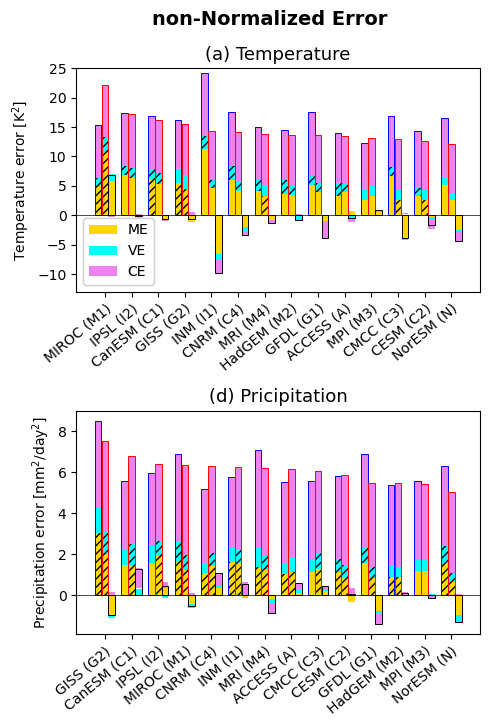

In [49]:
cname2 = ['ACCESS (A)','CanESM (C1)','CESM (C2)','CMCC (C3)','CNRM (C4)',
         'GFDL (G1)','GISS (G2)','INM (I1)','IPSL (I2)','MIROC (M1)',
         'HadGEM (M2)','MPI (M3)','MRI (M4)','NorESM (N)']

fname="./fig/bar_norm_error.png"
stitle='non-Normalized Error'

fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(5,7))
width = 0.25  # the width of the bars: can also be len(x) sequence
nscore = ['ME','VE','CE']
colors = ['gold','cyan','violet']

gm = gm2
gsm = gsm2
ary = gm[0,1,:,0].values
value = sorted(ary, reverse=True)
index = sorted(range(len(ary)), key=lambda k: ary[k],reverse=True)
t_cname = [cname[x] for x in index]
t_cname2 = [cname2[x] for x in index]

bottom1 = np.zeros(gm.shape[2])
bottom2 = np.zeros(gm.shape[2])
bottom3 = np.zeros(gm.shape[2])
bot = np.zeros((len(cname),4))
for x in range(1,gm.shape[3]):
    ary1 = gm[0,0,:,x].values
    data = [ary1[i] for i in index]
    bdata = [ary1[i] for i in index]
    bar = axs[0].bar(np.arange(len(ary1))-width-0.01, data, width, label=nscore[x-1], color=colors[x-1], bottom=bottom1)
    
    if x <= 2:
        sary1 = gsm[0,0,:,x-1].values
        sdata = [sary1[i] for i in index]
        if x ==2:
            print(sdata)
        for i in range(len(data)):
            if sdata[i] < 0:
                data[i] = np.nan
        
        axs[0].bar(np.arange(len(ary1))-width-0.01, data, width, hatch='////', bottom=bottom1, fill=False, linewidth=0.)
        del sdata
   
    bottom1 += bdata
    del bdata, data
    
    
    
    ary2 = gm[0,1,:,x].values
    data = [ary2[i] for i in index]
    bdata = [ary2[i] for i in index]
    axs[0].bar(np.arange(len(ary2))-0.0, data, width, label=nscore[x-1], color=colors[x-1], bottom=bottom2)
    
    if x <= 2:
        sary2 = gsm[0,1,:,x-1].values
        sdata = [sary2[i] for i in index]
        if x ==2:
            print(sdata)
        for i in range(len(data)):
            if sdata[i] < 0:
                data[i] = np.nan
        axs[0].bar(np.arange(len(ary2))-0.0, data, width, hatch='////', bottom=bottom2, fill=False, linewidth=0.)
        del sdata
   
    bottom2 += bdata
    del bdata, data   
    
    
    ary3 = gm[0,2,:,x].values
    data = [ary3[i] for i in index]
    if x==2:
        bottom3 = np.zeros(gm.shape[2])
        for i in range(len(cname)):
            if data[i] >= 0:
                bottom3[i] = bot[i,x-1]
            elif data[i] < 0:
                bottom3[i] = bot[i,:].min()
    elif x==3:
        bottom3 = np.zeros(gm.shape[2])
        for i in range(len(cname)):
            if data[i] >= 0:
                if bot[i,x-2] >=0 and bot[i,x-1] >=0:
                    bottom3[i] = bot[i,:].sum()
                else:
                    bottom3[i] = bot[i,:].max()
            elif data[i] < 0:
                if bot[i,x-2] <=0 and bot[i,x-1] <=0:
                    bottom3[i] = bot[i,:].sum()
                else:
                    bottom3[i] = bot[i,:].min()
                
    axs[0].bar(np.arange(len(ary3))+width+0.01, data, width, label=nscore[x-1], color=colors[x-1], bottom=bottom3)
    bot[:,x] = data
    if x == 1:
        b1 = bar
    elif x == 2:
        b2 = bar
    elif x == 3:
        b3 = bar

d1 = gm[0,0,:,0].values
d2 = gm[0,1,:,0].values
d3 = gm[0,2,:,0].values
data = [d1[i] for i in index]
c1 = axs[0].bar(np.arange(len(ary1))-width-0.01, data, width, label='CMIP5', edgecolor='blue', fill=False, linewidth=0.7)
data = [d2[i] for i in index]
c2 = axs[0].bar(np.arange(len(ary1)),            data, width, label='CMIP6', edgecolor='red', fill=False, linewidth=0.7)
data = [d3[i] for i in index]
c3 = axs[0].bar(np.arange(len(ary1))+width+0.01, data, width, label='C6-C5', edgecolor='black', fill=False, linewidth=0.7)

axs[0].set_title('(a) Temperature', fontsize=13)
leg1 = axs[0].legend(handles=(b1,b2,b3),loc='lower left')
axs[0].add_artist(leg1)
# leg2 = axs[0].legend(handles=(c1,c2,c3),loc='upper right')
# axs[0].add_artist(leg2)
# axs[0].set_xlim([rmin-rd*0.04, rmax+rd*0.04])
axs[0].set_ylim([-13, 25])

axs[0].set_xticks(np.arange(gm.shape[2]))
axs[0].set_xticklabels(t_cname2, fontsize=10)
axs[0].axhline(y=0., color='black', linestyle='-', linewidth=0.5)
axs[0].set_ylabel('{}'.format('Temperature error [K$^2$]'),fontsize=10)

plt.setp(axs[0].get_xticklabels(), rotation=40, ha="right",
         rotation_mode="anchor")

del ary,value, index, c1, c2, c3, bot, bottom1, bottom2,bottom3
ary = gm[1,1,:,0].values
value = sorted(ary, reverse=True)
index = sorted(range(len(ary)), key=lambda k: ary[k],reverse=True)
p_cname = [cname[x] for x in index]
p_cname2 = [cname2[x] for x in index]

bottom1 = np.zeros(gm.shape[2])
bottom2 = np.zeros(gm.shape[2])
bottom3 = np.zeros(gm.shape[2])
bot = np.zeros((len(cname),4))
for x in range(1,gm.shape[3]):
    ary1 = gm[1,0,:,x].values
    data = [ary1[i] for i in index]
    bdata = [ary1[i] for i in index]
    bar = axs[1].bar(np.arange(len(ary1))-width-0.01, data, width, label=nscore[x-1], color=colors[x-1], bottom=bottom1)
    
    if x <= 2:
        sary1 = gsm[1,0,:,x-1].values
        sdata = [sary1[i] for i in index]
        if x ==2:
            print(sdata)
        for i in range(len(data)):
            if sdata[i] < 0:
                data[i] = np.nan
        axs[1].bar(np.arange(len(ary1))-width-0.01, data, width, hatch='////', bottom=bottom1, fill=False, linewidth=0.)
        del sdata
   
    bottom1 += bdata
    del bdata, data
    
    ary2 = gm[1,1,:,x].values
    data = [ary2[i] for i in index]
    bdata = [ary2[i] for i in index]
    axs[1].bar(np.arange(len(ary2))-0.0, data, width, label=nscore[x-1], color=colors[x-1], bottom=bottom2)
    
    if x <= 2:
        sary2 = gsm[1,1,:,x-1].values
        sdata = [sary2[i] for i in index]
        if x ==2:
            print(sdata)
        for i in range(len(data)):
            if sdata[i] < 0:
                data[i] = np.nan
        axs[1].bar(np.arange(len(ary2))-0.0, data, width, hatch='////', bottom=bottom2, fill=False, linewidth=0.)
        del sdata
   
    bottom2 += bdata
    del bdata, data
    
    ary3 = gm[1,2,:,x].values
    data = [ary3[i] for i in index]
    if x==2:
        bottom3 = np.zeros(gm.shape[2])
        for i in range(len(cname)):
            if data[i] >= 0:
                bottom3[i] = bot[i,x-1]
            elif data[i] < 0:
                bottom3[i] = bot[i,:].min()
    elif x==3:
        bottom3 = np.zeros(gm.shape[2])
        for i in range(len(cname)):
            if data[i] >= 0:
                if bot[i,x-2] >=0 and bot[i,x-1] >=0:
                    bottom3[i] = bot[i,:].sum()
                else:
                    bottom3[i] = bot[i,:].max()
            elif data[i] < 0:
                if bot[i,x-2] <=0 and bot[i,x-1] <=0:
                    bottom3[i] = bot[i,:].sum()
                else:
                    bottom3[i] = bot[i,:].min()
                
    axs[1].bar(np.arange(len(ary3))+width+0.01, data, width, label=nscore[x-1], color=colors[x-1], bottom=bottom3)
    bot[:,x] = data
    if x == 1:
        b1 = bar
    elif x == 2:
        b2 = bar
    elif x == 3:
        b3 = bar

d1 = gm[1,0,:,0].values
d2 = gm[1,1,:,0].values
d3 = gm[1,2,:,0].values
data = [d1[i] for i in index]
c2 = axs[1].bar(np.arange(len(ary1))-width-0.01, data, width, label='CMIP5', edgecolor='blue', fill=False, linewidth=0.7)
data = [d2[i] for i in index]
c3 = axs[1].bar(np.arange(len(ary1)),            data, width, label='CMIP6', edgecolor='red', fill=False, linewidth=0.7)
data = [d3[i] for i in index]
c1 = axs[1].bar(np.arange(len(ary1))+width+0.01, data, width, label='C6-C5', edgecolor='black', fill=False, linewidth=0.7)

axs[1].set_title('(d) Pricipitation', fontsize=13)
axs[1].set_xticks(np.arange(gm.shape[2]))
axs[1].set_xticklabels(p_cname2, fontsize=10)
axs[1].axhline(y=0., color='black', linestyle='-', linewidth=0.5)
axs[1].set_ylabel('{}'.format('Precipitation error [mm$^2$/day$^2$]'),fontsize=10)

plt.setp(axs[1].get_xticklabels(), rotation=40, ha="right",
         rotation_mode="anchor")

fig.tight_layout()
plt.suptitle(stitle,fontsize=14, weight='bold', x=0.55, y=1.03)
# plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

0.19591226539965645 0.2723298653637605 0.3462252616696256
0.11703699144626553 0.2713335265925485 0.3480626768685137
0.37259805248205463 0.35847972604321415 0.20817412724785575
0.5538861299573272 0.44489941549417744 0.11093037210395877


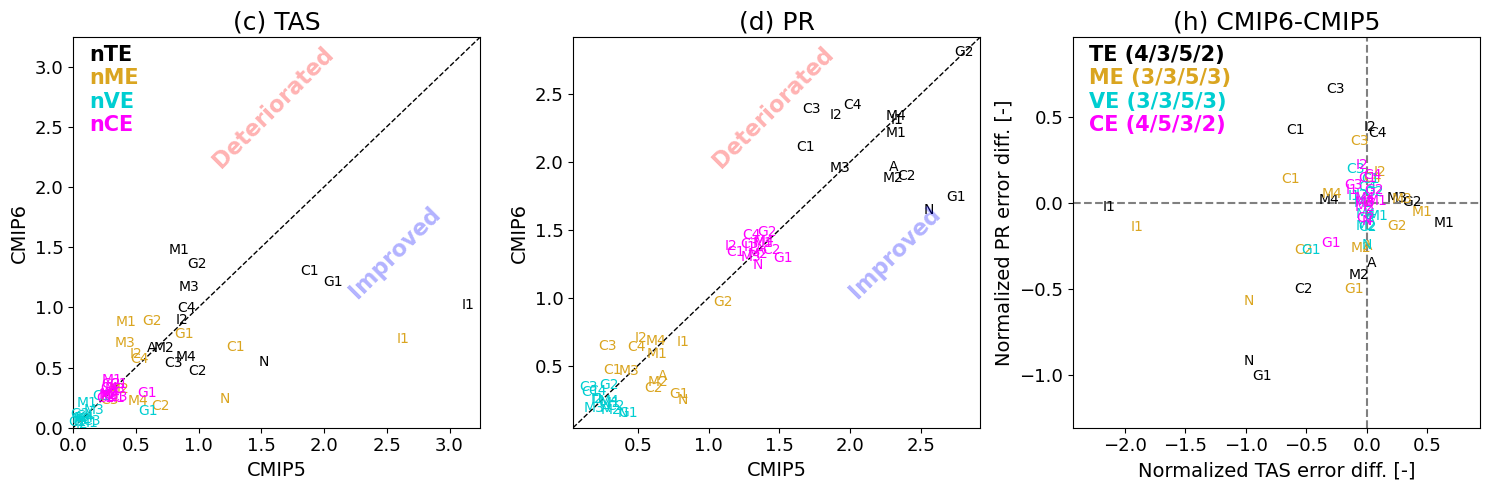

In [50]:
fname="./fig/scatter_norm.png"
label1 = ['CMIP5','CMIP6']
label2 = ['CMIP5','CMIP6']
label3 = ['Normalized TAS error diff. [-]','Normalized PR error diff. [-]']
# colors = ["black","red","blue","green"]
colors = ['black','goldenrod','darkturquoise','magenta']

gm = gm1
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
for c,col in enumerate(colors):
    x = gm.isel(vars=0,mips=0,scores=c)
    y = gm.isel(vars=0,mips=1,scores=c)
    # ax.scatter(x, y, s=20, facecolors=col, marker='o', edgecolors='w', alpha=0.)
    for n,name in enumerate(cname):
        ax.text(x[n], y[n], name, color=col, va='center', ha='center')
        
    
add_identity(ax, color='black', linestyle='--',linewidth=1.0)
ax.set_title('(c) TAS',fontsize=18)
ax.tick_params(labelsize=13)
ax.set_xlabel('{}'.format(label1[0]),fontsize=14)
ax.set_ylabel('{}'.format(label1[1]),fontsize=14)
rmin = gm.isel(vars=0)[:2,:,:].min()
rmax = gm.isel(vars=0)[:2,:,:].max()
rd = rmax-rmin
ax.set_xlim([0, rmax+rd*0.03])
ax.set_ylim([0, rmax+rd*0.03])

ax.text(0.04, 0.94,'nTE', color='black', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.88,'nME', color='goldenrod', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.82,'nVE', color='darkturquoise', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.76,'nCE', color='magenta', transform=ax.transAxes, fontsize=15, weight='bold')

ax.text(1/3, 2/3, 'Deteriorated', color='red', transform=ax.transAxes, fontsize=16, weight='bold', alpha=0.3, rotation=45)
ax.text(2/3, 1/3, 'Improved', color='blue', transform=ax.transAxes, fontsize=16, weight='bold', alpha=0.3, rotation=45)

ax = fig.add_subplot(132)
# vars: 2mips: 3models: 14scores: 4
for c,col in enumerate(colors):
    x = gm.isel(vars=1,mips=0,scores=c)
    y = gm.isel(vars=1,mips=1,scores=c)
    # ax.scatter(x, y, s=20, facecolors=col, marker='o', edgecolors='w', alpha=0.)
    for n,name in enumerate(cname):
        ax.text(x[n], y[n], name, color=col, va='center', ha='center')
        
add_identity(ax, color='black', linestyle='--',linewidth=1.0)    
ax.set_title('(d) PR',fontsize=18)
ax.tick_params(labelsize=13)
ax.set_xlabel('{}'.format(label2[0]),fontsize=14)
ax.set_ylabel('{}'.format(label2[1]),fontsize=14)
rmin = gm.isel(vars=1)[:2,:,:].min()
rmax = gm.isel(vars=1)[:2,:,:].max()
rd = rmax-rmin
ax.set_xlim([rmin-rd*0.04, rmax+rd*0.04])
ax.set_ylim([rmin-rd*0.04, rmax+rd*0.04])

ax.text(1/3, 2/3, 'Deteriorated', color='red', transform=ax.transAxes, fontsize=16, weight='bold', alpha=0.3, rotation=45)
ax.text(2/3, 1/3, 'Improved', color='blue', transform=ax.transAxes, fontsize=16, weight='bold', alpha=0.3, rotation=45)

ax = fig.add_subplot(133)
# vars: 2mips: 3models: 14scores: 4
for c,col in enumerate(colors):
    x = gm.isel(vars=0,mips=1,scores=c) - gm.isel(vars=0,mips=0,scores=c)
    y = gm.isel(vars=1,mips=1,scores=c) - gm.isel(vars=1,mips=0,scores=c)
    # ax.scatter(x, y, s=20, facecolors=col, marker='o', edgecolors='w', alpha=0.)
    
    m, b = np.polyfit(x,y, deg=1)
    corr = xr.corr(x,y, dim='models')
    pval = xs.pearson_r_p_value(x,y, dim='models')
    print(m, corr.values, pval.values)
    for n,name in enumerate(cname):
        ax.text(x[n], y[n], name, color=col, va='center', ha='center')

ax.text(0.04, 0.94,'TE (4/3/5/2)', color='black', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.88,'ME (3/3/5/3)', color='goldenrod', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.82,'VE (3/3/5/3)', color='darkturquoise', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.76,'CE (4/5/3/2)', color='magenta', transform=ax.transAxes, fontsize=15, weight='bold')
# m, b = np.polyfit(SON_t_gyr_an['year'],SON_t_gyr_an, deg=1)
# plt.plot(SON_t_gyr_an['year'], m * SON_t_gyr_an['year'] + b, color='orange', linestyle='--', linewidth=2)
# pr_trd[0,:,:] = pr_yr.polyfit(dim='time',deg=1)['polyfit_coefficients'].isel(degree=0)
# pr_trd[1,:,:] = xs.pearson_r_p_value(pr_yr.time, pr_yr, dim='time')
# pr_trd[2,:,:] = xr.corr(pr_yr.time, pr_yr, dim='time')
        
ax.axhline(y=0., color='gray', linestyle='--')
ax.axvline(x=0., color='gray', linestyle='--')
ax.set_title('(h) CMIP6-CMIP5',fontsize=18)#, weight='bold')
ax.tick_params(labelsize=13)
ax.set_xlabel('{}'.format(label3[0]),fontsize=14)
ax.set_ylabel('{}'.format(label3[1]),fontsize=14)
rmin = gm.isel(vars=0)[2,:,:].min()
rmax = gm.isel(vars=1)[2,:,:].max()
rd = rmax-rmin
ax.set_xlim([gm.isel(vars=0)[2,:,:].min()-0.3, gm.isel(vars=0)[2,:,:].max()+0.3])
ax.set_ylim([gm.isel(vars=1)[2,:,:].min()-0.3, gm.isel(vars=1)[2,:,:].max()+0.3])

fig.tight_layout()
# plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

# for c in range(4):
#     x = gm.isel(vars=0,mips=1,scores=c) - gm.isel(vars=0,mips=0,scores=c)
#     y = gm.isel(vars=1,mips=1,scores=c) - gm.isel(vars=1,mips=0,scores=c)
#     n1 = (x>0) & (y>0)
#     n2 = (x<0) & (y>0)
#     n3 = (x<0) & (y<0)
#     n4 = (x>0) & (y<0)
#     print(n1.sum().item(), n2.sum().item(), n3.sum().item(), n4.sum().item())

-0.023221309170065044 -0.09836519106318928 0.7379668821649705
-0.01426342264561077 -0.08761936954281148 0.7658187083184607
-0.048236671256432724 -0.1525814267644614 0.6025437502264601
0.04557137975611004 0.11809843811737497 0.6876121574510845


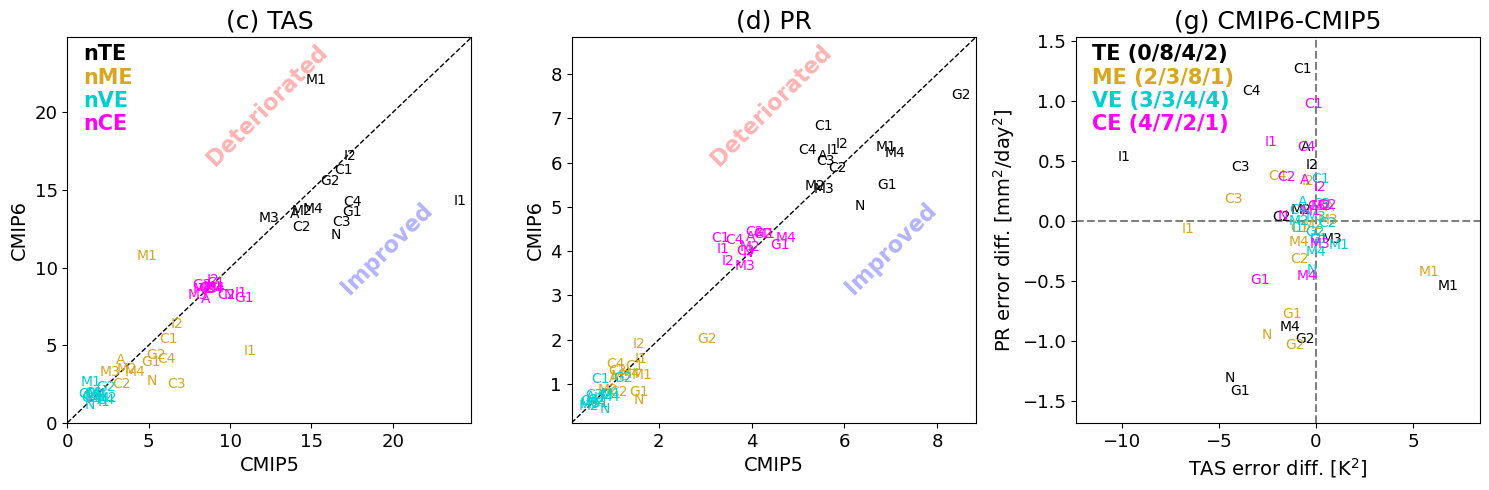

In [51]:
fname="./fig/scatter.png"
label1 = ['CMIP5','CMIP6']
label2 = ['CMIP5','CMIP6']
label3 = ['TAS error diff. [K$^2$]','PR error diff. [mm$^2$/day$^2$]']
# colors = ["black","red","blue","green"]
colors = ['black','goldenrod','darkturquoise','magenta']

gm = gm2
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
for c,col in enumerate(colors):
    x = gm.isel(vars=0,mips=0,scores=c)
    y = gm.isel(vars=0,mips=1,scores=c)
    # ax.scatter(x, y, s=20, facecolors=col, marker='o', edgecolors='w', alpha=0.)
    for n,name in enumerate(cname):
        ax.text(x[n], y[n], name, color=col, va='center', ha='center')
        
    
add_identity(ax, color='black', linestyle='--',linewidth=1.0)
ax.set_title('(c) TAS',fontsize=18)
ax.tick_params(labelsize=13)
ax.set_xlabel('{}'.format(label1[0]),fontsize=14)
ax.set_ylabel('{}'.format(label1[1]),fontsize=14)
rmin = gm.isel(vars=0)[:2,:,:].min()
rmax = gm.isel(vars=0)[:2,:,:].max()
rd = rmax-rmin
ax.set_xlim([0, rmax+rd*0.03])
ax.set_ylim([0, rmax+rd*0.03])

ax.text(0.04, 0.94,'nTE', color='black', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.88,'nME', color='goldenrod', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.82,'nVE', color='darkturquoise', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.76,'nCE', color='magenta', transform=ax.transAxes, fontsize=15, weight='bold')

ax.text(1/3, 2/3, 'Deteriorated', color='red', transform=ax.transAxes, fontsize=16, weight='bold', alpha=0.3, rotation=45)
ax.text(2/3, 1/3, 'Improved', color='blue', transform=ax.transAxes, fontsize=16, weight='bold', alpha=0.3, rotation=45)

ax = fig.add_subplot(132)
# vars: 2mips: 3models: 14scores: 4
for c,col in enumerate(colors):
    x = gm.isel(vars=1,mips=0,scores=c)
    y = gm.isel(vars=1,mips=1,scores=c)
    # ax.scatter(x, y, s=20, facecolors=col, marker='o', edgecolors='w', alpha=0.)
    for n,name in enumerate(cname):
        ax.text(x[n], y[n], name, color=col, va='center', ha='center')
        
add_identity(ax, color='black', linestyle='--',linewidth=1.0)    
ax.set_title('(d) PR',fontsize=18)
ax.tick_params(labelsize=13)
ax.set_xlabel('{}'.format(label2[0]),fontsize=14)
ax.set_ylabel('{}'.format(label2[1]),fontsize=14)
rmin = gm.isel(vars=1)[:2,:,:].min()
rmax = gm.isel(vars=1)[:2,:,:].max()
rd = rmax-rmin
ax.set_xlim([rmin-rd*0.04, rmax+rd*0.04])
ax.set_ylim([rmin-rd*0.04, rmax+rd*0.04])

ax.text(1/3, 2/3, 'Deteriorated', color='red', transform=ax.transAxes, fontsize=16, weight='bold', alpha=0.3, rotation=45)
ax.text(2/3, 1/3, 'Improved', color='blue', transform=ax.transAxes, fontsize=16, weight='bold', alpha=0.3, rotation=45)

ax = fig.add_subplot(133)
# vars: 2mips: 3models: 14scores: 4
for c,col in enumerate(colors):
    x = gm.isel(vars=0,mips=1,scores=c) - gm.isel(vars=0,mips=0,scores=c)
    y = gm.isel(vars=1,mips=1,scores=c) - gm.isel(vars=1,mips=0,scores=c)
    # ax.scatter(x, y, s=20, facecolors=col, marker='o', edgecolors='w', alpha=0.)
    
    m, b = np.polyfit(x,y, deg=1)
    corr = xr.corr(x,y, dim='models')
    pval = xs.pearson_r_p_value(x,y, dim='models')
    print(m, corr.values, pval.values)
    for n,name in enumerate(cname):
        ax.text(x[n], y[n], name, color=col, va='center', ha='center')

ax.text(0.04, 0.94,'TE (0/8/4/2)', color='black', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.88,'ME (2/3/8/1)', color='goldenrod', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.82,'VE (3/3/4/4)', color='darkturquoise', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.76,'CE (4/7/2/1)', color='magenta', transform=ax.transAxes, fontsize=15, weight='bold')
# m, b = np.polyfit(SON_t_gyr_an['year'],SON_t_gyr_an, deg=1)
# plt.plot(SON_t_gyr_an['year'], m * SON_t_gyr_an['year'] + b, color='orange', linestyle='--', linewidth=2)
# pr_trd[0,:,:] = pr_yr.polyfit(dim='time',deg=1)['polyfit_coefficients'].isel(degree=0)
# pr_trd[1,:,:] = xs.pearson_r_p_value(pr_yr.time, pr_yr, dim='time')
# pr_trd[2,:,:] = xr.corr(pr_yr.time, pr_yr, dim='time')

ax.axhline(y=0., color='gray', linestyle='--')
ax.axvline(x=0., color='gray', linestyle='--')
ax.set_title('(g) CMIP6-CMIP5',fontsize=18)#, weight='bold')
ax.tick_params(labelsize=13)
ax.set_xlabel('{}'.format(label3[0]),fontsize=14)
ax.set_ylabel('{}'.format(label3[1]),fontsize=14)
rmin = gm.isel(vars=0)[2,:,:].min()
rmax = gm.isel(vars=1)[2,:,:].max()
rd = rmax-rmin
rgx = gm.isel(vars=0)[2,:,:].max() - gm.isel(vars=0)[2,:,:].min()
rgy = gm.isel(vars=1)[2,:,:].max() - gm.isel(vars=1)[2,:,:].min()
ax.set_xlim([gm.isel(vars=0)[2,:,:].min()-rgx*0.15, gm.isel(vars=0)[2,:,:].max()+rgx*0.1])
ax.set_ylim([gm.isel(vars=1)[2,:,:].min()-rgy*0.1, gm.isel(vars=1)[2,:,:].max()+rgy*0.1])

fig.tight_layout()
# plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

# for c in range(4):
#     x = gm.isel(vars=0,mips=1,scores=c) - gm.isel(vars=0,mips=0,scores=c)
#     y = gm.isel(vars=1,mips=1,scores=c) - gm.isel(vars=1,mips=0,scores=c)
#     n1 = (x>0) & (y>0)
#     n2 = (x<0) & (y>0)
#     n3 = (x<0) & (y<0)
#     n4 = (x>0) & (y<0)
#     print(n1.sum().item(), n2.sum().item(), n3.sum().item(), n4.sum().item())

0.16420850075186122 0.8569958359086649 9.008186098903994e-05
0.16054585821971423 0.7201971990354443 0.0036723704236537335
0.014177340811419392 0.06478400042315256 0.8258482462478648
0.06012116092263787 0.6639399416773554 0.00961465699496847


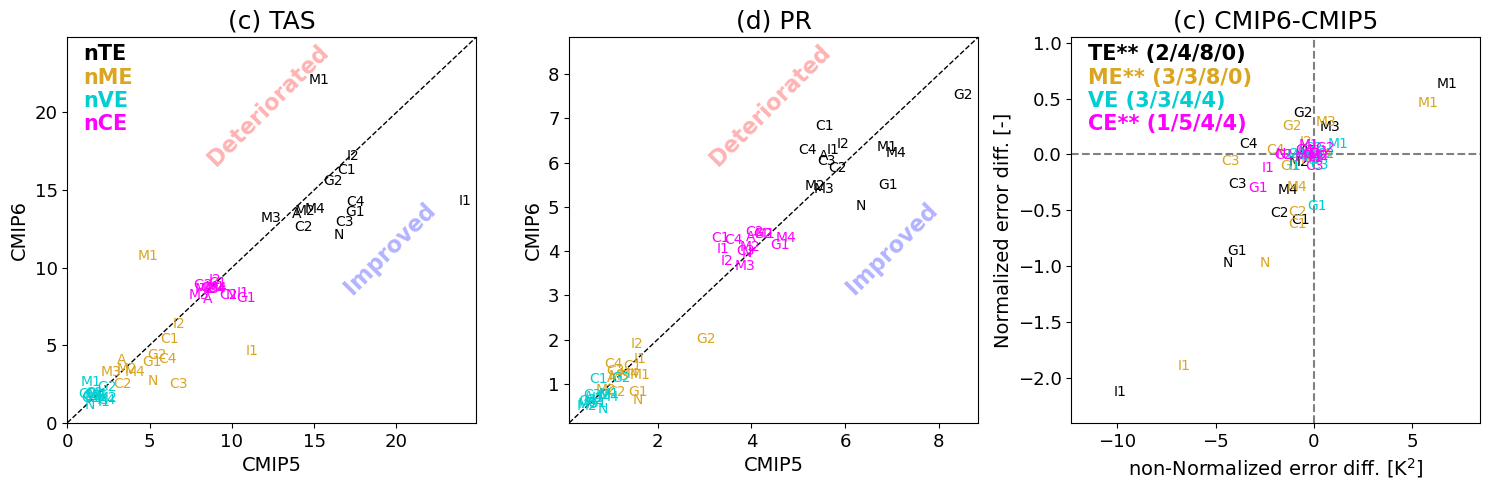

In [52]:
fname="./fig/scatter_temp.png"
label1 = ['CMIP5','CMIP6']
label2 = ['CMIP5','CMIP6']
label3 = ['non-Normalized error diff. [K$^2$]','Normalized error diff. [-]']
# colors = ["black","red","blue","green"]
colors = ['black','goldenrod','darkturquoise','magenta']

gm = gm2
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
for c,col in enumerate(colors):
    x = gm.isel(vars=0,mips=0,scores=c)
    y = gm.isel(vars=0,mips=1,scores=c)
    # ax.scatter(x, y, s=20, facecolors=col, marker='o', edgecolors='w', alpha=0.)
    for n,name in enumerate(cname):
        ax.text(x[n], y[n], name, color=col, va='center', ha='center')
        
    
add_identity(ax, color='black', linestyle='--',linewidth=1.0)
ax.set_title('(c) TAS',fontsize=18)
ax.tick_params(labelsize=13)
ax.set_xlabel('{}'.format(label1[0]),fontsize=14)
ax.set_ylabel('{}'.format(label1[1]),fontsize=14)
rmin = gm.isel(vars=0)[:2,:,:].min()
rmax = gm.isel(vars=0)[:2,:,:].max()
rd = rmax-rmin
ax.set_xlim([0, rmax+rd*0.03])
ax.set_ylim([0, rmax+rd*0.03])

ax.text(0.04, 0.94,'nTE', color='black', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.88,'nME', color='goldenrod', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.82,'nVE', color='darkturquoise', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.76,'nCE', color='magenta', transform=ax.transAxes, fontsize=15, weight='bold')

ax.text(1/3, 2/3, 'Deteriorated', color='red', transform=ax.transAxes, fontsize=16, weight='bold', alpha=0.3, rotation=45)
ax.text(2/3, 1/3, 'Improved', color='blue', transform=ax.transAxes, fontsize=16, weight='bold', alpha=0.3, rotation=45)

ax = fig.add_subplot(132)
# vars: 2mips: 3models: 14scores: 4
for c,col in enumerate(colors):
    x = gm.isel(vars=1,mips=0,scores=c)
    y = gm.isel(vars=1,mips=1,scores=c)
    # ax.scatter(x, y, s=20, facecolors=col, marker='o', edgecolors='w', alpha=0.)
    for n,name in enumerate(cname):
        ax.text(x[n], y[n], name, color=col, va='center', ha='center')
        
add_identity(ax, color='black', linestyle='--',linewidth=1.0)    
ax.set_title('(d) PR',fontsize=18)
ax.tick_params(labelsize=13)
ax.set_xlabel('{}'.format(label2[0]),fontsize=14)
ax.set_ylabel('{}'.format(label2[1]),fontsize=14)
rmin = gm.isel(vars=1)[:2,:,:].min()
rmax = gm.isel(vars=1)[:2,:,:].max()
rd = rmax-rmin
ax.set_xlim([rmin-rd*0.04, rmax+rd*0.04])
ax.set_ylim([rmin-rd*0.04, rmax+rd*0.04])

ax.text(1/3, 2/3, 'Deteriorated', color='red', transform=ax.transAxes, fontsize=16, weight='bold', alpha=0.3, rotation=45)
ax.text(2/3, 1/3, 'Improved', color='blue', transform=ax.transAxes, fontsize=16, weight='bold', alpha=0.3, rotation=45)

ax = fig.add_subplot(133)
# vars: 2mips: 3models: 14scores: 4
for c,col in enumerate(colors):
    x = gm2.isel(vars=0,mips=1,scores=c) - gm2.isel(vars=0,mips=0,scores=c)
    y = gm1.isel(vars=0,mips=1,scores=c) - gm1.isel(vars=0,mips=0,scores=c)
    # ax.scatter(x, y, s=20, facecolors=col, marker='o', edgecolors='w', alpha=0.)
    
    m, b = np.polyfit(x,y, deg=1)
    corr = xr.corr(x,y, dim='models')
    pval = xs.pearson_r_p_value(x,y, dim='models')
    print(m, corr.values, pval.values)
    for n,name in enumerate(cname):
        ax.text(x[n], y[n], name, color=col, va='center', ha='center')

ax.text(0.04, 0.94,'TE** (2/4/8/0)', color='black', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.88,'ME** (3/3/8/0)', color='goldenrod', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.82,'VE (3/3/4/4)', color='darkturquoise', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.76,'CE** (1/5/4/4)', color='magenta', transform=ax.transAxes, fontsize=15, weight='bold')

ax.axhline(y=0., color='gray', linestyle='--')
ax.axvline(x=0., color='gray', linestyle='--')
ax.set_title('(c) CMIP6-CMIP5',fontsize=18)#, weight='bold')
ax.tick_params(labelsize=13)
ax.set_xlabel('{}'.format(label3[0]),fontsize=14)
ax.set_ylabel('{}'.format(label3[1]),fontsize=14)
rmin = gm.isel(vars=0)[2,:,:].min()
rmax = gm.isel(vars=1)[2,:,:].max()
rd = rmax-rmin
rgx = gm2.isel(vars=0)[2,:,:].max() - gm2.isel(vars=0)[2,:,:].min()
rgy = gm1.isel(vars=0)[2,:,:].max() - gm1.isel(vars=0)[2,:,:].min()
ax.set_xlim([gm2.isel(vars=0)[2,:,:].min()-rgx*0.15, gm2.isel(vars=0)[2,:,:].max()+rgx*0.1])
ax.set_ylim([gm1.isel(vars=0)[2,:,:].min()-rgy*0.1, gm1.isel(vars=0)[2,:,:].max()+rgy*0.15])

fig.tight_layout()
# plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

# for c in range(4):
#     x = gm2.isel(vars=0,mips=1,scores=c) - gm2.isel(vars=0,mips=0,scores=c)
#     y = gm1.isel(vars=0,mips=1,scores=c) - gm1.isel(vars=0,mips=0,scores=c)
#     n1 = (x>0) & (y>0)
#     n2 = (x<0) & (y>0)
#     n3 = (x<0) & (y<0)
#     n4 = (x>0) & (y<0)
#     print(n1.sum().item(), n2.sum().item(), n3.sum().item(), n4.sum().item())

0.395005478292814 0.6764957932595691 0.007890302010996188
0.4111587767991721 0.696090689191943 0.0056887728224482535
0.43508693676025895 0.6047121626480858 0.02196872539337233
0.17139302999549644 0.586656603460117 0.027435768584792238


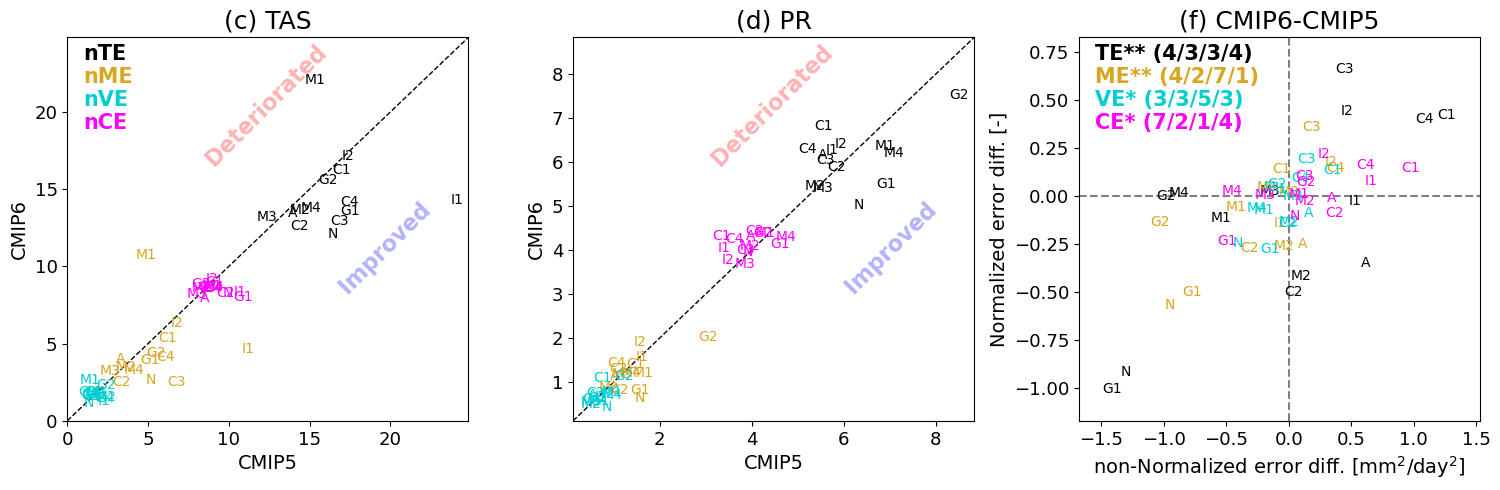

In [53]:
fname="./fig/scatter_pr.png"
label1 = ['CMIP5','CMIP6']
label2 = ['CMIP5','CMIP6']
label3 = ['non-Normalized error diff. [mm$^2$/day$^2$]','Normalized error diff. [-]']
# colors = ["black","red","blue","green"]
colors = ['black','goldenrod','darkturquoise','magenta']

gm = gm2
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
for c,col in enumerate(colors):
    x = gm.isel(vars=0,mips=0,scores=c)
    y = gm.isel(vars=0,mips=1,scores=c)
    # ax.scatter(x, y, s=20, facecolors=col, marker='o', edgecolors='w', alpha=0.)
    for n,name in enumerate(cname):
        ax.text(x[n], y[n], name, color=col, va='center', ha='center')
        
    
add_identity(ax, color='black', linestyle='--',linewidth=1.0)
ax.set_title('(c) TAS',fontsize=18)
ax.tick_params(labelsize=13)
ax.set_xlabel('{}'.format(label1[0]),fontsize=14)
ax.set_ylabel('{}'.format(label1[1]),fontsize=14)
rmin = gm.isel(vars=0)[:2,:,:].min()
rmax = gm.isel(vars=0)[:2,:,:].max()
rd = rmax-rmin
ax.set_xlim([0, rmax+rd*0.03])
ax.set_ylim([0, rmax+rd*0.03])

ax.text(0.04, 0.94,'nTE', color='black', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.88,'nME', color='goldenrod', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.82,'nVE', color='darkturquoise', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.76,'nCE', color='magenta', transform=ax.transAxes, fontsize=15, weight='bold')

ax.text(1/3, 2/3, 'Deteriorated', color='red', transform=ax.transAxes, fontsize=16, weight='bold', alpha=0.3, rotation=45)
ax.text(2/3, 1/3, 'Improved', color='blue', transform=ax.transAxes, fontsize=16, weight='bold', alpha=0.3, rotation=45)

ax = fig.add_subplot(132)
# vars: 2mips: 3models: 14scores: 4
for c,col in enumerate(colors):
    x = gm.isel(vars=1,mips=0,scores=c)
    y = gm.isel(vars=1,mips=1,scores=c)
    # ax.scatter(x, y, s=20, facecolors=col, marker='o', edgecolors='w', alpha=0.)
    for n,name in enumerate(cname):
        ax.text(x[n], y[n], name, color=col, va='center', ha='center')
        
add_identity(ax, color='black', linestyle='--',linewidth=1.0)    
ax.set_title('(d) PR',fontsize=18)
ax.tick_params(labelsize=13)
ax.set_xlabel('{}'.format(label2[0]),fontsize=14)
ax.set_ylabel('{}'.format(label2[1]),fontsize=14)
rmin = gm.isel(vars=1)[:2,:,:].min()
rmax = gm.isel(vars=1)[:2,:,:].max()
rd = rmax-rmin
ax.set_xlim([rmin-rd*0.04, rmax+rd*0.04])
ax.set_ylim([rmin-rd*0.04, rmax+rd*0.04])

ax.text(1/3, 2/3, 'Deteriorated', color='red', transform=ax.transAxes, fontsize=16, weight='bold', alpha=0.3, rotation=45)
ax.text(2/3, 1/3, 'Improved', color='blue', transform=ax.transAxes, fontsize=16, weight='bold', alpha=0.3, rotation=45)

ax = fig.add_subplot(133)
# vars: 2mips: 3models: 14scores: 4
for c,col in enumerate(colors):
    x = gm2.isel(vars=1,mips=1,scores=c) - gm2.isel(vars=1,mips=0,scores=c)
    y = gm1.isel(vars=1,mips=1,scores=c) - gm1.isel(vars=1,mips=0,scores=c)
    # ax.scatter(x, y, s=20, facecolors=col, marker='o', edgecolors='w', alpha=0.)
    
    m, b = np.polyfit(x,y, deg=1)
    corr = xr.corr(x,y, dim='models')
    pval = xs.pearson_r_p_value(x,y, dim='models')
    print(m, corr.values, pval.values)
    for n,name in enumerate(cname):
        ax.text(x[n], y[n], name, color=col, va='center', ha='center')

ax.text(0.04, 0.94,'TE** (4/3/3/4)', color='black', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.88,'ME** (4/2/7/1)', color='goldenrod', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.82,'VE* (3/3/5/3)', color='darkturquoise', transform=ax.transAxes, fontsize=15, weight='bold')
ax.text(0.04, 0.76,'CE* (7/2/1/4)', color='magenta', transform=ax.transAxes, fontsize=15, weight='bold')

ax.axhline(y=0., color='gray', linestyle='--')
ax.axvline(x=0., color='gray', linestyle='--')
ax.set_title('(f) CMIP6-CMIP5',fontsize=18)#, weight='bold')
ax.tick_params(labelsize=13)
ax.set_xlabel('{}'.format(label3[0]),fontsize=14)
ax.set_ylabel('{}'.format(label3[1]),fontsize=14)
rmin = gm.isel(vars=0)[2,:,:].min()
rmax = gm.isel(vars=1)[2,:,:].max()
rd = rmax-rmin
rgx = gm2.isel(vars=1)[2,:,:].max() - gm2.isel(vars=1)[2,:,:].min()
rgy = gm1.isel(vars=1)[2,:,:].max() - gm1.isel(vars=1)[2,:,:].min()
ax.set_xlim([gm2.isel(vars=1)[2,:,:].min()-rgx*0.1, gm2.isel(vars=1)[2,:,:].max()+rgx*0.1])
ax.set_ylim([gm1.isel(vars=1)[2,:,:].min()-rgy*0.1, gm1.isel(vars=1)[2,:,:].max()+rgy*0.1])

fig.tight_layout()
# plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

# for c in range(4):
#     x = gm2.isel(vars=1,mips=1,scores=c) - gm2.isel(vars=1,mips=0,scores=c)
#     y = gm1.isel(vars=1,mips=1,scores=c) - gm1.isel(vars=1,mips=0,scores=c)
#     n1 = (x>0) & (y>0)
#     n2 = (x<0) & (y>0)
#     n3 = (x<0) & (y<0)
#     n4 = (x>0) & (y<0)
#     print(n1.sum().item(), n2.sum().item(), n3.sum().item(), n4.sum().item())

# Fig. 4 (chiclet diagrams)

In [54]:
cmip5_name = ['ACCESS1-0','CanESM2','CCSM4','CMCC-CM','CNRM-CM5',
              'GFDL-CM2.1','GISS-E2-H','INM-CM4-0','IPSL-CM5A-LR','MIROC5',
              'HadGEM2-AO','MPI-ESM-LR','MRI-ESM1','NorESM1-M']
cmip6_name = ['ACCESS-CM2','CanESM5','CESM2-WACCM','CMCC-CM2-HR4','CNRM-ESM2-1',
              'GFDL-CM4','GISS-E2-1-H','INM-CM5-0','IPSL-CM6A-LR','MIROC6',
              'HadGEM3-GC31-LL','MPI-ESM1-2-LR','MRI-ESM2-0','NorESM2-MM']
cname = ['A','C1','C2','C3','C4',
         'G1','G2','I1','I2','M1',
         'M2','M3','M4','N']
cname2 = ['ACCESS','CanESM','CESM','CMCC','CNRM',
         'GFDL','GISS','INM','IPSL','MIROC',
         'HadGEM','MPI','MRI','NorESM']

0 1


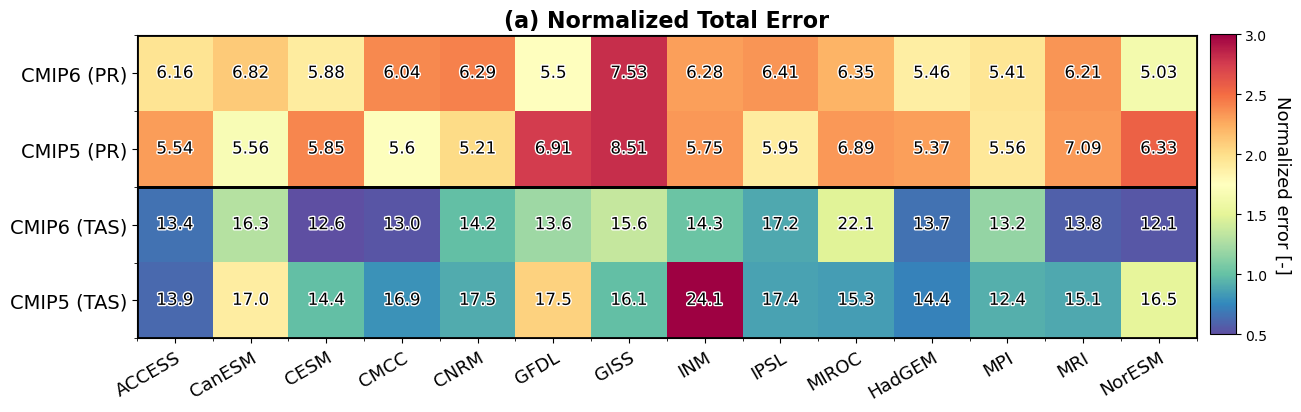

In [56]:
from sklearn import preprocessing
from scipy import special
from matplotlib.patches import Rectangle
import matplotlib.patheffects as path_effects

rows, cols = 4, 14
width, height = 1, 1

ycom = ['CMIP5 (TAS)','CMIP6 (TAS)','CMIP5 (PR)','CMIP6 (PR)'] # y-axis
xcom = cname2 # x-axis
fname="./fig/TE_score.png"

# gm1 [vars: 2, mips: 3, models: 14, scores: 4]
colr = np.empty([len(ycom),len(xcom)]) * np.nan # [y,x] color shading
colr[0,:] = gm1[0,0,:,0]
colr[1,:] = gm1[0,1,:,0]
colr[2,:] = gm1[1,0,:,0]
colr[3,:] = gm1[1,1,:,0]

txt = np.empty([len(ycom),len(xcom)]) * np.nan # [y,x] text annotation
txt[0,:] = gm2[0,0,:,0]
txt[1,:] = gm2[0,1,:,0]
txt[2,:] = gm2[1,0,:,0]
txt[3,:] = gm2[1,1,:,0]


fig, ax = plt.subplots(1,1,figsize=(13,5))
im = ax.imshow(colr, cmap='Spectral_r', vmin=0.5, vmax=3.)

# Minor ticks
ax.set_xticks(np.arange(-.5, len(xcom), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(ycom), 1), minor=True)

# Gridlines based on minor ticks
# ax.grid(which='minor', color='k', linestyle='-', linewidth=2)
ax.add_patch(Rectangle((-0.5, -0.5), 14, 2, fill=False, edgecolor='black', linewidth=2, alpha=1.0))
ax.add_patch(Rectangle((-0.5, 1.5), 14, 2, fill=False, edgecolor='black', linewidth=2, alpha=1.0))

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(xcom)))
ax.set_yticks(np.arange(len(ycom)))
ax.set_xticklabels(xcom,fontsize=13)
ax.set_yticklabels(ycom,fontsize=14)

err5 = np.sum(colr[0:2,:],axis=(0))
err6 = np.sum(colr[2:,:],axis=(0))
print(err5.argmin(),err6.argmin())

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(ycom)):
    for j in range(len(xcom)):
        if i<2:
            text = ax.text(j, i, "{}".format(round(txt[i, j],1)),
                           ha="center", va="center", color="black",fontsize=12)
        else:
            text = ax.text(j, i, "{}".format(round(txt[i, j],2)),
                           ha="center", va="center", color="black",fontsize=12)
        text.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='white'),
                path_effects.Normal()
            ])

# ax.set_title("UFS PT Evaluation ({})".format(season),fontsize=15)
ax.set_title("(a) Normalized Total Error",fontsize=16, weight='bold')
ax.set_xlim(-0.5, cols-0.5)
ax.set_ylim(-0.5, rows-0.5)
ax.set_aspect('equal')

# Create colorbar
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.set_ylabel("Normalized error [-]", rotation=-90, va="bottom",fontsize=13)
   
# fig.tight_layout()
# plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

In [57]:
# gm2  = map2.mean(dim= ('lon', 'lat'))
# gsm2 = smap2.mean(dim= ('lon', 'lat'))
sig2 = gsm2/abs(gsm2)

gm22 = gm2.copy(deep=True)
gm22[:,:,:,1] = gm2[:,:,:,1] * sig2[:,:,:,0]
gm22[:,:,:,2] = gm2[:,:,:,2] * sig2[:,:,:,1]

In [58]:
sig4 = gsm4/abs(gsm4)

gm42 = gm4.copy(deep=True)
gm42[:,:,1] = gm4[:,:,1] * sig4[:,:,0]
gm42[:,:,2] = gm4[:,:,2] * sig4[:,:,1]

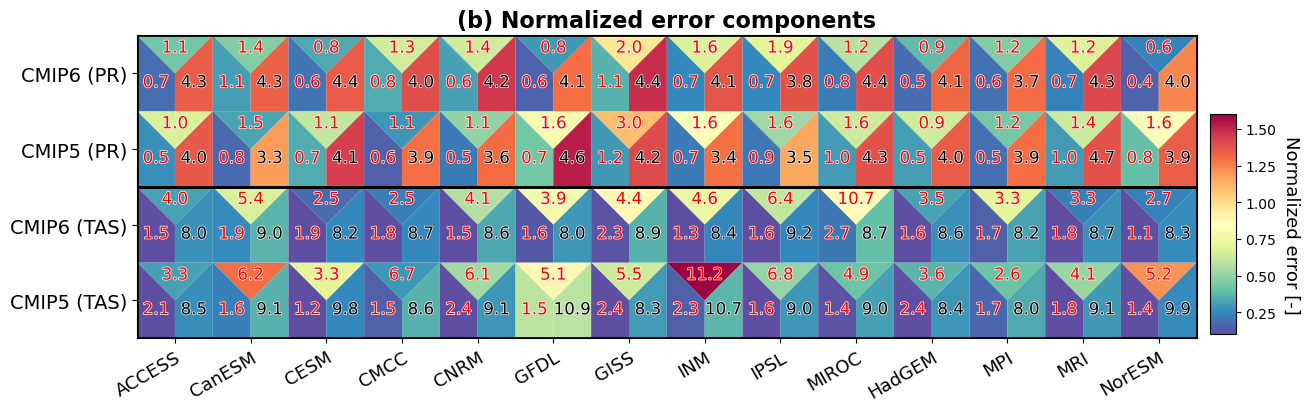

In [75]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import matplotlib as mpl
import matplotlib.patheffects as path_effects

fname="./fig/com_score.png"
fig, ax = plt.subplots(1,1,figsize=(13,5))

ycom = ['CMIP5 (TAS)','CMIP6 (TAS)','CMIP5 (PR)','CMIP6 (PR)'] # y-axis
xcom = cname2 # x-axis

rows, cols = 4, 14
width, height = 1, 1


colr = np.empty([len(ycom),cols,3]) * np.nan # [y,x] color shading
colr[0,:,:] = gm1[0,0,:,1:]
colr[1,:,:] = gm1[0,1,:,1:]
colr[2,:,:] = gm1[1,0,:,1:]
colr[3,:,:] = gm1[1,1,:,1:]

txt = np.empty([len(ycom),cols,3]) * np.nan # [y,x] text annotation
txt[0,:,:] = gm2[0,0,:,1:]
txt[1,:,:] = gm2[0,1,:,1:]
txt[2,:,:] = gm2[1,0,:,1:]
txt[3,:,:] = gm2[1,1,:,1:]

# color map
cmap = plt.get_cmap("Spectral_r")
# norm = mpl.colors.Normalize(vmin=colr.min(), vmax=colr.max())
norm = mpl.colors.Normalize(vmin=0.1, vmax=1.6)

for row in range(rows):
    for col in range(cols):
        x0, y0 = col * width, row * height
        rect = [(x0, y0), (x0 + width, y0), (x0 + width, y0 + height), (x0, y0 + height)]
        center = (x0 + width / 2, y0 + height / 2)

        top_triangle = [rect[3], rect[2], center]
        bottom_left_rect = [rect[0], (center[0], y0), center, rect[3]]
        bottom_right_rect = [(center[0], y0), rect[1], rect[2], center]

        cell_data = colr[row, col]
        cell_data2 = txt[row, col]
        colors = [cmap(norm(value)) for value in cell_data]
        
        cnt = 0
        for part, color, value in zip([top_triangle, bottom_left_rect, bottom_right_rect], colors, cell_data2):
            # poly = Polygon(part, closed=True, edgecolor='black', facecolor=color)
            poly = Polygon(part, closed=True, facecolor=color)
            ax.add_patch(poly)
            centroid = np.mean(part, axis=0)
            if value>0 and cnt!=2:
                text = ax.text(centroid[0], centroid[1], f'{abs(value):.1f}', ha='center', va='center', fontsize=12, color='red')
            elif value<0 and cnt!=2:
                text = ax.text(centroid[0], centroid[1], f'{abs(value):.1f}', ha='center', va='center', fontsize=12, color='aqua')
            else:
                text = ax.text(centroid[0], centroid[1], f'{abs(value):.1f}', ha='center', va='center', fontsize=12, color='black')
            cnt += 1

            text.set_path_effects([
                path_effects.Stroke(linewidth=1, foreground='white'),
                path_effects.Normal()
            ])

# X, Y labels 
ax.set_xticks(np.arange(cols) + 0.5)
ax.set_xticklabels(xcom,fontsize=13)
ax.set_yticks(np.arange(rows) + 0.5)
ax.set_yticklabels(ycom,fontsize=14)

plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
         rotation_mode="anchor")

ax.add_patch(Rectangle((0, 0), 14, 2, fill=False, edgecolor='black', linewidth=2, alpha=1.0))
ax.add_patch(Rectangle((0, 2), 14, 2, fill=False, edgecolor='black', linewidth=2, alpha=1.0))

ax.set_title("(b) Normalized error components",fontsize=16, weight='bold')
ax.set_xlim(0, cols)
ax.set_ylim(0, rows)
ax.set_aspect('equal')

fig.subplots_adjust(right=0.94)
# cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.44])
im = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.set_ylabel("Normalized error [-]", rotation=-90, va="bottom",fontsize=13)

# plt.tight_layout()
# plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

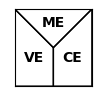

In [62]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np

fname="./fig/com_score_ref.png"
fig, ax = plt.subplots(figsize=(1, 1))

rows, cols = 1, 1
width, height = 1, 1
labels = ['ME', 'VE', 'CE']

for row in range(rows):
    for col in range(cols):
        x0, y0 = col * width, row * height
        rect = [(x0, y0), (x0 + width, y0), (x0 + width, y0 + height), (x0, y0 + height)]
        center = (x0 + width / 2, y0 + height / 2)

        top_triangle = [rect[3], rect[2], center]
        bottom_left_rect = [rect[0], (center[0], y0), center, rect[3]]
        bottom_right_rect = [(center[0], y0), rect[1], rect[2], center]

        for part, label in zip([top_triangle, bottom_left_rect, bottom_right_rect], labels):
            poly = Polygon(part, closed=True, edgecolor='black', facecolor='none')
            ax.add_patch(poly)
            centroid = np.mean(part, axis=0)
            ax.text(centroid[0], centroid[1], label, ha='center', va='center', fontsize=10, weight='bold')

ax.set_xlim(0, cols)
ax.set_ylim(0, rows)
ax.set_aspect('equal')

# x, y 축 레이블 제거
ax.set_xticks([])
ax.set_yticks([])

# plt.tight_layout()
# plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()


14 14


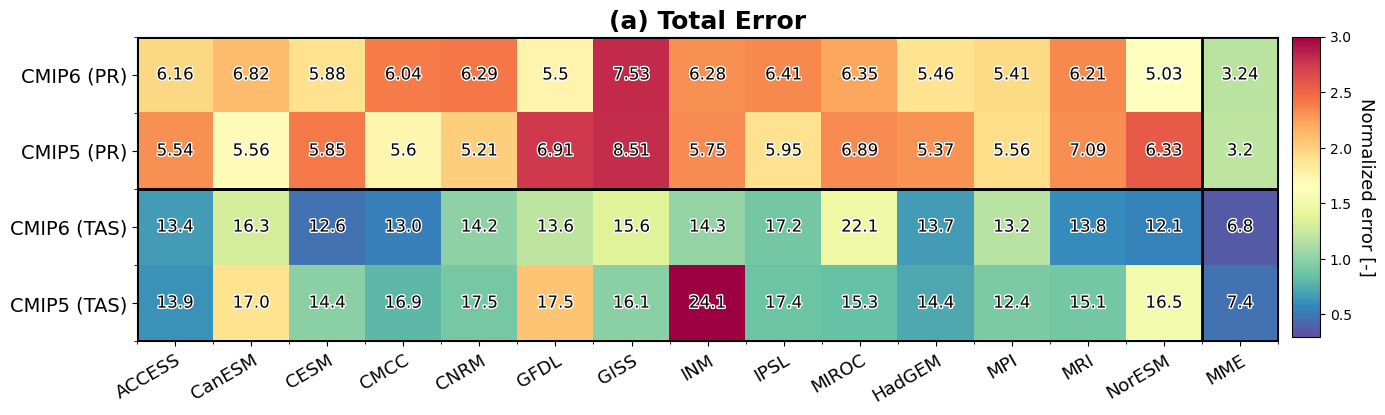

In [64]:
from sklearn import preprocessing
from scipy import special
from matplotlib.patches import Rectangle
import matplotlib.patheffects as path_effects


ycom = ['CMIP5 (TAS)','CMIP6 (TAS)','CMIP5 (PR)','CMIP6 (PR)'] # y-axis
xcom = cname2  + ['MME'] # x-axis
fname="./fig/TE_score_mme.png"

# gm1 [vars: 2, mips: 3, models: 14, scores: 4]
colr = np.empty([len(ycom),len(xcom)]) * np.nan # [y,x] color shading
colr[0,:len(xcom)-1] = gm1[0,0,:,0]
colr[1,:len(xcom)-1] = gm1[0,1,:,0]
colr[2,:len(xcom)-1] = gm1[1,0,:,0]
colr[3,:len(xcom)-1] = gm1[1,1,:,0]
colr[0,len(xcom)-1] = gm3[0,0,0]
colr[1,len(xcom)-1] = gm3[0,1,0]
colr[2,len(xcom)-1] = gm3[1,0,0]
colr[3,len(xcom)-1] = gm3[1,1,0]

txt = np.empty([len(ycom),len(xcom)]) * np.nan # [y,x] text annotation
txt[0,:len(xcom)-1] = gm2[0,0,:,0]
txt[1,:len(xcom)-1] = gm2[0,1,:,0]
txt[2,:len(xcom)-1] = gm2[1,0,:,0]
txt[3,:len(xcom)-1] = gm2[1,1,:,0]
txt[0,len(xcom)-1] = gm4[0,0,0]
txt[1,len(xcom)-1] = gm4[0,1,0]
txt[2,len(xcom)-1] = gm4[1,0,0]
txt[3,len(xcom)-1] = gm4[1,1,0]

fig, ax = plt.subplots(1,1,figsize=(14,5))
# im = ax.imshow(colr, cmap='bwr', vmin=0.5, vmax=3.)
im = ax.imshow(colr, cmap='Spectral_r', vmin=0.3, vmax=3.0)

# Minor ticks
ax.set_xticks(np.arange(-.5, len(xcom), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(ycom), 1), minor=True)

# Gridlines based on minor ticks
# ax.grid(which='minor', color='k', linestyle='-', linewidth=2)
ax.add_patch(Rectangle((-0.5, -0.5), len(xcom), 2, fill=False, edgecolor='black', linewidth=2, alpha=1.0))
ax.add_patch(Rectangle((-0.5, 1.5), len(xcom), 2, fill=False, edgecolor='black', linewidth=2, alpha=1.0))

ax.add_patch(Rectangle((-0.5, -0.5), len(xcom)-1, 2, fill=False, edgecolor='black', linewidth=2, alpha=1.0))
ax.add_patch(Rectangle((-0.5, 1.5), len(xcom)-1, 2, fill=False, edgecolor='black', linewidth=2, alpha=1.0))

# Hatching grid cell
# xx=list(range(len(ycom)))
# yy=list(range(len(ycom)))
# for v,var in enumerate(ycom):
#     xx[v] = colr[v,:].argmin()
#     ax.add_patch(Rectangle((xx[v]-0.5, yy[v]-0.5), 1, 1, fill=False, color='gray', hatch='/',alpha=0.7))

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(xcom)))
ax.set_yticks(np.arange(len(ycom)))
ax.set_xticklabels(xcom,fontsize=13)
ax.set_yticklabels(ycom,fontsize=14)

err5 = np.sum(colr[0:2,:],axis=(0))
err6 = np.sum(colr[2:,:],axis=(0))
print(err5.argmin(),err6.argmin())

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
         rotation_mode="anchor")


# Loop over data dimensions and create text annotations.
for i in range(len(ycom)):
    for j in range(len(xcom)):
        if i<2:
            text = ax.text(j, i, "{}".format(round(txt[i, j],1)),
                           ha="center", va="center", color="black",fontsize=12)
        else:
            text = ax.text(j, i, "{}".format(round(txt[i, j],2)),
                           ha="center", va="center", color="black",fontsize=12)
        text.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='white'),
                path_effects.Normal()
            ])

# ax.set_title("UFS PT Evaluation ({})".format(season),fontsize=15)
ax.set_title("(a) Total Error",fontsize=18, weight='bold')
ax.set_xlim(-0.5, len(xcom)-0.5)
ax.set_ylim(-0.5, len(ycom)-0.5)
ax.set_aspect('equal')

# Create colorbar
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.set_ylabel("Normalized error [-]", rotation=-90, va="bottom",fontsize=13)

   
# fig.tight_layout()
# plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

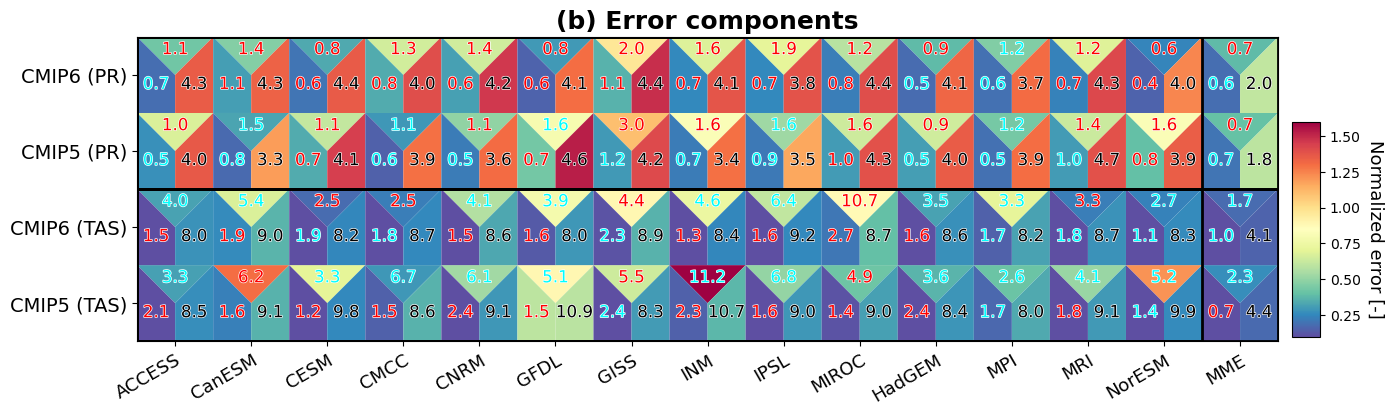

In [65]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import matplotlib as mpl
import matplotlib.patheffects as path_effects

fname="./fig/com_score_mme.png"
fig, ax = plt.subplots(1,1,figsize=(14,5))

rows, cols = 4, 15
width, height = 1, 1

colr = np.empty([len(ycom),len(xcom),3]) * np.nan # [y,x] color shading
colr[0,:len(xcom)-1,:] = gm1[0,0,:,1:]
colr[1,:len(xcom)-1,:] = gm1[0,1,:,1:]
colr[2,:len(xcom)-1,:] = gm1[1,0,:,1:]
colr[3,:len(xcom)-1,:] = gm1[1,1,:,1:]
colr[0,len(xcom)-1,:] = gm3[0,0,1:]
colr[1,len(xcom)-1,:] = gm3[0,1,1:]
colr[2,len(xcom)-1,:] = gm3[1,0,1:]
colr[3,len(xcom)-1,:] = gm3[1,1,1:]

txt = np.empty([len(ycom),len(xcom),3]) * np.nan # [y,x] text annotation
txt[0,:len(xcom)-1,:] = gm22[0,0,:,1:]
txt[1,:len(xcom)-1,:] = gm22[0,1,:,1:]
txt[2,:len(xcom)-1,:] = gm22[1,0,:,1:]
txt[3,:len(xcom)-1,:] = gm22[1,1,:,1:]
txt[0,len(xcom)-1,:] = gm42[0,0,1:]
txt[1,len(xcom)-1,:] = gm42[0,1,1:]
txt[2,len(xcom)-1,:] = gm42[1,0,1:]
txt[3,len(xcom)-1,:] = gm42[1,1,1:]

cmap = plt.get_cmap("Spectral_r")
# norm = mpl.colors.Normalize(vmin=colr.min(), vmax=colr.max())
norm = mpl.colors.Normalize(vmin=0.1, vmax=1.6)

for row in range(rows):
    for col in range(cols):
        x0, y0 = col * width, row * height
        rect = [(x0, y0), (x0 + width, y0), (x0 + width, y0 + height), (x0, y0 + height)]
        center = (x0 + width / 2, y0 + height / 2)

        top_triangle = [rect[3], rect[2], center]
        bottom_left_rect = [rect[0], (center[0], y0), center, rect[3]]
        bottom_right_rect = [(center[0], y0), rect[1], rect[2], center]

        cell_data = colr[row, col]
        cell_data2 = txt[row, col]
        colors = [cmap(norm(value)) for value in cell_data]
        
        cnt = 0
        for part, color, value in zip([top_triangle, bottom_left_rect, bottom_right_rect], colors, cell_data2):
            # poly = Polygon(part, closed=True, edgecolor='black', facecolor=color)
            poly = Polygon(part, closed=True, facecolor=color)
            ax.add_patch(poly)
            centroid = np.mean(part, axis=0)
            if value>0 and cnt!=2:
                text = ax.text(centroid[0], centroid[1], f'{abs(value):.1f}', ha='center', va='center', fontsize=12, color='red')
            elif value<0 and cnt!=2:
                text = ax.text(centroid[0], centroid[1], f'{abs(value):.1f}', ha='center', va='center', fontsize=12, color='aqua')
            else:
                text = ax.text(centroid[0], centroid[1], f'{abs(value):.1f}', ha='center', va='center', fontsize=12, color='black')
            cnt += 1

            text.set_path_effects([
                path_effects.Stroke(linewidth=1, foreground='white'),
                path_effects.Normal()
            ])

# X, Y labels 
ax.set_xticks(np.arange(cols) + 0.5)
ax.set_xticklabels(xcom,fontsize=13)
ax.set_yticks(np.arange(rows) + 0.5)
ax.set_yticklabels(ycom,fontsize=14)

plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
         rotation_mode="anchor")

ax.add_patch(Rectangle((0, 0), len(xcom), 2, fill=False, edgecolor='black', linewidth=2, alpha=1.0))
ax.add_patch(Rectangle((0, 2), len(xcom), 2, fill=False, edgecolor='black', linewidth=2, alpha=1.0))

ax.add_patch(Rectangle((0, 0), len(xcom)-1, 2, fill=False, edgecolor='black', linewidth=2, alpha=1.0))
ax.add_patch(Rectangle((0, 2), len(xcom)-1, 2, fill=False, edgecolor='black', linewidth=2, alpha=1.0))

ax.set_title("(b) Error components",fontsize=18, weight='bold')
ax.set_xlim(0, cols)
ax.set_ylim(0, rows)
ax.set_aspect('equal')


fig.subplots_adjust(right=0.94)
# cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.43])
im = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.set_ylabel("Normalized error [-]", rotation=-90, va="bottom",fontsize=13)

# plt.tight_layout()
# plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

15 15


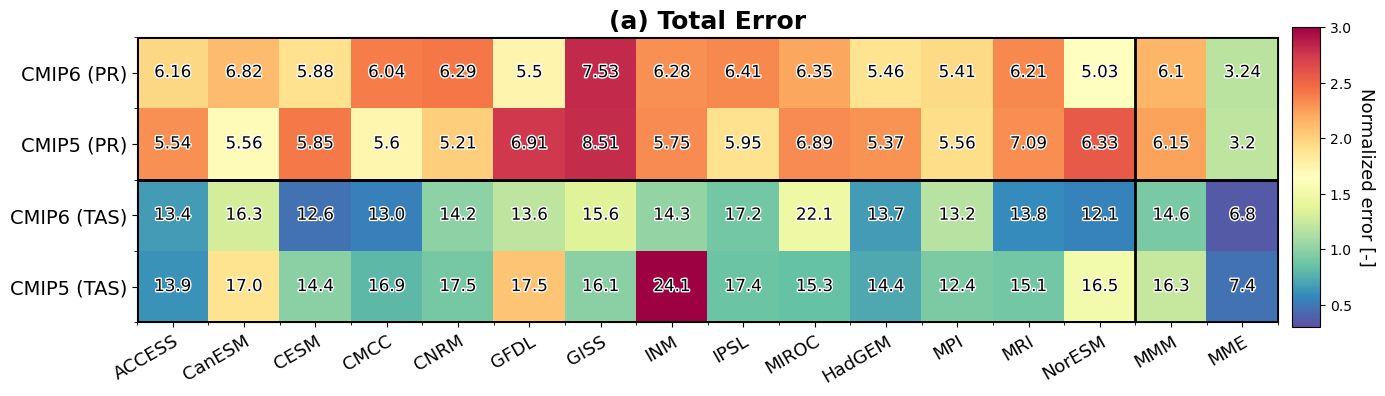

In [66]:
from sklearn import preprocessing
from scipy import special
from matplotlib.patches import Rectangle
import matplotlib.patheffects as path_effects


ycom = ['CMIP5 (TAS)','CMIP6 (TAS)','CMIP5 (PR)','CMIP6 (PR)'] # y-axis
xcom = cname2  + ['MMM'] + ['MME'] # x-axis
fname="./fig/TE_score_mme2.png"

# gm1 [vars: 2, mips: 3, models: 14, scores: 4]
colr = np.empty([len(ycom),len(xcom)]) * np.nan # [y,x] color shading
colr[0,:len(xcom)-2] = gm1[0,0,:,0]
colr[1,:len(xcom)-2] = gm1[0,1,:,0]
colr[2,:len(xcom)-2] = gm1[1,0,:,0]
colr[3,:len(xcom)-2] = gm1[1,1,:,0]
colr[0,len(xcom)-2] = gm1[0,0,:,0].mean()
colr[1,len(xcom)-2] = gm1[0,1,:,0].mean()
colr[2,len(xcom)-2] = gm1[1,0,:,0].mean()
colr[3,len(xcom)-2] = gm1[1,1,:,0].mean()
colr[0,len(xcom)-1] = gm3[0,0,0]
colr[1,len(xcom)-1] = gm3[0,1,0]
colr[2,len(xcom)-1] = gm3[1,0,0]
colr[3,len(xcom)-1] = gm3[1,1,0]

txt = np.empty([len(ycom),len(xcom)]) * np.nan # [y,x] text annotation
txt[0,:len(xcom)-2] = gm2[0,0,:,0]
txt[1,:len(xcom)-2] = gm2[0,1,:,0]
txt[2,:len(xcom)-2] = gm2[1,0,:,0]
txt[3,:len(xcom)-2] = gm2[1,1,:,0]
txt[0,len(xcom)-2] = gm2[0,0,:,0].mean()
txt[1,len(xcom)-2] = gm2[0,1,:,0].mean()
txt[2,len(xcom)-2] = gm2[1,0,:,0].mean()
txt[3,len(xcom)-2] = gm2[1,1,:,0].mean()
txt[0,len(xcom)-1] = gm4[0,0,0]
txt[1,len(xcom)-1] = gm4[0,1,0]
txt[2,len(xcom)-1] = gm4[1,0,0]
txt[3,len(xcom)-1] = gm4[1,1,0]


fig, ax = plt.subplots(1,1,figsize=(14,5))
# im = ax.imshow(colr, cmap='bwr', vmin=0.5, vmax=3.)
im = ax.imshow(colr, cmap='Spectral_r', vmin=0.3, vmax=3.0)
# ax.grid(color='w', linewidth=2)
# ax.grid(color='w', linestyle='-', linewidth=2)

# Minor ticks
ax.set_xticks(np.arange(-.5, len(xcom), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(ycom), 1), minor=True)

# Gridlines based on minor ticks
ax.add_patch(Rectangle((-0.5, -0.5), len(xcom), 2, fill=False, edgecolor='black', linewidth=2, alpha=1.0))
ax.add_patch(Rectangle((-0.5, 1.5), len(xcom), 2, fill=False, edgecolor='black', linewidth=2, alpha=1.0))

ax.add_patch(Rectangle((-0.5, -0.5), len(xcom)-2, 2, fill=False, edgecolor='black', linewidth=2, alpha=1.0))
ax.add_patch(Rectangle((-0.5, 1.5), len(xcom)-2, 2, fill=False, edgecolor='black', linewidth=2, alpha=1.0))


# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(xcom)))
ax.set_yticks(np.arange(len(ycom)))
ax.set_xticklabels(xcom,fontsize=13)
ax.set_yticklabels(ycom,fontsize=14)

err5 = np.sum(colr[0:2,:],axis=(0))
err6 = np.sum(colr[2:,:],axis=(0))
print(err5.argmin(),err6.argmin())

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
         rotation_mode="anchor")


# Loop over data dimensions and create text annotations.
for i in range(len(ycom)):
    for j in range(len(xcom)):
        if i<2:
            text = ax.text(j, i, "{}".format(round(txt[i, j],1)),
                           ha="center", va="center", color="black",fontsize=12)
        else:
            text = ax.text(j, i, "{}".format(round(txt[i, j],2)),
                           ha="center", va="center", color="black",fontsize=12)
        text.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='white'),
                path_effects.Normal()
            ])

# ax.set_title("UFS PT Evaluation ({})".format(season),fontsize=15)
ax.set_title("(a) Total Error",fontsize=18, weight='bold')
ax.set_xlim(-0.5, len(xcom)-0.5)
ax.set_ylim(-0.5, len(ycom)-0.5)
ax.set_aspect('equal')

# Create colorbar
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.set_ylabel("Normalized error [-]", rotation=-90, va="bottom",fontsize=13)

# fig.tight_layout()
# plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

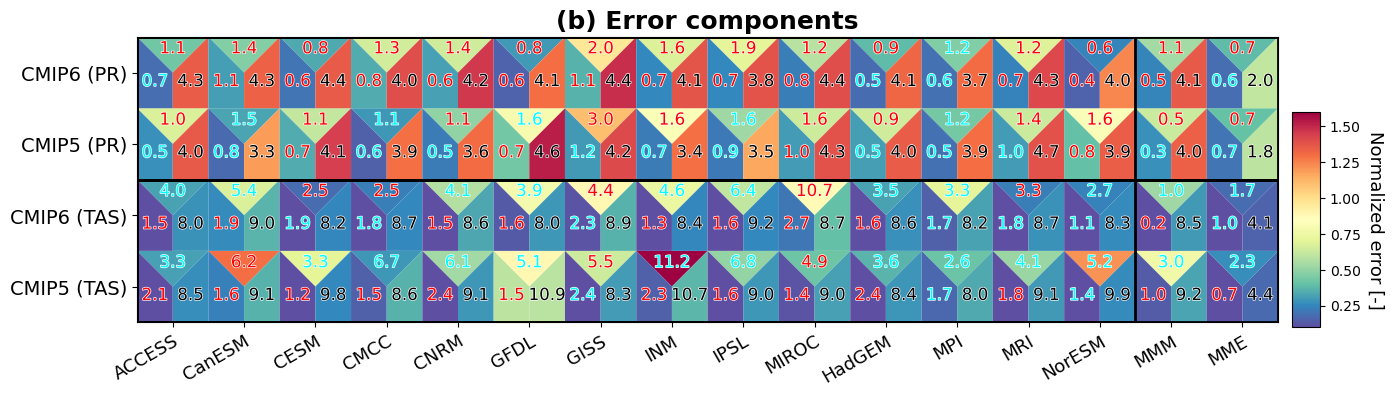

In [67]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import matplotlib as mpl
import matplotlib.patheffects as path_effects

fname="./fig/com_score_mme2.png"
fig, ax = plt.subplots(1,1,figsize=(14,5))

rows, cols = 4, 16
width, height = 1, 1

colr = np.empty([len(ycom),len(xcom),3]) * np.nan # [y,x] color shading
colr[0,:len(xcom)-2,:] = gm1[0,0,:,1:]
colr[1,:len(xcom)-2,:] = gm1[0,1,:,1:]
colr[2,:len(xcom)-2,:] = gm1[1,0,:,1:]
colr[3,:len(xcom)-2,:] = gm1[1,1,:,1:]
colr[0,len(xcom)-2,:] = gm1[0,0,:,1:].mean(axis=0)
colr[1,len(xcom)-2,:] = gm1[0,1,:,1:].mean(axis=0)
colr[2,len(xcom)-2,:] = gm1[1,0,:,1:].mean(axis=0)
colr[3,len(xcom)-2,:] = gm1[1,1,:,1:].mean(axis=0)
colr[0,len(xcom)-1,:] = gm3[0,0,1:]
colr[1,len(xcom)-1,:] = gm3[0,1,1:]
colr[2,len(xcom)-1,:] = gm3[1,0,1:]
colr[3,len(xcom)-1,:] = gm3[1,1,1:]

txt = np.empty([len(ycom),len(xcom),3]) * np.nan # [y,x] text annotation
txt[0,:len(xcom)-2,:] = gm22[0,0,:,1:]
txt[1,:len(xcom)-2,:] = gm22[0,1,:,1:]
txt[2,:len(xcom)-2,:] = gm22[1,0,:,1:]
txt[3,:len(xcom)-2,:] = gm22[1,1,:,1:]
txt[0,len(xcom)-2,:] = gm22[0,0,:,1:].mean(axis=0)
txt[1,len(xcom)-2,:] = gm22[0,1,:,1:].mean(axis=0)
txt[2,len(xcom)-2,:] = gm22[1,0,:,1:].mean(axis=0)
txt[3,len(xcom)-2,:] = gm22[1,1,:,1:].mean(axis=0)
txt[0,len(xcom)-1,:] = gm42[0,0,1:]
txt[1,len(xcom)-1,:] = gm42[0,1,1:]
txt[2,len(xcom)-1,:] = gm42[1,0,1:]
txt[3,len(xcom)-1,:] = gm42[1,1,1:]

cmap = plt.get_cmap("Spectral_r")
# norm = mpl.colors.Normalize(vmin=colr.min(), vmax=colr.max())
norm = mpl.colors.Normalize(vmin=0.1, vmax=1.6)

for row in range(rows):
    for col in range(cols):
        x0, y0 = col * width, row * height
        rect = [(x0, y0), (x0 + width, y0), (x0 + width, y0 + height), (x0, y0 + height)]
        center = (x0 + width / 2, y0 + height / 2)

        top_triangle = [rect[3], rect[2], center]
        bottom_left_rect = [rect[0], (center[0], y0), center, rect[3]]
        bottom_right_rect = [(center[0], y0), rect[1], rect[2], center]

        cell_data = colr[row, col]
        cell_data2 = txt[row, col]
        colors = [cmap(norm(value)) for value in cell_data]
        
        cnt = 0
        for part, color, value in zip([top_triangle, bottom_left_rect, bottom_right_rect], colors, cell_data2):
            # poly = Polygon(part, closed=True, edgecolor='black', facecolor=color)
            poly = Polygon(part, closed=True, facecolor=color)
            ax.add_patch(poly)
            centroid = np.mean(part, axis=0)
            if value>0 and cnt!=2:
                text = ax.text(centroid[0], centroid[1], f'{abs(value):.1f}', ha='center', va='center', fontsize=12, color='red')
            elif value<0 and cnt!=2:
                text = ax.text(centroid[0], centroid[1], f'{abs(value):.1f}', ha='center', va='center', fontsize=12, color='aqua')
            else:
                text = ax.text(centroid[0], centroid[1], f'{abs(value):.1f}', ha='center', va='center', fontsize=12, color='black')
            cnt += 1

            text.set_path_effects([
                path_effects.Stroke(linewidth=1, foreground='white'),
                path_effects.Normal()
            ])

# X, Y labels 
ax.set_xticks(np.arange(cols) + 0.5)
ax.set_xticklabels(xcom,fontsize=13)
ax.set_yticks(np.arange(rows) + 0.5)
ax.set_yticklabels(ycom,fontsize=14)

plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
         rotation_mode="anchor")

ax.add_patch(Rectangle((0, 0), len(xcom), 2, fill=False, edgecolor='black', linewidth=2, alpha=1.0))
ax.add_patch(Rectangle((0, 2), len(xcom), 2, fill=False, edgecolor='black', linewidth=2, alpha=1.0))

ax.add_patch(Rectangle((0, 0), len(xcom)-2, 2, fill=False, edgecolor='black', linewidth=2, alpha=1.0))
ax.add_patch(Rectangle((0, 2), len(xcom)-2, 2, fill=False, edgecolor='black', linewidth=2, alpha=1.0))

ax.set_title("(b) Error components",fontsize=18, weight='bold')
ax.set_xlim(0, cols)
ax.set_ylim(0, rows)
ax.set_aspect('equal')


fig.subplots_adjust(right=0.94)
# cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.43])
im = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.set_ylabel("Normalized error [-]", rotation=-90, va="bottom",fontsize=13)

# plt.tight_layout()
# plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

# Fig.5

In [20]:
opy = op.groupby('time.year').mean()
oty = ot.groupby('time.year').mean()
ty_c6 = t_c6.groupby('time.year').mean()
py_c6 = p_c6.groupby('time.year').mean()
ty_c5 = t_c5.groupby('time.year').mean()
py_c5 = p_c5.groupby('time.year').mean()
# del t_c6, t_c5, p_c6, p_c5

In [21]:
tthr = 20
pthr = 20

pb6 = py_c6.mean(dim='models') - opy
pb5 = py_c5.mean(dim='models') - opy
tb6 = ty_c6.mean(dim='models') - oty
tb5 = ty_c5.mean(dim='models') - oty

gopy = area_avg_weight(opy, 'lon', 'lat')
goty = area_avg_weight(oty, 'lon', 'lat')
gty_c6 = area_avg_weight(ty_c6.where(~np.isnan(oty)), 'lon', 'lat')
gpy_c6 = area_avg_weight(py_c6.where(~np.isnan(opy)), 'lon', 'lat')
gty_c5 = area_avg_weight(ty_c5.where(~np.isnan(oty)), 'lon', 'lat')
gpy_c5 = area_avg_weight(py_c5.where(~np.isnan(opy)), 'lon', 'lat')

In [22]:
for i in range(len(cmip6_name)):
    print(i, cmip6_name[i])

0 ACCESS-CM2
1 CanESM5
2 CESM2-WACCM
3 CMCC-CM2-HR4
4 CNRM-ESM2-1
5 GFDL-CM4
6 GISS-E2-1-H
7 INM-CM5-0
8 IPSL-CM6A-LR
9 MIROC6
10 HadGEM3-GC31-LL
11 MPI-ESM1-2-LR
12 MRI-ESM2-0
13 NorESM2-MM


In [23]:
gopy   = opy.mean(dim=('lon','lat'))
goty   = oty.mean(dim=('lon','lat'))
gty_c6 = ty_c6.where(~np.isnan(oty)).mean(dim=('lon','lat'))
gpy_c6 = py_c6.where(~np.isnan(opy)).mean(dim=('lon','lat'))
gty_c5 = ty_c5.where(~np.isnan(oty)).mean(dim=('lon','lat'))
gpy_c5 = py_c5.where(~np.isnan(opy)).mean(dim=('lon','lat'))

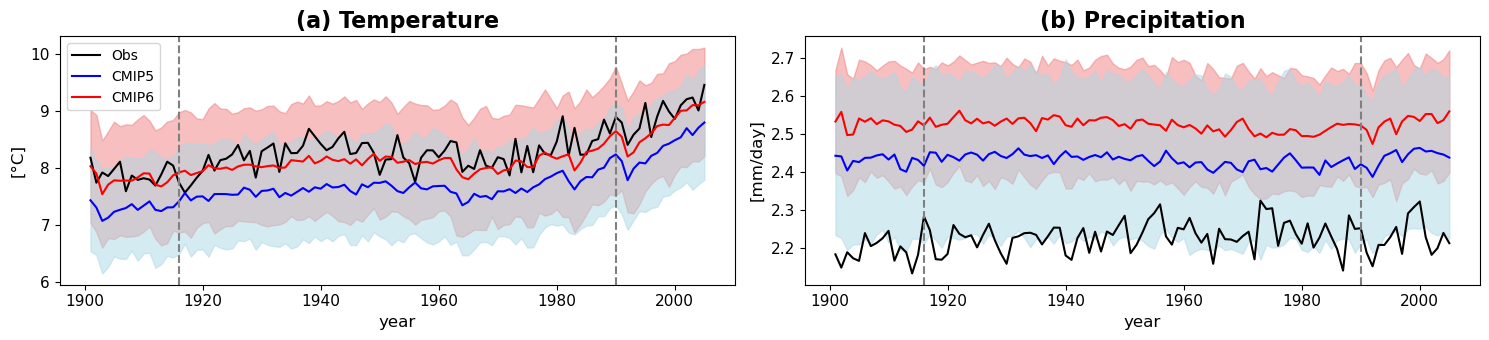

In [25]:
fname="./fig/time_series.png"
label1 = ['year','[°C]']
label2 = ['year','[mm/day]']

fig = plt.figure(figsize=(15,3.5))
ax = fig.add_subplot(121)
ax.plot(goty.year, goty-273.15, color='black', label='Obs')
ax.fill_between(goty.year, gty_c6.mean(dim='models')-gty_c6.std(dim='models')-273.15, gty_c6.mean(dim='models')+gty_c6.std(dim='models')-273.15, color='lightcoral', alpha=0.5)
ax.fill_between(goty.year, gty_c5.mean(dim='models')-gty_c5.std(dim='models')-273.15, gty_c5.mean(dim='models')+gty_c5.std(dim='models')-273.15, color='lightblue', alpha=0.5)
ax.plot(goty.year, gty_c5.mean(dim='models')-273.15, color='blue', label='CMIP5')
ax.plot(goty.year, gty_c6.mean(dim='models')-273.15, color='red', label='CMIP6')

ax.set_title('(a) Temperature',fontsize=16, weight='bold')
ax.tick_params(labelsize=11)
ax.set_xlabel('{}'.format(label1[0]),fontsize=12)
ax.set_ylabel('{}'.format(label1[1]),fontsize=12)
ax.axvline(x=1916, color='gray', linestyle='--')
ax.axvline(x=1990, color='gray', linestyle='--')
ax.legend()

ax = fig.add_subplot(122)
ax.plot(goty.year, gopy, color='black')
ax.fill_between(goty.year, gpy_c6.mean(dim='models')-gpy_c6.std(dim='models'), gpy_c6.mean(dim='models')+gpy_c6.std(dim='models'), color='lightcoral', alpha=0.5)
ax.fill_between(goty.year, gpy_c5.mean(dim='models')-gpy_c5.std(dim='models'), gpy_c5.mean(dim='models')+gpy_c5.std(dim='models'), color='lightblue', alpha=0.5)
ax.plot(goty.year, gpy_c5.mean(dim='models'), color='blue')
ax.plot(goty.year, gpy_c6.mean(dim='models'), color='red')

ax.set_title('(b) Precipitation',fontsize=16, weight='bold')
ax.tick_params(labelsize=11)
ax.set_xlabel('{}'.format(label2[0]),fontsize=12)
ax.set_ylabel('{}'.format(label2[1]),fontsize=12)
ax.axvline(x=1916, color='gray', linestyle='--')
ax.axvline(x=1990, color='gray', linestyle='--')

fig.tight_layout()
# plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

In [583]:
def model_eval_2nd(x, y, dname):
    # x is model
    # y is observation
    xmean = x.mean(dim=dname)
    ymean = y.mean(dim=dname)
    xstd = x.std(dim=dname)
    ystd = y.std(dim=dname)
    diff = ( (x-y)**2 ).mean(dim=dname)
    score  = diff
    score1 = ( (xmean-ymean)**2 )
    score21 = ( (xstd-ystd)**2 )
    score22 = (2*xstd*ystd)* ( 1 - xr.corr(x,y,dim=dname) )
    score2 = score21 + score22
    return score.where(np.isfinite(score)), score1.where(np.isfinite(score1)), score2.where(np.isfinite(score2)), score21.where(np.isfinite(score21)), score22.where(np.isfinite(score22))

def model_eval_2nd_norm(x, y, dname):
    # x is model
    # y is observation
    xmean = x.mean(dim=dname)
    ymean = y.mean(dim=dname)
    xstd = x.std(dim=dname)
    ystd = y.std(dim=dname)
    diff = ( (x-y)**2 ).mean(dim=dname)
    score  = diff/(ystd**2)
    score1 = ( (xmean-ymean)**2 )/(ystd**2)
    score21 = ( (xstd/ystd) -1 )**2
    score22 = (2*xstd/ystd)* ( 1 - xr.corr(x,y,dim=dname) )
    score2 = score21 + score22
    return score.where(np.isfinite(score)), score1.where(np.isfinite(score1)), score2.where(np.isfinite(score2)), score21.where(np.isfinite(score21)), score22.where(np.isfinite(score22))


map3 = xr.DataArray(data = np.empty([2,3,len(cmip5_name),4,len(goty.year[15:-15])]) * np.nan, 
                    dims=["vars","mips","models","scores","years"],
                    coords = dict(vars=(["vars"], [x for x in range(2)]),
                                  mips=(["mips"], [x for x in range(3)]),
                                  models=(["models"], [x for x in range(len(cmip5_name))]),
                                  scores=(["scores"], [x for x in range(4)]),
                                  years=(["years"], goty.year[15:-15].values),
                                 )
                   )
map4 = map3.copy(deep=True)

for y,year in enumerate(goty.year[15:-15].values):
    # print(year)
    oo = ot.sel(time=ot.time.dt.year.isin(goty.year[y:y+31]))
    c5 = t_c5.sel(time=t_c5.time.dt.year.isin(goty.year[y:y+31]))
    c6 = t_c6.sel(time=t_c6.time.dt.year.isin(goty.year[y:y+31]))
    ts5, ts51, ts52, ts521, ts522 = model_eval_2nd_norm(c5, oo, 'time')
    ts6, ts61, ts62, ts621, ts622 = model_eval_2nd_norm(c6, oo, 'time')
    
    s5, s51, s52, s521, s522 = model_eval_2nd(c5, oo, 'time')
    s6, s61, s62, s621, s622 = model_eval_2nd(c6, oo, 'time')
    
    map3[0,0,:,0,y] = ts5.mean(dim=('lon', 'lat'))
    map3[0,0,:,1,y] = ts51.mean(dim=('lon', 'lat'))
    map3[0,0,:,2,y] = ts521.mean(dim=('lon', 'lat'))
    map3[0,0,:,3,y] = ts522.mean(dim=('lon', 'lat'))
    map3[0,1,:,0,y] = ts6.mean(dim=('lon', 'lat'))
    map3[0,1,:,1,y] = ts61.mean(dim=('lon', 'lat'))
    map3[0,1,:,2,y] = ts621.mean(dim=('lon', 'lat'))
    map3[0,1,:,3,y] = ts622.mean(dim=('lon', 'lat'))
    
    map4[0,0,:,0,y] = s5.mean(dim=('lon', 'lat'))
    map4[0,0,:,1,y] = s51.mean(dim=('lon', 'lat'))
    map4[0,0,:,2,y] = s521.mean(dim=('lon', 'lat'))
    map4[0,0,:,3,y] = s522.mean(dim=('lon', 'lat'))
    map4[0,1,:,0,y] = s6.mean(dim=('lon', 'lat'))
    map4[0,1,:,1,y] = s61.mean(dim=('lon', 'lat'))
    map4[0,1,:,2,y] = s621.mean(dim=('lon', 'lat'))
    map4[0,1,:,3,y] = s622.mean(dim=('lon', 'lat'))
    
    del oo, c5, c6, ts5, ts51, ts52, ts521, ts522, ts6, ts61, ts62, ts621, ts622
    del s5, s51, s52, s521, s522, s6, s61, s62, s621, s622
    
    
    oo = op.sel(time=op.time.dt.year.isin(goty.year[y:y+31]))
    c5 = p_c5.sel(time=p_c5.time.dt.year.isin(goty.year[y:y+31]))
    c6 = p_c6.sel(time=p_c6.time.dt.year.isin(goty.year[y:y+31]))
    ts5, ts51, ts52, ts521, ts522 = model_eval_2nd_norm(c5, oo, 'time')
    ts6, ts61, ts62, ts621, ts622 = model_eval_2nd_norm(c6, oo, 'time')
    
    s5, s51, s52, s521, s522 = model_eval_2nd(c5, oo, 'time')
    s6, s61, s62, s621, s622 = model_eval_2nd(c6, oo, 'time')
    
    map3[1,0,:,0,y] = ts5.mean(dim=('lon', 'lat'))
    map3[1,0,:,1,y] = ts51.mean(dim=('lon', 'lat'))
    map3[1,0,:,2,y] = ts521.mean(dim=('lon', 'lat'))
    map3[1,0,:,3,y] = ts522.mean(dim=('lon', 'lat'))
    map3[1,1,:,0,y] = ts6.mean(dim=('lon', 'lat'))
    map3[1,1,:,1,y] = ts61.mean(dim=('lon', 'lat'))
    map3[1,1,:,2,y] = ts621.mean(dim=('lon', 'lat'))
    map3[1,1,:,3,y] = ts622.mean(dim=('lon', 'lat'))
    
    map4[1,0,:,0,y] = s5.mean(dim=('lon', 'lat'))
    map4[1,0,:,1,y] = s51.mean(dim=('lon', 'lat'))
    map4[1,0,:,2,y] = s521.mean(dim=('lon', 'lat'))
    map4[1,0,:,3,y] = s522.mean(dim=('lon', 'lat'))
    map4[1,1,:,0,y] = s6.mean(dim=('lon', 'lat'))
    map4[1,1,:,1,y] = s61.mean(dim=('lon', 'lat'))
    map4[1,1,:,2,y] = s621.mean(dim=('lon', 'lat'))
    map4[1,1,:,3,y] = s622.mean(dim=('lon', 'lat'))
    
    del oo, c5, c6, ts5, ts51, ts52, ts521, ts522, ts6, ts61, ts62, ts621, ts622
    del s5, s51, s52, s521, s522, s6, s61, s62, s621, s622
    
map3[0,2,:,:,:] = map3[0,1,:,:,:] - map3[0,0,:,:,:]
map3[1,2,:,:,:] = map3[1,1,:,:,:] - map3[1,0,:,:,:]

map4[0,2,:,:,:] = map4[0,1,:,:,:] - map4[0,0,:,:,:]
map4[1,2,:,:,:] = map4[1,1,:,:,:] - map4[1,0,:,:,:]

1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990


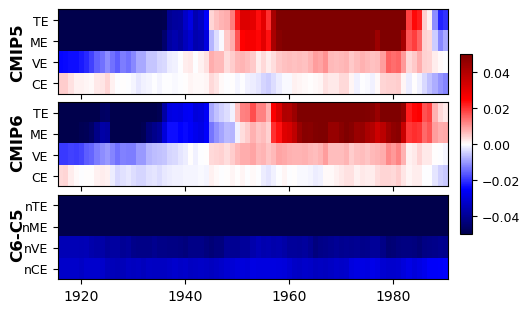

In [584]:
nvar = 'tas'
fname="./fig/"+nvar+"_window_error.png"
clevs=np.arange(-0.25,0.26,0.01)

fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(6,3))

aa = map3[0,0,:,:,:].mean(dim='models')
bb = aa - aa.mean(dim='years')
ax[0].imshow(bb, cmap='seismic', vmin=-0.05, vmax=0.05, interpolation='nearest', aspect='auto')

# Create colorbar
# cbar = ax[0].figure.colorbar(im, ax=ax[0])
# cbar.ax.set_ylabel('[-]', rotation=-90, va="bottom")
# sys.exit()

# Show all ticks and label them with the respective list entries.
ax[0].set_xticks(np.arange(4,len(bb.years),20))
ax[0].set_xticklabels(bb.years.values[4::20])
ax[0].set_yticks(np.arange(len(bb.scores)))
ax[0].set_yticklabels(['TE','ME','VE','CE'], fontsize=9)

# Let the horizontal axes labeling appear on top.
ax[0].tick_params(top=False, bottom=True,
               labeltop=False, labelbottom=False)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#          rotation_mode="anchor")

# Turn spines off and create white grid.
# ax[0].spines[:].set_visible(True)
# ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[0].set_yticks(np.arange(len(bb.scores)+1)-.5, minor=True)
# ax[0].grid(which="minor", color="gray", linestyle='--', linewidth=1)
# ax[0].tick_params(which="minor", bottom=False, left=False)
    
aa = map3[0,1,:,:,:].mean(dim='models')
bb = aa - aa.mean(dim='years')
ax[1].imshow(bb, cmap='seismic', vmin=-0.05, vmax=0.05, interpolation='nearest', aspect='auto')

# Show all ticks and label them with the respective list entries.
ax[1].set_xticks(np.arange(4,len(bb.years),20))
ax[1].set_xticklabels(bb.years.values[4::20])
ax[1].set_yticks(np.arange(len(bb.scores)))
ax[1].set_yticklabels(['TE','ME','VE','CE'], fontsize=9)

# Let the horizontal axes labeling appear on top.
ax[1].tick_params(top=False, bottom=True,
               labeltop=False, labelbottom=False)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#          rotation_mode="anchor")

# Turn spines off and create white grid.
# ax[1].spines[:].set_visible(True)
# ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[1].set_yticks(np.arange(len(bb.scores)+1)-.5, minor=True)
# ax[1].grid(which="minor", color="gray", linestyle='--', linewidth=1)
# ax[1].tick_params(which="minor", bottom=False, left=False)


aa = map3[0,2,:,:,:].mean(dim='models')
bb = aa #- aa.mean(dim='years')
im3 = ax[2].imshow(bb, cmap='seismic', vmin=-0.05, vmax=0.05, interpolation='nearest', aspect='auto')

# Show all ticks and label them with the respective list entries.
ax[2].set_xticks(np.arange(4,len(bb.years),20))
ax[2].set_xticklabels(bb.years.values[4::20])
ax[2].set_yticks(np.arange(len(bb.scores)))
ax[2].set_yticklabels(['nTE','nME','nVE','nCE'], fontsize=9)

# Let the horizontal axes labeling appear on top.
ax[2].tick_params(top=False, bottom=True,
               labeltop=False, labelbottom=True)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#          rotation_mode="anchor")

# Turn spines off and create white grid.
# ax[2].spines[:].set_visible(True)
# ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[2].set_yticks(np.arange(len(bb.scores)+1)-.5, minor=True)
# ax[2].grid(which="minor", color="gray", linestyle='--', linewidth=1)
# ax[2].tick_params(which="minor", bottom=False, left=False)

fig.subplots_adjust(bottom=0.05, top=0.95, left=0.15, right=0.80,
                    wspace=0.05, hspace=0.10) # wspace: horizontal space, hspace: vertical space

# Add a colorbar axis at the bottom of the graph
cbar_ax  = fig.add_axes([0.82, 0.2, 0.02, 0.6])
# cbar_ax1 = fig.add_axes([0.66, 0.12, 0.28, 0.02])

# Draw the colorbar
# cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='[mm/day]')
cbar=fig.colorbar(im3, cax=cbar_ax,orientation='vertical')
cbar.set_label('', fontsize=9.5, x=1.04, labelpad=-10)
cbar.ax.tick_params(labelsize=9)

# cbar1=fig.colorbar(cs2, cax=cbar_ax1,orientation='horizontal')
# cbar1.set_label('[{}]'.format(units[1]), fontsize=9.5, x=1.06, labelpad=-10)
# cbar1.ax.tick_params(labelsize=9)

fig.text(0.07,0.72,'CMIP5',rotation=90,fontsize=12,weight='bold')
fig.text(0.07,0.42,'CMIP6',rotation=90,fontsize=12,weight='bold')
fig.text(0.07,0.12,'C6-C5',rotation=90,fontsize=12,weight='bold')
# fig.tight_layout()
plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

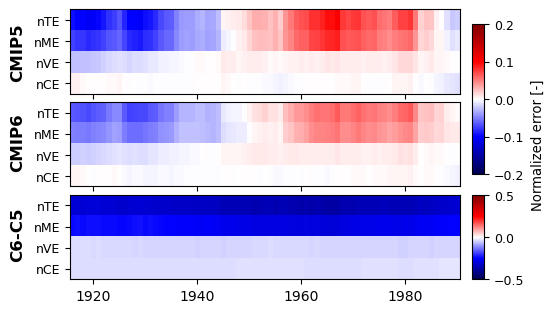

In [646]:
nvar = 'tas'
fname="./fig/"+nvar+"_window_norm_error.png"
clevs=np.arange(-0.25,0.26,0.01)

fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(6,3))

aa = map3[0,0,:,:,:].mean(dim='models')
bb = aa - aa.mean(dim='years')
im1 = ax[0].imshow(bb, cmap='seismic', vmin=-0.2, vmax=0.2, interpolation='nearest', aspect='auto')

# Create colorbar
# cbar = ax[0].figure.colorbar(im, ax=ax[0])
# cbar.ax.set_ylabel('[-]', rotation=-90, va="bottom")
# sys.exit()

# Show all ticks and label them with the respective list entries.
ax[0].set_xticks(np.arange(4,len(bb.years),20))
ax[0].set_xticklabels(bb.years.values[4::20])
ax[0].set_yticks(np.arange(len(bb.scores)))
ax[0].set_yticklabels(['nTE','nME','nVE','nCE'], fontsize=9)

# Let the horizontal axes labeling appear on top.
ax[0].tick_params(top=False, bottom=True,
               labeltop=False, labelbottom=False)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#          rotation_mode="anchor")

# Turn spines off and create white grid.
# ax[0].spines[:].set_visible(True)
# ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[0].set_yticks(np.arange(len(bb.scores)+1)-.5, minor=True)
# ax[0].grid(which="minor", color="gray", linestyle='--', linewidth=1)
# ax[0].tick_params(which="minor", bottom=False, left=False)
    
aa = map3[0,1,:,:,:].mean(dim='models')
bb = aa - aa.mean(dim='years')
im2 = ax[1].imshow(bb, cmap='seismic', vmin=-0.2, vmax=0.2, interpolation='nearest', aspect='auto')

# Show all ticks and label them with the respective list entries.
ax[1].set_xticks(np.arange(4,len(bb.years),20))
ax[1].set_xticklabels(bb.years.values[4::20])
ax[1].set_yticks(np.arange(len(bb.scores)))
ax[1].set_yticklabels(['nTE','nME','nVE','nCE'], fontsize=9)

# Let the horizontal axes labeling appear on top.
ax[1].tick_params(top=False, bottom=True,
               labeltop=False, labelbottom=False)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#          rotation_mode="anchor")

# Turn spines off and create white grid.
# ax[1].spines[:].set_visible(True)
# ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[1].set_yticks(np.arange(len(bb.scores)+1)-.5, minor=True)
# ax[1].grid(which="minor", color="gray", linestyle='--', linewidth=1)
# ax[1].tick_params(which="minor", bottom=False, left=False)


aa = map3[0,2,:,:,:].mean(dim='models')
bb = aa #- aa.mean(dim='years')
im3 = ax[2].imshow(bb, cmap='seismic', vmin=-0.5, vmax=0.5, interpolation='nearest', aspect='auto')

# Show all ticks and label them with the respective list entries.
ax[2].set_xticks(np.arange(4,len(bb.years),20))
ax[2].set_xticklabels(bb.years.values[4::20])
ax[2].set_yticks(np.arange(len(bb.scores)))
ax[2].set_yticklabels(['nTE','nME','nVE','nCE'], fontsize=9)

# Let the horizontal axes labeling appear on top.
ax[2].tick_params(top=False, bottom=True,
               labeltop=False, labelbottom=True)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#          rotation_mode="anchor")

# Turn spines off and create white grid.
# ax[2].spines[:].set_visible(True)
# ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[2].set_yticks(np.arange(len(bb.scores)+1)-.5, minor=True)
# ax[2].grid(which="minor", color="gray", linestyle='--', linewidth=1)
# ax[2].tick_params(which="minor", bottom=False, left=False)

fig.subplots_adjust(bottom=0.05, top=0.95, left=0.15, right=0.80,
                    wspace=0.05, hspace=0.10) # wspace: horizontal space, hspace: vertical space

# Add a colorbar axis at the bottom of the graph
cbar_ax1 = fig.add_axes([0.82, 0.40, 0.02, 0.5])
cbar_ax2 = fig.add_axes([0.82, 0.05, 0.02, 0.28])

# Draw the colorbar
cbar1=fig.colorbar(im1, cax=cbar_ax1,orientation='vertical')
# cbar1.set_label('', fontsize=9.5, x=1.04, labelpad=-10)
cbar1.set_label('Normalized error [-]', fontsize=9.5, y=0.2, labelpad=5)
cbar1.ax.tick_params(labelsize=9)

cbar2=fig.colorbar(im3, cax=cbar_ax2,orientation='vertical')
cbar2.set_label('', fontsize=9.5, x=1.04, labelpad=-10)
cbar2.ax.tick_params(labelsize=9)

fig.text(0.05,0.72,'CMIP5',rotation=90,fontsize=12,weight='bold')
fig.text(0.05,0.42,'CMIP6',rotation=90,fontsize=12,weight='bold')
fig.text(0.05,0.12,'C6-C5',rotation=90,fontsize=12,weight='bold')
# fig.tight_layout()
plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

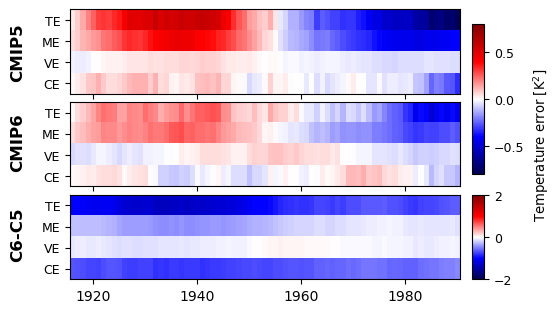

In [647]:
nvar = 'tas'
fname="./fig/"+nvar+"_window_error.png"
clevs=np.arange(-0.25,0.26,0.01)

fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(6,3))

aa = map4[0,0,:,:,:].mean(dim='models')
bb = aa - aa.mean(dim='years')
im1 = ax[0].imshow(bb, cmap='seismic', vmin=-0.8, vmax=0.8, interpolation='nearest', aspect='auto')

# Create colorbar
# cbar = ax[0].figure.colorbar(im, ax=ax[0])
# cbar.ax.set_ylabel('[-]', rotation=-90, va="bottom")
# sys.exit()

# Show all ticks and label them with the respective list entries.
ax[0].set_xticks(np.arange(4,len(bb.years),20))
ax[0].set_xticklabels(bb.years.values[4::20])
ax[0].set_yticks(np.arange(len(bb.scores)))
ax[0].set_yticklabels(['TE','ME','VE','CE'], fontsize=9)

# Let the horizontal axes labeling appear on top.
ax[0].tick_params(top=False, bottom=True,
               labeltop=False, labelbottom=False)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#          rotation_mode="anchor")

# Turn spines off and create white grid.
# ax[0].spines[:].set_visible(True)
# ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[0].set_yticks(np.arange(len(bb.scores)+1)-.5, minor=True)
# ax[0].grid(which="minor", color="gray", linestyle='--', linewidth=1)
# ax[0].tick_params(which="minor", bottom=False, left=False)
    
aa = map4[0,1,:,:,:].mean(dim='models')
bb = aa - aa.mean(dim='years')
im2 = ax[1].imshow(bb, cmap='seismic', vmin=-0.8, vmax=0.8, interpolation='nearest', aspect='auto')

# Show all ticks and label them with the respective list entries.
ax[1].set_xticks(np.arange(4,len(bb.years),20))
ax[1].set_xticklabels(bb.years.values[4::20])
ax[1].set_yticks(np.arange(len(bb.scores)))
ax[1].set_yticklabels(['TE','ME','VE','CE'], fontsize=9)

# Let the horizontal axes labeling appear on top.
ax[1].tick_params(top=False, bottom=True,
               labeltop=False, labelbottom=False)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#          rotation_mode="anchor")

# Turn spines off and create white grid.
# ax[1].spines[:].set_visible(True)
# ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[1].set_yticks(np.arange(len(bb.scores)+1)-.5, minor=True)
# ax[1].grid(which="minor", color="gray", linestyle='--', linewidth=1)
# ax[1].tick_params(which="minor", bottom=False, left=False)


aa = map4[0,2,:,:,:].mean(dim='models')
bb = aa #- aa.mean(dim='years')
im3 = ax[2].imshow(bb, cmap='seismic', vmin=-2, vmax=2, interpolation='nearest', aspect='auto')

# Show all ticks and label them with the respective list entries.
ax[2].set_xticks(np.arange(4,len(bb.years),20))
ax[2].set_xticklabels(bb.years.values[4::20])
ax[2].set_yticks(np.arange(len(bb.scores)))
ax[2].set_yticklabels(['TE','ME','VE','CE'], fontsize=9)

# Let the horizontal axes labeling appear on top.
ax[2].tick_params(top=False, bottom=True,
               labeltop=False, labelbottom=True)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#          rotation_mode="anchor")

# Turn spines off and create white grid.
# ax[2].spines[:].set_visible(True)
# ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[2].set_yticks(np.arange(len(bb.scores)+1)-.5, minor=True)
# ax[2].grid(which="minor", color="gray", linestyle='--', linewidth=1)
# ax[2].tick_params(which="minor", bottom=False, left=False)

fig.subplots_adjust(bottom=0.05, top=0.95, left=0.15, right=0.80,
                    wspace=0.05, hspace=0.10) # wspace: horizontal space, hspace: vertical space

# Add a colorbar axis at the bottom of the graph
cbar_ax1 = fig.add_axes([0.82, 0.40, 0.02, 0.5])
cbar_ax2 = fig.add_axes([0.82, 0.05, 0.02, 0.28])

# Draw the colorbar
cbar1=fig.colorbar(im1, cax=cbar_ax1,orientation='vertical')
# cbar1.set_label('', fontsize=9.5, x=1.04, labelpad=-10)
cbar1.set_label('Temperature error [K$^2$]', fontsize=9.5, y=0.2, labelpad=5)
cbar1.ax.tick_params(labelsize=9)

cbar2=fig.colorbar(im3, cax=cbar_ax2,orientation='vertical')
cbar2.set_label('', fontsize=9.5, x=1.04, labelpad=-10)
cbar2.ax.tick_params(labelsize=9)

fig.text(0.05,0.72,'CMIP5',rotation=90,fontsize=12,weight='bold')
fig.text(0.05,0.42,'CMIP6',rotation=90,fontsize=12,weight='bold')
fig.text(0.05,0.12,'C6-C5',rotation=90,fontsize=12,weight='bold')
# fig.tight_layout()
plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

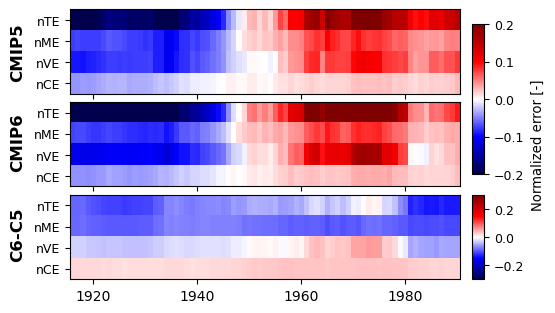

In [648]:
nvar = 'pr'
fname="./fig/"+nvar+"_window_norm_error.png"
clevs=np.arange(-0.25,0.26,0.01)

fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(6,3))

aa = map3[1,0,:,:,:].mean(dim='models')
bb = aa - aa.mean(dim='years')
im1 = ax[0].imshow(bb, cmap='seismic', vmin=-0.2, vmax=0.2, interpolation='nearest', aspect='auto')

# Create colorbar
# cbar = ax[0].figure.colorbar(im, ax=ax[0])
# cbar.ax.set_ylabel('[-]', rotation=-90, va="bottom")
# sys.exit()

# Show all ticks and label them with the respective list entries.
ax[0].set_xticks(np.arange(4,len(bb.years),20))
ax[0].set_xticklabels(bb.years.values[4::20])
ax[0].set_yticks(np.arange(len(bb.scores)))
ax[0].set_yticklabels(['nTE','nME','nVE','nCE'], fontsize=9)

# Let the horizontal axes labeling appear on top.
ax[0].tick_params(top=False, bottom=True,
               labeltop=False, labelbottom=False)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#          rotation_mode="anchor")

# Turn spines off and create white grid.
# ax[0].spines[:].set_visible(True)
# ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[0].set_yticks(np.arange(len(bb.scores)+1)-.5, minor=True)
# ax[0].grid(which="minor", color="gray", linestyle='--', linewidth=1)
# ax[0].tick_params(which="minor", bottom=False, left=False)
    
aa = map3[1,1,:,:,:].mean(dim='models')
bb = aa - aa.mean(dim='years')
im2 = ax[1].imshow(bb, cmap='seismic', vmin=-0.2, vmax=0.2, interpolation='nearest', aspect='auto')

# Show all ticks and label them with the respective list entries.
ax[1].set_xticks(np.arange(4,len(bb.years),20))
ax[1].set_xticklabels(bb.years.values[4::20])
ax[1].set_yticks(np.arange(len(bb.scores)))
ax[1].set_yticklabels(['nTE','nME','nVE','nCE'], fontsize=9)

# Let the horizontal axes labeling appear on top.
ax[1].tick_params(top=False, bottom=True,
               labeltop=False, labelbottom=False)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#          rotation_mode="anchor")

# Turn spines off and create white grid.
# ax[1].spines[:].set_visible(True)
# ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[1].set_yticks(np.arange(len(bb.scores)+1)-.5, minor=True)
# ax[1].grid(which="minor", color="gray", linestyle='--', linewidth=1)
# ax[1].tick_params(which="minor", bottom=False, left=False)


aa = map3[1,2,:,:,:].mean(dim='models')
bb = aa #- aa.mean(dim='years')
im3 = ax[2].imshow(bb, cmap='seismic', vmin=-0.3, vmax=0.3, interpolation='nearest', aspect='auto')

# Show all ticks and label them with the respective list entries.
ax[2].set_xticks(np.arange(4,len(bb.years),20))
ax[2].set_xticklabels(bb.years.values[4::20])
ax[2].set_yticks(np.arange(len(bb.scores)))
ax[2].set_yticklabels(['nTE','nME','nVE','nCE'], fontsize=9)

# Let the horizontal axes labeling appear on top.
ax[2].tick_params(top=False, bottom=True,
               labeltop=False, labelbottom=True)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#          rotation_mode="anchor")

# Turn spines off and create white grid.
# ax[2].spines[:].set_visible(True)
# ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[2].set_yticks(np.arange(len(bb.scores)+1)-.5, minor=True)
# ax[2].grid(which="minor", color="gray", linestyle='--', linewidth=1)
# ax[2].tick_params(which="minor", bottom=False, left=False)

fig.subplots_adjust(bottom=0.05, top=0.95, left=0.15, right=0.80,
                    wspace=0.05, hspace=0.10) # wspace: horizontal space, hspace: vertical space

# Add a colorbar axis at the bottom of the graph
cbar_ax1 = fig.add_axes([0.82, 0.40, 0.02, 0.5])
cbar_ax2 = fig.add_axes([0.82, 0.05, 0.02, 0.28])

# Draw the colorbar
cbar1=fig.colorbar(im1, cax=cbar_ax1,orientation='vertical')
# cbar1.set_label('', fontsize=9.5, x=1.04, labelpad=-10)
cbar1.set_label('Normalized error [-]', fontsize=9.5, y=0.2, labelpad=5)

cbar1.ax.tick_params(labelsize=9)

cbar2=fig.colorbar(im3, cax=cbar_ax2,orientation='vertical')
cbar2.set_label('', fontsize=9.5, x=1.04, labelpad=-10)
cbar2.ax.tick_params(labelsize=9)

fig.text(0.05,0.72,'CMIP5',rotation=90,fontsize=12,weight='bold')
fig.text(0.05,0.42,'CMIP6',rotation=90,fontsize=12,weight='bold')
fig.text(0.05,0.12,'C6-C5',rotation=90,fontsize=12,weight='bold')
# fig.tight_layout()
plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

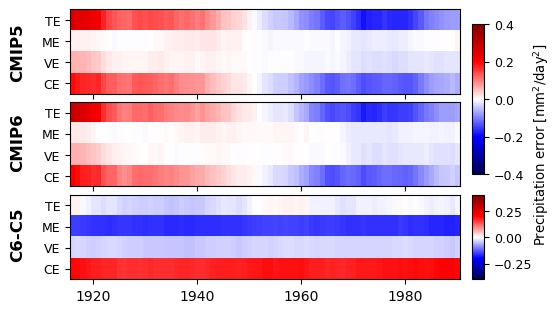

In [652]:
nvar = 'pr'
fname="./fig/"+nvar+"_window_error.png"
clevs=np.arange(-0.25,0.26,0.01)

fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(6,3))

aa = map4[1,0,:,:,:].mean(dim='models')
bb = aa - aa.mean(dim='years')
im1 = ax[0].imshow(bb, cmap='seismic', vmin=-0.4, vmax=0.4, interpolation='nearest', aspect='auto')

# Create colorbar
# cbar = ax[0].figure.colorbar(im, ax=ax[0])
# cbar.ax.set_ylabel('[-]', rotation=-90, va="bottom")
# sys.exit()

# Show all ticks and label them with the respective list entries.
ax[0].set_xticks(np.arange(4,len(bb.years),20))
ax[0].set_xticklabels(bb.years.values[4::20])
ax[0].set_yticks(np.arange(len(bb.scores)))
ax[0].set_yticklabels(['TE','ME','VE','CE'], fontsize=9)

# Let the horizontal axes labeling appear on top.
ax[0].tick_params(top=False, bottom=True,
               labeltop=False, labelbottom=False)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#          rotation_mode="anchor")

# Turn spines off and create white grid.
# ax[0].spines[:].set_visible(True)
# ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[0].set_yticks(np.arange(len(bb.scores)+1)-.5, minor=True)
# ax[0].grid(which="minor", color="gray", linestyle='--', linewidth=1)
# ax[0].tick_params(which="minor", bottom=False, left=False)
    
aa = map4[1,1,:,:,:].mean(dim='models')
bb = aa - aa.mean(dim='years')
im2 = ax[1].imshow(bb, cmap='seismic', vmin=-0.4, vmax=0.4, interpolation='nearest', aspect='auto')

# Show all ticks and label them with the respective list entries.
ax[1].set_xticks(np.arange(4,len(bb.years),20))
ax[1].set_xticklabels(bb.years.values[4::20])
ax[1].set_yticks(np.arange(len(bb.scores)))
ax[1].set_yticklabels(['TE','ME','VE','CE'], fontsize=9)

# Let the horizontal axes labeling appear on top.
ax[1].tick_params(top=False, bottom=True,
               labeltop=False, labelbottom=False)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#          rotation_mode="anchor")

# Turn spines off and create white grid.
# ax[1].spines[:].set_visible(True)
# ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[1].set_yticks(np.arange(len(bb.scores)+1)-.5, minor=True)
# ax[1].grid(which="minor", color="gray", linestyle='--', linewidth=1)
# ax[1].tick_params(which="minor", bottom=False, left=False)


aa = map4[1,2,:,:,:].mean(dim='models')
bb = aa #- aa.mean(dim='years')
im3 = ax[2].imshow(bb, cmap='seismic', vmin=-0.4, vmax=0.4, interpolation='nearest', aspect='auto')

# Show all ticks and label them with the respective list entries.
ax[2].set_xticks(np.arange(4,len(bb.years),20))
ax[2].set_xticklabels(bb.years.values[4::20])
ax[2].set_yticks(np.arange(len(bb.scores)))
ax[2].set_yticklabels(['TE','ME','VE','CE'], fontsize=9)

# Let the horizontal axes labeling appear on top.
ax[2].tick_params(top=False, bottom=True,
               labeltop=False, labelbottom=True)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#          rotation_mode="anchor")

# Turn spines off and create white grid.
# ax[2].spines[:].set_visible(True)
# ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
# ax[2].set_yticks(np.arange(len(bb.scores)+1)-.5, minor=True)
# ax[2].grid(which="minor", color="gray", linestyle='--', linewidth=1)
# ax[2].tick_params(which="minor", bottom=False, left=False)

fig.subplots_adjust(bottom=0.05, top=0.95, left=0.15, right=0.80,
                    wspace=0.05, hspace=0.10) # wspace: horizontal space, hspace: vertical space

# Add a colorbar axis at the bottom of the graph
cbar_ax1 = fig.add_axes([0.82, 0.40, 0.02, 0.5])
cbar_ax2 = fig.add_axes([0.82, 0.05, 0.02, 0.28])

# Draw the colorbar
cbar1=fig.colorbar(im1, cax=cbar_ax1,orientation='vertical')
# cbar1.set_label('', fontsize=9.5, x=1.04, labelpad=-10)
cbar1.set_label('Precipitation error [mm$^2$/day$^2$]', fontsize=9.5, y=0.2, labelpad=5)
cbar1.ax.tick_params(labelsize=9)

cbar2=fig.colorbar(im3, cax=cbar_ax2,orientation='vertical')
cbar2.set_label('', fontsize=9.5, x=1.04, labelpad=-10)
cbar2.ax.tick_params(labelsize=9)

fig.text(0.05,0.72,'CMIP5',rotation=90,fontsize=12,weight='bold')
fig.text(0.05,0.42,'CMIP6',rotation=90,fontsize=12,weight='bold')
fig.text(0.05,0.12,'C6-C5',rotation=90,fontsize=12,weight='bold')
# fig.tight_layout()
plt.savefig(fname, dpi=150, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()